# One-DM Pipeline Testing and Visualization

This notebook provides a comprehensive examination of the One-DM (One-Shot Diffusion Mimicker) pipeline, visualizing and validating each stage of the process.

## Table of Contents
1. Setup and Imports
2. Content Pipeline Testing
   - Character Set Validation
   - Unifont Glyph Visualization
   - Content Tensor Analysis
3. Style Pipeline Testing
   - Style Image Loading
   - Laplace Feature Extraction
   - Style Feature Analysis
4. Fusion Mechanism Testing
   - Attention Maps
   - Feature Alignment
5. Diffusion Process Testing
   - Noise Schedule Visualization
   - Step-by-Step Denoising
   - Intermediate Representations
6. End-to-End Generation Testing

In [5]:
#!/usr/bin/env python3
"""
Integrity test for the Arabic IAMDataset (loader_ara).

Checks:
1. letter2index mapping is flat (all values are ints, no nested dicts)
2. Every mapping index is within con_symbols tensor bounds.
3. Random word → shape_arabic_text returns int indices; glyph bitmaps fetched via
   Presentation-Form code-points equal those stored in collated batch after inversion.
4. collate_fn_ returns content tensors whose first sample matches manually
   reconstructed contextual glyphs (incl. inversion).
"""

import random
import torch
import numpy as np
from data_loader.loader_ara import IAMDataset, ContentData, shape_arabic_text, forms_mapping
from parse_config import cfg_from_file, assert_and_infer_cfg

# -----------------------------
# Helper utilities
# -----------------------------

def build_manual_glyph_stack(word: str, letter2index: dict, symbols: dict):
    """Return [L,16,16] tensor built like collate_fn_ but *without* inversion."""
    _, forms = shape_arabic_text(word, letter2index)
    mats = []
    for ch, form in zip(word, forms):
        if ch in forms_mapping:
            cp = forms_mapping[ch][form]
        else:
            cp = ord(ch)
        mat = symbols.get(cp, np.zeros((16, 16), dtype=np.float32))
        mats.append(torch.from_numpy(mat).float())
    return torch.stack(mats), forms


def assert_all_close(a: torch.Tensor, b: torch.Tensor, msg: str):
    if not torch.allclose(a, b):
        raise AssertionError(msg)

# -----------------------------
# Main test class
# -----------------------------
class LoaderIntegrityTester:
    def __init__(self, cfg_path='configs/IAM64_scratch.yml'):
        cfg_from_file(cfg_path)
        assert_and_infer_cfg()

        from parse_config import cfg  # imported here to avoid circular ref
        self.dataset = IAMDataset(cfg.DATA_LOADER.IAMGE_PATH,
                                  cfg.DATA_LOADER.STYLE_PATH,
                                  cfg.DATA_LOADER.LAPLACE_PATH,
                                  cfg.TRAIN.TYPE)
        self.content_helper = ContentData('unifont')

        # symbols dict available on dataset after get_symbols
        self.symbols = self.dataset.symbols  # idx(int) -> 16x16 np.array

    # 1. mapping flatness & bounds
    def check_letter2index(self):
        print("\n✅ 1) Checking letter2index flatness and bounds …")
        for ch, idx in self.dataset.letter2index.items():
            if isinstance(idx, dict):
                raise AssertionError(f"Mapping for '{ch}' is dict, should be int: {idx}")
            if not isinstance(idx, int):
                raise AssertionError(f"Mapping for '{ch}' not int: {idx}")
            if idx >= self.dataset.con_symbols.shape[0]:
                raise AssertionError(f"Index {idx} for '{ch}' out of range of con_symbols")
        print("   ✔ All entries are ints and within bounds.")

    # 2. random sample glyph consistency
    def check_random_samples(self, num_words=5):
        print(f"\n✅ 2) Checking {num_words} random samples for glyph consistency …")
        for _ in range(num_words):
            idx = random.randint(0, len(self.dataset)-1)
            sample = self.dataset[idx]
            word   = sample['content']
            glyph_stack, forms = build_manual_glyph_stack(word, self.dataset.letter2index, self.symbols)
            # Invert to match pipeline
            inverted = 1.0 - glyph_stack
            # Run collate on single-item batch
            collated = self.dataset.collate_fn_([sample])
            batched_content = collated['content'][0, :len(word)]
            assert_all_close(inverted, batched_content,
                             f"Mismatch in glyphs for word '{word}' (idx {idx})")
        print("   ✔ Manual glyph stacks match collate_fn_ output.")

    # 3. shape_arabic_text index validity
    def check_shape_function(self, test_words):
        print("\n✅ 3) Checking shape_arabic_text indices …")
        for word in test_words:
            indices, forms = shape_arabic_text(word, self.dataset.letter2index)
            for ch, idx in zip(word, indices):
                if idx >= self.dataset.con_symbols.shape[0]:
                    raise AssertionError(f"Index {idx} (char '{ch}') out of range for word '{word}'")
            print(f"   ✔ '{word}': forms={forms} indices={indices}")

    def run_all(self):
        self.check_letter2index()
        self.check_random_samples()
        self.check_shape_function(["سلام", "مرحبا", "نموذج", "شأن", "شكرا"])
        print("\n🎉 All integrity checks passed – loader is consistent.")


if __name__ == "__main__":
    tester = LoaderIntegrityTester()
    tester.run_all() 


✅ 1) Checking letter2index flatness and bounds …
   ✔ All entries are ints and within bounds.

✅ 2) Checking 5 random samples for glyph consistency …
   ✔ Manual glyph stacks match collate_fn_ output.

✅ 3) Checking shape_arabic_text indices …
   ✔ 'سلام': forms=['initial', 'medial', 'final', 'isolated'] indices=[15, 26, 4, 27]
   ✔ 'مرحبا': forms=['initial', 'final', 'initial', 'medial', 'final'] indices=[27, 13, 9, 5, 4]
   ✔ 'نموذج': forms=['initial', 'medial', 'final', 'isolated', 'isolated'] indices=[28, 27, 30, 12, 8]
   ✔ 'شأن': forms=['initial', 'final', 'isolated'] indices=[16, 1, 28]
   ✔ 'شكرا': forms=['initial', 'medial', 'final', 'isolated'] indices=[16, 25, 13, 4]

🎉 All integrity checks passed – loader is consistent.


In [6]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torchvision
from tqdm.notebook import tqdm
from diffusers import AutoencoderKL

# Add the root directory to path
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

from data_loader.loader_ara import ContentData, Random_StyleIAMDataset, IAMDataset
from models.unet import UNetModel
from models.diffusion import Diffusion
from parse_config import cfg, cfg_from_file, assert_and_infer_cfg

# Set plotting style
plt.style.use('seaborn')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import warnings
import logging

# Suppress matplotlib warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# Suppress font_manager findfont warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

Using device: cuda


/tmp/ipykernel_869193/626024129.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


🔍 Initializing English Content Tester...
✅ Initialized with 88 supported characters
📊 Content symbols tensor shape: torch.Size([89, 16, 16])
🚀 RUNNING ENGLISH CONTENT PIPELINE TESTS

🔍 EXAMINING UNIFONT.PICKLE FILE
📦 Pickle data type: <class 'list'>
📊 Total entries: 55659
🔍 First entry keys: ['mat', 'idx']

Sample entries:
  Entry 0: ' ' (ord:0) → glyph shape: (16, 16)
  Entry 1: '' (ord:1) → glyph shape: (16, 16)
  Entry 2: '' (ord:2) → glyph shape: (16, 16)
  Entry 3: '' (ord:3) → glyph shape: (16, 16)
  Entry 4: '' (ord:4) → glyph shape: (16, 16)
✅ Pickle examination completed

🔍 TESTING LETTER2INDEX MAPPING
📝 Letters string: 'ءأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة٠١٢٣٤٥٦٧٨٩0123456789!"#%&'()*+-./:<=>@[\]^_`{|}~،؛؟ '
📊 Total characters: 88
🔤 Letter2index entries: 169

Testing specific characters:
  'م' (ord:1605) → Index 27
  'ر' (ord:1585) → Index 13
  'ح' (ord:1581) → Index 9
  'ء' (ord:1569) → Index 0
  ' ' (ord:32) → Index 87
  '_' (ord:95) → Index 78
  '.' (ord:46) → Index 67

/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1587 (\N{ARABIC LETTER SEEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1604 (\N{ARABIC LETTER LAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1575 (\N{ARABIC LETTER ALEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1605 (\N{ARABIC LETTER MEEM}) missing 

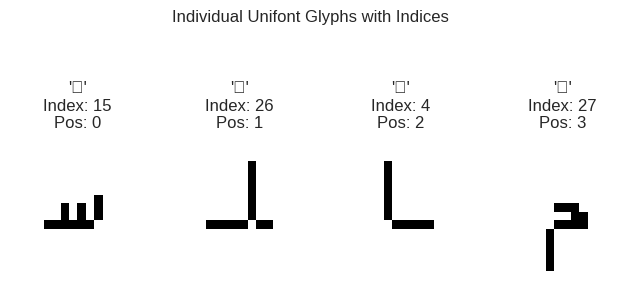

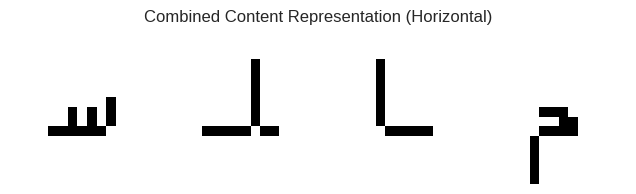


Testing 'شكرا':
Testing content pipeline with text: 'شكرا'

Character set information:
Supported characters: ءأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة٠١٢٣٤٥٦٧٨٩0123456789!"#%&'()*+-./:<=>@[\]^_`{|}~،؛؟ 
Total characters supported: 88

Character to index mapping (with positions):
Position 0: 'ش' → Index 16
Position 1: 'ك' → Index 25
Position 2: 'ر' → Index 13
Position 3: 'ا' → Index 4

Content tensor shape: torch.Size([1, 4, 16, 16])


/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1588 (\N{ARABIC LETTER SHEEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1603 (\N{ARABIC LETTER KAF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1585 (\N{ARABIC LETTER REH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


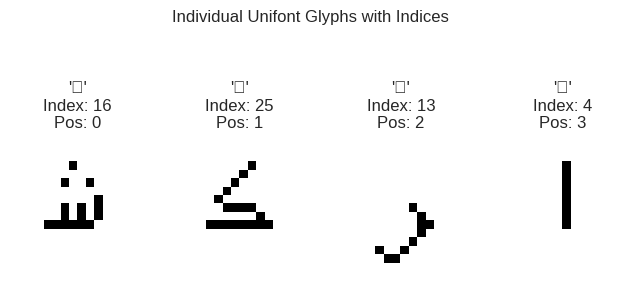

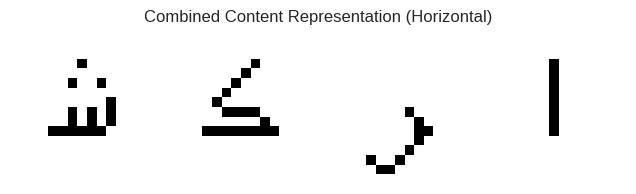


Testing 'نموذج':
Testing content pipeline with text: 'وداعا'

Character set information:
Supported characters: ءأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة٠١٢٣٤٥٦٧٨٩0123456789!"#%&'()*+-./:<=>@[\]^_`{|}~،؛؟ 
Total characters supported: 88

Character to index mapping (with positions):
Position 0: 'و' → Index 30
Position 1: 'د' → Index 11
Position 2: 'ا' → Index 4
Position 3: 'ع' → Index 21
Position 4: 'ا' → Index 4

Content tensor shape: torch.Size([1, 5, 16, 16])


/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1608 (\N{ARABIC LETTER WAW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1583 (\N{ARABIC LETTER DAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1593 (\N{ARABIC LETTER AIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


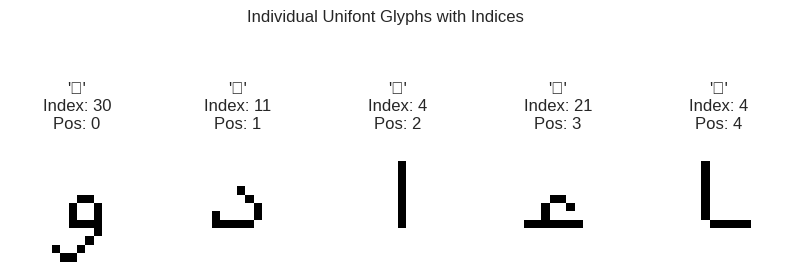

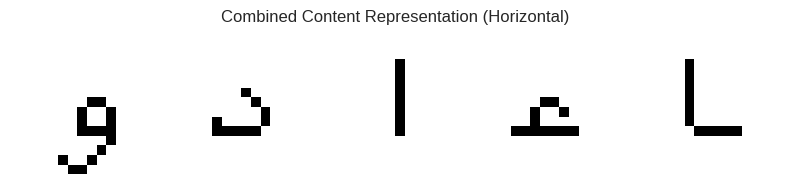


✅ ALL TESTS COMPLETED!


In [7]:
"""
Simple test blocks for English content pipeline - similar to user's example
Tests content generation, letter2index mapping, and glyph visualization
"""

import torch
import matplotlib.pyplot as plt
import sys
import os

# Add the current directory to the path
# sys.path.append(os.path.dirname(os.path.abspath(__file__)))

from data_loader.loader_ara import ContentData

# Initialize the English content loader
print("🔍 Initializing English Content Tester...")
tester = ContentData(content_type='unifont')
print(f"✅ Initialized with {len(tester.letters)} supported characters")
print(f"📊 Content symbols tensor shape: {tester.con_symbols.shape}")

def test_content_pipeline(text="مرحبا"):
    """Test content pipeline for English text - similar to user's example"""
    print(f"Testing content pipeline with text: '{text}'")
    
    # 1. Character set validation
    print("\nCharacter set information:")
    print(f"Supported characters: {tester.letters}")
    print(f"Total characters supported: {len(tester.letters)}")
    
    # 2. Character to index mapping with position information
    print("\nCharacter to index mapping (with positions):")
    for pos, char in enumerate(text):
        try:
            idx = tester.letter2index[char]
            print(f"Position {pos}: '{char}' → Index {idx}")
        except KeyError:
            print(f"WARNING: Character '{char}' not in supported set!")
    
    # 3. Get and visualize content tensor
    content_tensor = tester.get_content(text)
    print(f"\nContent tensor shape: {content_tensor.shape}")
    
    # Plot individual glyphs with indices
    plt.figure(figsize=(2*len(text), 4))
    for i in range(content_tensor.shape[1]):
        plt.subplot(1, len(text), i+1)
        plt.imshow(content_tensor[0,i].numpy(), cmap='gray')
        idx = tester.letter2index[text[i]]
        plt.title(f"'{text[i]}'\nIndex: {idx}\nPos: {i}")
        plt.axis('off')
    plt.suptitle("Individual Unifont Glyphs with Indices")
    plt.show()
    
    # Plot combined representation horizontally
    plt.figure(figsize=(10,2))
    # Concatenate horizontally
    combined = torch.cat([content_tensor[0,i] for i in range(content_tensor.shape[1])], dim=1)
    plt.imshow(combined.numpy(), cmap='gray')
    plt.title("Combined Content Representation (Horizontal)")
    plt.axis('off')
    plt.show()
    
    return content_tensor

def test_pickle_examination():
    """Test 1: Examine the pickle file structure"""
    print("\n" + "="*50)
    print("🔍 EXAMINING UNIFONT.PICKLE FILE")
    print("="*50)
    
    import pickle
    try:
        with open("data/unifont.pickle", "rb") as f:
            pickle_data = pickle.load(f)
        
        print(f"📦 Pickle data type: {type(pickle_data)}")
        
        if isinstance(pickle_data, list):
            print(f"📊 Total entries: {len(pickle_data)}")
            print(f"🔍 First entry keys: {list(pickle_data[0].keys()) if pickle_data else 'Empty'}")
            
            # Show some sample entries
            print("\nSample entries:")
            for i, entry in enumerate(pickle_data[:5]):
                if isinstance(entry, dict) and 'idx' in entry:
                    char_code = entry['idx'][0] if isinstance(entry['idx'], (list, tuple)) else entry['idx']
                    try:
                        char = chr(char_code)
                        print(f"  Entry {i}: '{char}' (ord:{char_code}) → glyph shape: {entry.get('mat', 'No mat').shape if hasattr(entry.get('mat'), 'shape') else 'No shape'}")
                    except:
                        print(f"  Entry {i}: Invalid char code {char_code}")
        
        print("✅ Pickle examination completed")
        
    except Exception as e:
        print(f"❌ Error examining pickle: {e}")

def test_letter2index_mapping():
    """Test 2: Check letter2index mapping"""
    print("\n" + "="*50)
    print("🔍 TESTING LETTER2INDEX MAPPING")
    print("="*50)
    
    print(f"📝 Letters string: '{tester.letters}'")
    print(f"📊 Total characters: {len(tester.letters)}")
    print(f"🔤 Letter2index entries: {len(tester.letter2index)}")
    
    # Test specific characters
    test_chars = ['م', 'ر', 'ح', 'ء', ' ', '_', '.', '!', '؟']
    print(f"\nTesting specific characters:")
    for char in test_chars:
        if char in tester.letter2index:
            idx = tester.letter2index[char]
            print(f"  '{char}' (ord:{ord(char)}) → Index {idx}")
        else:
            print(f"  '{char}' → NOT FOUND ❌")
    
    # Check index ranges
    indices = list(tester.letter2index.values())
    print(f"\nIndex statistics:")
    print(f"  Min index: {min(indices)}")
    print(f"  Max index: {max(indices)}")
    print(f"  Index range: {max(indices) - min(indices) + 1}")
    print(f"  Expected range: {len(tester.letters)}")

def test_get_symbols():
    """Test 3: Test get_symbols method"""
    print("\n" + "="*50)
    print("🔍 TESTING GET_SYMBOLS METHOD")
    print("="*50)
    
    print(f"🔤 Content symbols tensor shape: {tester.con_symbols.shape}")
    print(f"📊 Expected shape: [{len(tester.letters)+1}, 16, 16]")  # +1 for PAD
    
    # Test individual glyphs
    test_chars = ['م', 'ر', 'ح', 'ب', 'ا', 'و', 'ع']
    print(f"\nTesting individual glyphs:")
    for char in test_chars:
        if char in tester.letter2index:
            idx = tester.letter2index[char]
            glyph = tester.con_symbols[idx]
            non_zero = torch.count_nonzero(glyph)
            print(f"  '{char}' → Index {idx} → Non-zero pixels: {non_zero}")
    
    # Check PAD token
    pad_idx = len(tester.letters)
    if pad_idx < tester.con_symbols.shape[0]:
        pad_glyph = tester.con_symbols[pad_idx]
        pad_non_zero = torch.count_nonzero(pad_glyph)
        print(f"\n🔤 PAD_TOKEN → Index {pad_idx} → Non-zero pixels: {pad_non_zero}")
        print(f"✅ PAD is blank: {pad_non_zero == 0}")

# Run all tests
if __name__ == "__main__":
    print("🚀 RUNNING ENGLISH CONTENT PIPELINE TESTS")
    print("="*60)
    
    # Run individual tests
    test_pickle_examination()
    test_letter2index_mapping() 
    test_get_symbols()
    
    print("\n" + "="*60)
    print("🔍 TESTING CONTENT PIPELINE WITH DIFFERENT WORDS")
    print("="*60)
    
    # Test with different inputs (similar to user's example)
    print("Testing 'مرحبا':")
    content_tensor = test_content_pipeline("سلام")
    
    print("\nTesting 'شكرا':")
    content_tensor = test_content_pipeline("شكرا")
    
    print("\nTesting 'نموذج':")
    content_tensor = test_content_pipeline("وداعا")
    
    print("\n" + "="*60)
    print("✅ ALL TESTS COMPLETED!")
    print("="*60) 

## 1. Configuration and Model Loading

First, let's load the configuration and initialize our models.

In [8]:
class OneDMTester:
    def __init__(self, config_path='configs/IAM64.yml', checkpoint_path=None, device='cuda'):
        self.device = device
        
        # Load configuration
        cfg_from_file(config_path)
        assert_and_infer_cfg()
        self.cfg = cfg
        
        # Initialize models
        self.unet = UNetModel(
            in_channels=cfg.MODEL.IN_CHANNELS,
            model_channels=cfg.MODEL.EMB_DIM,
            out_channels=cfg.MODEL.OUT_CHANNELS,
            num_res_blocks=cfg.MODEL.NUM_RES_BLOCKS,
            attention_resolutions=(1,1),
            channel_mult=(1, 1),
            num_heads=cfg.MODEL.NUM_HEADS,
            context_dim=cfg.MODEL.EMB_DIM
        ).to(device)
        
        # Load checkpoint if provided
        if checkpoint_path:
            self.unet.load_state_dict(torch.load(checkpoint_path, map_location=device))
            print(f"Loaded checkpoint from {checkpoint_path}")
        
        self.vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder="vae").to(device)
        self.vae.requires_grad_(False)
        
        self.diffusion = Diffusion(device=device)
        
        # Initialize data handlers
        self.content_data = ContentData()
        
    def plot_tensor_grid(self, tensor, title=None, figsize=(10,10)):
        """Helper function to plot a grid of tensor images"""
        if len(tensor.shape) == 4:  # [B,C,H,W]
            if tensor.shape[1] > 3:  # More than 3 channels
                tensor = tensor[:,:3]  # Take first 3 channels
            grid = torchvision.utils.make_grid(tensor, normalize=True)
            plt.figure(figsize=figsize)
            plt.imshow(grid.permute(1,2,0).cpu().numpy())
        elif len(tensor.shape) == 3:  # [C,H,W]
            plt.figure(figsize=figsize)
            plt.imshow(tensor.cpu().numpy(), cmap='gray')
        elif len(tensor.shape) == 2:  # [H,W]
            plt.figure(figsize=figsize)
            plt.imshow(tensor.cpu().numpy(), cmap='gray')
            
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()
#./Downloads/Saved/IAM64_scratch/Arabic-20250520_004658/model/789-ckpt.pt
# Initialize the tester

tester = OneDMTester(checkpoint_path='../Downloads/Saved/IAM64_scratch/Arabic_NEW_LOADER_700After300-20250705_135044/model/304-ckpt.pt')

FileNotFoundError: [Errno 2] No such file or directory: '../Downloads/Saved/IAM64_scratch/Arabic_NEW_LOADER_700After300-20250705_135044/model/304-ckpt.pt'

✅ ContentData initialised   –  88 supported chars
✅ Dataset loaded            –  42887 samples
📊 Glyph tensor shape        –  torch.Size([89, 16, 16])

🔍 EXAMINING unifont.pickle
type=<class 'list'>  entries=55659
  0: U+0000  glyph_shape=(16, 16)
  1: U+0001  glyph_shape=(16, 16)
  2: U+0002  glyph_shape=(16, 16)
  3: U+0003  glyph_shape=(16, 16)
  4: U+0004  glyph_shape=(16, 16)
✅ Pickle examination done.

🔍 TESTING letter2index MAPPING
string len=88   dict len=169
  'ء' → 0
  'أ' → 1
  'إ' → 2
  'آ' → 3
  'ا' → 4
  'ب' → 5
  'ت' → 6
  'ث' → 7
  'ج' → 8
  'ح' → 9
  'خ' → 10
  'د' → 11
  'ذ' → 12
  'ر' → 13
  'ز' → 14
⚠️ extra   : ['ﺄ', 'ﺈ', 'ﺂ', 'ﺎ', 'ﺑ', 'ﺒ', 'ﺐ', 'ﺗ', 'ﺘ', 'ﺖ', 'ﺛ', 'ﺜ', 'ﺚ', 'ﺟ', 'ﺠ', 'ﺞ', 'ﺣ', 'ﺤ', 'ﺢ', 'ﺧ', 'ﺨ', 'ﺦ', 'ﺪ', 'ﺬ', 'ﺮ', 'ﺰ', 'ﺳ', 'ﺴ', 'ﺲ', 'ﺷ', 'ﺸ', 'ﺶ', 'ﺻ', 'ﺼ', 'ﺺ', 'ﺿ', 'ﻀ', 'ﺾ', 'ﻃ', 'ﻄ', 'ﻂ', 'ﻇ', 'ﻈ', 'ﻆ', 'ﻋ', 'ﻌ', 'ﻊ', 'ﻏ', 'ﻐ', 'ﻎ', 'ﻓ', 'ﻔ', 'ﻒ', 'ﻗ', 'ﻘ', 'ﻖ', 'ﻛ', 'ﻜ', 'ﻚ', 'ﻟ', 'ﻠ', 'ﻞ', 'ﻣ', 'ﻤ', 'ﻢ', 'ﻧ', 'ﻨ', 'ﻦ', 'ﻫ', 'ﻬ', 'ﻪ', 'ﻮ',

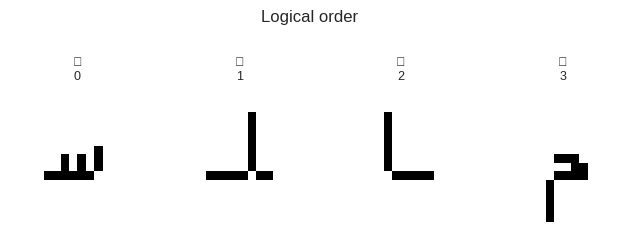

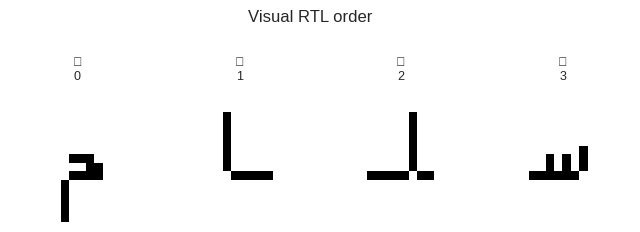


🔍 TESTING CONTENT PIPELINE – 'حمزة'
  'ح' form=initial  idx=9
  'م' form=medial   idx=27
  'ز' form=final    idx=14
  'ة' form=isolated idx=35
tensor shape: torch.Size([1, 4, 16, 16])


/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1586 (\N{ARABIC LETTER ZAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1577 (\N{ARABIC LETTER TEH MARBUTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


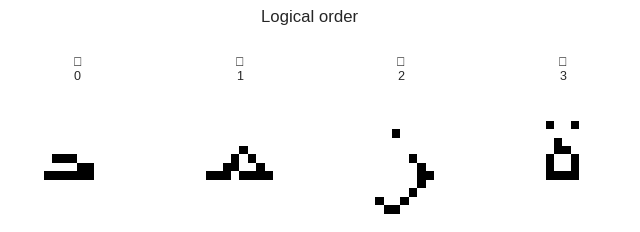

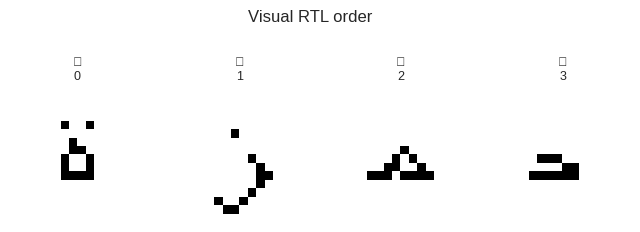


🔍 TESTING CONTENT PIPELINE – 'كتاب'
  'ك' form=initial  idx=25
  'ت' form=medial   idx=6
  'ا' form=final    idx=4
  'ب' form=isolated idx=5
tensor shape: torch.Size([1, 4, 16, 16])


/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1578 (\N{ARABIC LETTER TEH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


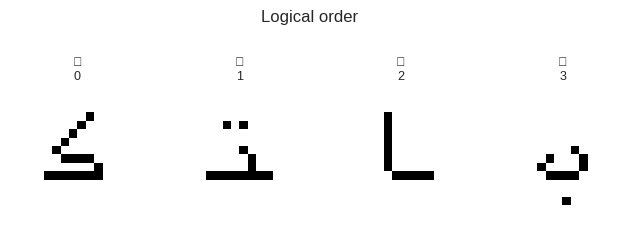

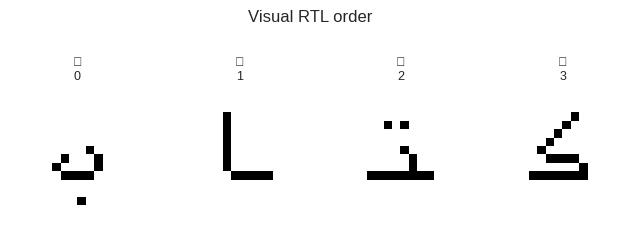


🔍 TESTING CONTENT PIPELINE – 'قلم'
  'ق' form=initial  idx=24
  'ل' form=medial   idx=26
  'م' form=final    idx=27
tensor shape: torch.Size([1, 3, 16, 16])


/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1602 (\N{ARABIC LETTER QAF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


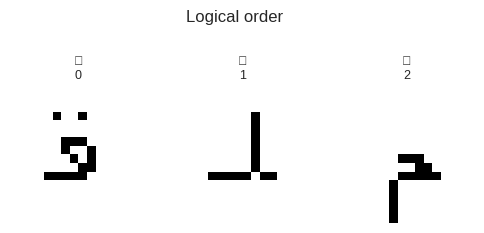

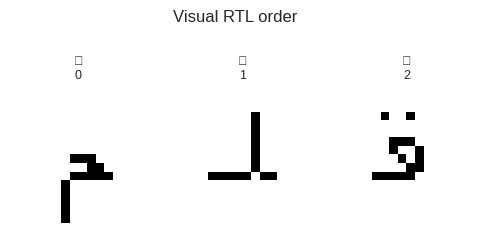


🔍 TESTING CONTENT PIPELINE – 'One'
  'O' form=default  idx=169
  'n' form=default  idx=169
  'e' form=default  idx=169
tensor shape: torch.Size([1, 3, 16, 16])


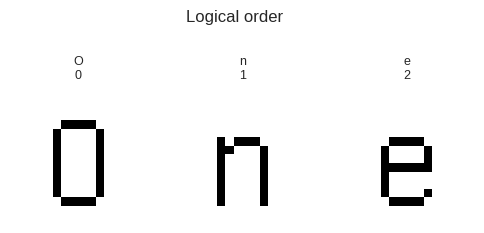

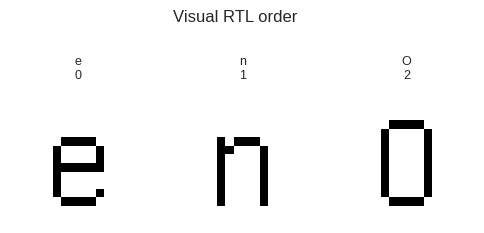


🔍 TESTING CONTENT PIPELINE – 'AI'
  'A' form=default  idx=169
  'I' form=default  idx=169
tensor shape: torch.Size([1, 2, 16, 16])


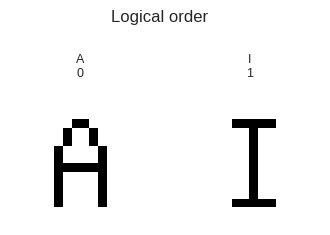

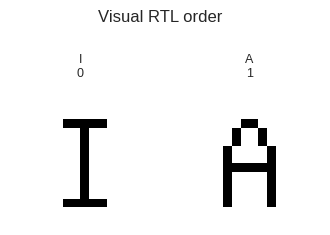


✅ ALL TESTS COMPLETED


In [5]:
#!/usr/bin/env python3
"""
Comprehensive test-bed for the Arabic content pipeline
and dataset collation.
"""

import os, pickle, numpy as np, torch, matplotlib.pyplot as plt
from data_loader.loader_ara import IAMDataset, ContentData, shape_arabic_text
from parse_config import cfg, cfg_from_file, assert_and_infer_cfg

# ────────────────────────── GLOBALS ────────────────────────── #

cfg_from_file('configs/IAM64_scratch.yml')
assert_and_infer_cfg()

tester = ContentData('unifont')            # glyph helper
ds      = IAMDataset(cfg.DATA_LOADER.IAMGE_PATH,
                     cfg.DATA_LOADER.STYLE_PATH,
                     cfg.DATA_LOADER.LAPLACE_PATH,
                     cfg.TRAIN.TYPE)

# one-time code-point → glyph lookup (16×16 tensors)
with open('data/unifont.pickle', 'rb') as f:
    _pdata = pickle.load(f)
CODE2GLYPH = { (e['idx'][0] if isinstance(e['idx'], (list, tuple))
               else e['idx']): torch.from_numpy(e['mat'].astype('float32'))
               for e in _pdata }

print(f"✅ ContentData initialised   –  {len(tester.letters)} supported chars")
print(f"✅ Dataset loaded            –  {len(ds)} samples")
print(f"📊 Glyph tensor shape        –  {tester.con_symbols.shape}")

# ────────────────────────── UTILITIES ───────────────────────── #

def visualise_glyphs(glyph_tensor, chars, title):
    glyph_tensor = glyph_tensor.squeeze(0)          # [N,16,16]
    n = glyph_tensor.shape[0]
    plt.figure(figsize=(2*n, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(glyph_tensor[i].numpy(), cmap='gray')
        plt.title(f"{chars[i]}\n{i}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# ────────────────────────── TEST BLOCKS ─────────────────────── #

def test_pickle_examination():
    print("\n" + "="*60)
    print("🔍 EXAMINING unifont.pickle")
    print("="*60)
    with open('data/unifont.pickle', 'rb') as f:
        pdata = pickle.load(f)
    print(f"type={type(pdata)}  entries={len(pdata)}")
    for i, e in enumerate(pdata[:5]):
        cp = e['idx'][0] if isinstance(e['idx'], (list, tuple)) else e['idx']
        print(f"  {i}: U+{cp:04X}  glyph_shape={e['mat'].shape}")
    print("✅ Pickle examination done.")

def test_letter2index_mapping():
    print("\n" + "="*60)
    print("🔍 TESTING letter2index MAPPING")
    print("="*60)
    letters, l2i = tester.letters, tester.letter2index
    print(f"string len={len(letters)}   dict len={len(l2i)}")
    for ch in letters[:15]:
        print(f"  '{ch}' → {l2i[ch]}")
    missing = [c for c in letters if c not in l2i]
    extra   = [c for c in l2i if c not in letters]
    if not missing and not extra:
        print("✅ perfect 1-to-1 match")
    else:
        if missing: print("⚠️ missing:", missing)
        if extra:   print("⚠️ extra   :", extra)

def test_get_symbols():
    print("\n" + "="*60)
    print("🔍 TESTING get_symbols OUTPUT")
    print("="*60)
    rows = tester.con_symbols.shape[0]
    expected = len(tester.letters) + 1          # +PAD
    print(f"rows={rows} expected≥{expected}  glyph_size={tester.con_symbols.shape[1:]}")
    pad_glyph = tester.con_symbols[len(tester.letters)]
    print("PAD non-zero pixels:", torch.count_nonzero(pad_glyph))

def test_content_pipeline(word="حمزة"):
    print("\n" + "="*60)
    print(f"🔍 TESTING CONTENT PIPELINE – '{word}'")
    print("="*60)

    idxs, forms = shape_arabic_text(word, tester.letter2index)
    for ch, idx, form in zip(word, idxs, forms):
        print(f"  '{ch}' form={form:<8} idx={idx}")

    glyph_tensor = tester.get_content(word)     # [1,L,16,16]
    print("tensor shape:", glyph_tensor.shape)
    visualise_glyphs(glyph_tensor, list(word), "Logical order")

    rtl = glyph_tensor[:, torch.arange(len(word)-1, -1, -1)]
    visualise_glyphs(rtl, list(reversed(word)), "Visual RTL order")

# ────────────────────────── MAIN ────────────────────────────── #

if __name__ == "__main__":
    test_pickle_examination()
    test_letter2index_mapping()
    test_get_symbols()

    for w in ["سلام", "حمزة", "كتاب", "قلم", "One", "AI"]:
        try:
            test_content_pipeline(w)
        except Exception as e:
            print(f"⚠️  error rendering '{w}': {e}")

    print("\n✅ ALL TESTS COMPLETED")

## 2. Content Pipeline Testing

Let's examine how text content is processed and prepared for the model.

In [6]:
# def test_content_pipeline(text="hello"):
#     print(f"Testing content pipeline with text: '{text}'")
    
#     # 1. Character set validation
#     print("\nCharacter set information:")
#     print(f"Supported characters: {tester.content_data.letters}")
#     print(f"Total characters supported: {len(tester.content_data.letters)}")
    
#     # 2. Character to index mapping
#     print("\nCharacter to index mapping:")
#     for char in text:
#         try:
#             idx = tester.content_data.letter2index[char]
#             print(f"'{char}' → {idx}")
#         except KeyError:
#             print(f"WARNING: Character '{char}' not in supported set!")
    
#     # 3. Get and visualize content tensor
#     content_tensor = tester.content_data.get_content(text)
#     print(f"\nContent tensor shape: {content_tensor.shape}")
    
#     # Plot individual glyphs
#     plt.figure(figsize=(2*len(text), 3))
#     for i in range(content_tensor.shape[1]):
#         plt.subplot(1, len(text), i+1)
#         plt.imshow(content_tensor[0,i].numpy(), cmap='gray')
#         plt.title(f"'{text[i]}'")
#         plt.axis('off')
#     plt.suptitle("Individual Unifont Glyphs")
#     plt.show()
    
#     # Plot combined representation
#     plt.figure(figsize=(10,2))
#     plt.imshow(content_tensor[0].numpy().reshape(-1, content_tensor.shape[-1]), cmap='gray')
#     plt.title("Combined Content Representation")
#     plt.axis('off')
#     plt.show()
    
#     return content_tensor

# # Test with different inputs
# content_tensor = test_content_pipeline("Hello")
# content_tensor = test_content_pipeline("world")

Testing 'السلام':
Testing content pipeline with text: 'السلام'

Character set information:
Supported characters: ءأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة٠١٢٣٤٥٦٧٨٩0123456789!"#%&'()*+-./:<=>@[\]^_`{|}~،؛؟ 
Total characters supported: 88

Character mapping (with positions and forms):
Position 0: 'ا' → Index 4 (Form: isolated)
Position 1: 'ل' → Index 26 (Form: initial)
Position 2: 'س' → Index 15 (Form: medial)
Position 3: 'ل' → Index 26 (Form: medial)
Position 4: 'ا' → Index 4 (Form: final)
Position 5: 'م' → Index 27 (Form: isolated)

Content tensor shape: torch.Size([1, 6, 16, 16])


/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Glyph 1575 (\N{ARABIC LETTER ALEF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Glyph 1604 (\N{ARABIC LETTER LAM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Glyph 1587 (\N{ARABIC LETTER SEEN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Glyph 1605 (\N{ARABIC LETTER MEEM}) missing from current font.
  plt.tight_layout()


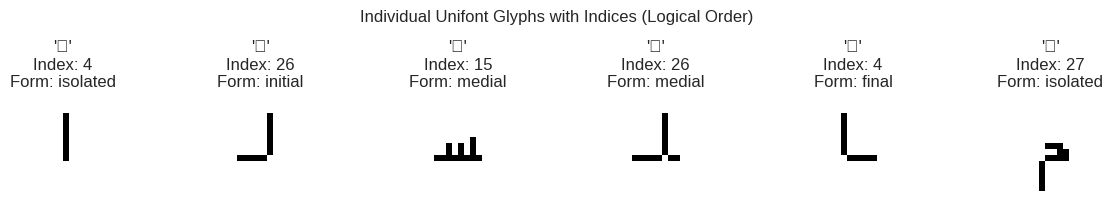

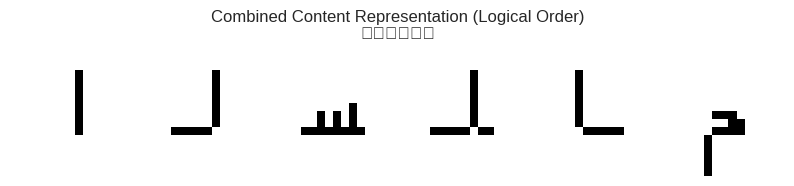


Testing 'مرحبا':
Testing content pipeline with text: 'مرحبا'

Character set information:
Supported characters: ءأإآابتثجحخدذرزسشصضطظعغفقكلمنهويىئؤة٠١٢٣٤٥٦٧٨٩0123456789!"#%&'()*+-./:<=>@[\]^_`{|}~،؛؟ 
Total characters supported: 88

Character mapping (with positions and forms):
Position 0: 'م' → Index 27 (Form: initial)
Position 1: 'ر' → Index 13 (Form: final)
Position 2: 'ح' → Index 9 (Form: initial)
Position 3: 'ب' → Index 5 (Form: medial)
Position 4: 'ا' → Index 4 (Form: final)

Content tensor shape: torch.Size([1, 5, 16, 16])


/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Glyph 1585 (\N{ARABIC LETTER REH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Glyph 1581 (\N{ARABIC LETTER HAH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/3156803017.py:31: UserWarning: Glyph 1576 (\N{ARABIC LETTER BEH}) missing from current font.
  plt.tight_layout()


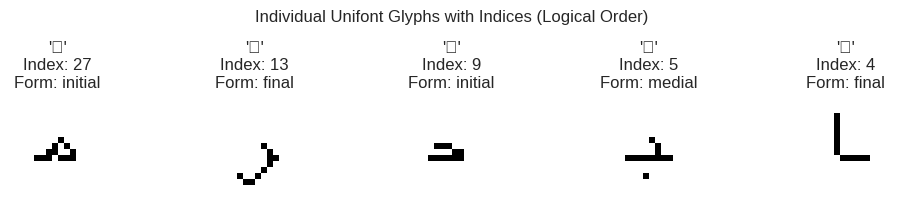

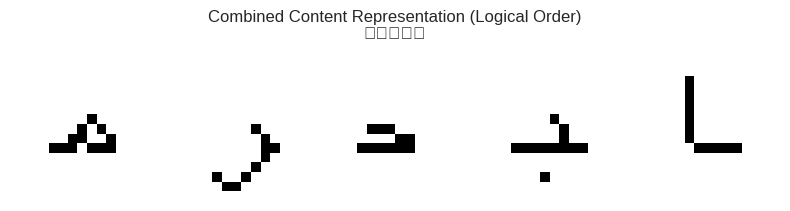

In [7]:
def test_content_pipeline(text="مرحبا"):
    print(f"Testing content pipeline with text: '{text}'")
    
    # 1. Character set validation
    print("\nCharacter set information:")
    print(f"Supported characters: {tester.letters}")             # ← change ①
    print(f"Total characters supported: {len(tester.letters)}")  # ← change ②
    
    # 2. Get indices and forms using shape_arabic_text
    indices, forms = shape_arabic_text(text, tester.letter2index)  # ← change ③
    print("\nCharacter mapping (with positions and forms):")
    for pos, (char, idx, form) in enumerate(zip(text, indices, forms)):
        print(f"Position {pos}: '{char}' → Index {idx} (Form: {form})")
    
    # 3. Get and visualize content tensor
    content_tensor = tester.get_content(text)
    print(f"\nContent tensor shape: {content_tensor.shape}")
    
    # Plot individual glyphs with indices
    glyph_size = 2
    L = content_tensor.shape[1]
    plt.figure(figsize=(glyph_size * L, glyph_size))
    
    # Draw glyphs in logical order
    for i in range(L):
        plt.subplot(1, L, i + 1)
        plt.imshow(content_tensor[0, i].numpy(), cmap='gray')
        plt.title(f"'{text[i]}'\nIndex: {indices[i]}\nForm: {forms[i]}")
        plt.axis('off')
    plt.suptitle("Individual Unifont Glyphs with Indices (Logical Order)")
    plt.tight_layout()
    plt.show()
    
    # Plot combined representation horizontally
    plt.figure(figsize=(10, 2))
    # Concatenate horizontally in logical order
    combined = torch.cat([content_tensor[0, i] for i in range(L)], dim=1)
    plt.imshow(combined.numpy(), cmap='gray')
    plt.title(f"Combined Content Representation (Logical Order)\n{text}")
    plt.axis('off')
    plt.show()
    
    return content_tensor

# Test with different inputs
print("Testing 'السلام':")
content_tensor = test_content_pipeline("السلام")
print("\nTesting 'مرحبا':")
content_tensor = test_content_pipeline("مرحبا")

🚀 Starting Arabic Content Pipeline Debug Test
Initializing Content Pipeline Tester...
✅ Initialized with 42887 samples

TESTING LETTER2INDEX STRUCTURE
Dataset letter2index type: <class 'dict'>
Dataset letter2index keys (first 10): ['ء', 'أ', 'إ', 'آ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح']
'ا': Simple mapping -> 4
'ب': Simple mapping -> 5
'ت': Simple mapping -> 6
'م': Simple mapping -> 27
'ر': Simple mapping -> 13
'ح': Simple mapping -> 9
'ل': Simple mapping -> 26
'0': 46
'1': 47
' ': 87

TESTING CONTENT PIPELINE WITH: 'مرحبا'
Input text: 'مرحبا' (length: 5)

1. Testing shape_arabic_text function:
✅ Shaping successful!
Indices: [27, 13, 9, 5, 4]
Forms: ['initial', 'final', 'initial', 'medial', 'final']
Length: 5

Character breakdown:
  'م' -> Index: 27, Form: initial
  'ر' -> Index: 13, Form: final
  'ح' -> Index: 9, Form: initial
  'ب' -> Index: 5, Form: medial
  'ا' -> Index: 4, Form: final

2. Testing ContentData.get_content:
✅ Content tensor created!
Content tensor shape: torch.Size([1, 5, 

/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1605 (\N{ARABIC LETTER MEEM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1585 (\N{ARABIC LETTER REH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1581 (\N{ARABIC LETTER HAH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1576 (\N{ARABIC LETTER BEH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1575 (\N{ARABIC LETTER ALEF}) missing from current font.
  plt.tight_layout()


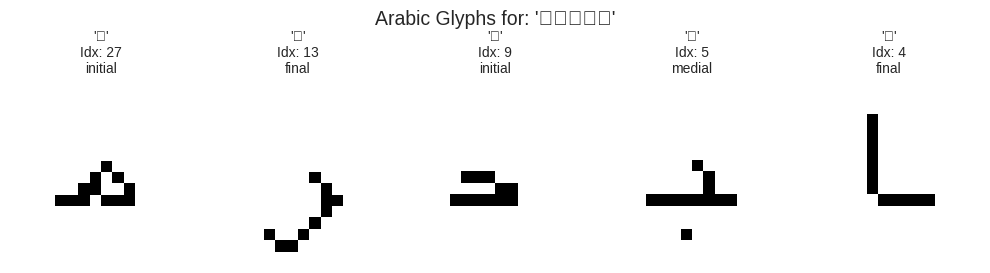


TESTING CONTENT PIPELINE WITH: 'السلام'
Input text: 'السلام' (length: 6)

1. Testing shape_arabic_text function:
✅ Shaping successful!
Indices: [4, 26, 15, 26, 4, 27]
Forms: ['isolated', 'initial', 'medial', 'medial', 'final', 'isolated']
Length: 6

Character breakdown:
  'ا' -> Index: 4, Form: isolated
  'ل' -> Index: 26, Form: initial
  'س' -> Index: 15, Form: medial
  'ل' -> Index: 26, Form: medial
  'ا' -> Index: 4, Form: final
  'م' -> Index: 27, Form: isolated

2. Testing ContentData.get_content:
✅ Content tensor created!
Content tensor shape: torch.Size([1, 6, 16, 16])
Non-zero pixels: 1461


/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1604 (\N{ARABIC LETTER LAM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1587 (\N{ARABIC LETTER SEEN}) missing from current font.
  plt.tight_layout()


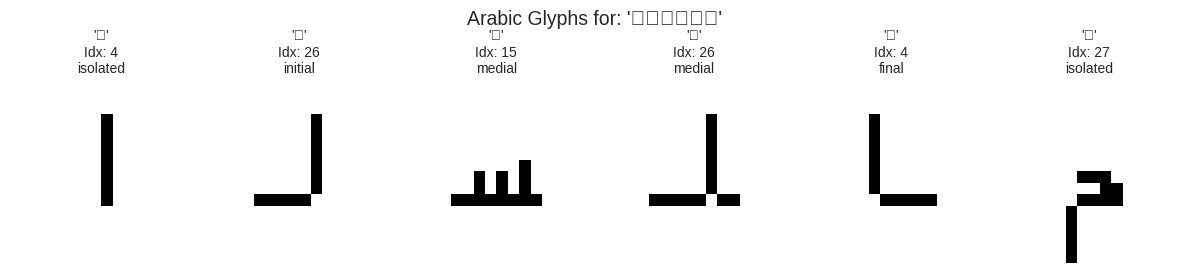


TESTING CONTENT PIPELINE WITH: 'عقل'
Input text: 'عقل' (length: 3)

1. Testing shape_arabic_text function:
✅ Shaping successful!
Indices: [21, 24, 26]
Forms: ['initial', 'medial', 'final']
Length: 3

Character breakdown:
  'ع' -> Index: 21, Form: initial
  'ق' -> Index: 24, Form: medial
  'ل' -> Index: 26, Form: final

2. Testing ContentData.get_content:
✅ Content tensor created!
Content tensor shape: torch.Size([1, 3, 16, 16])
Non-zero pixels: 719


/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1593 (\N{ARABIC LETTER AIN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1602 (\N{ARABIC LETTER QAF}) missing from current font.
  plt.tight_layout()
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1593 (\N{ARABIC LETTER AIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


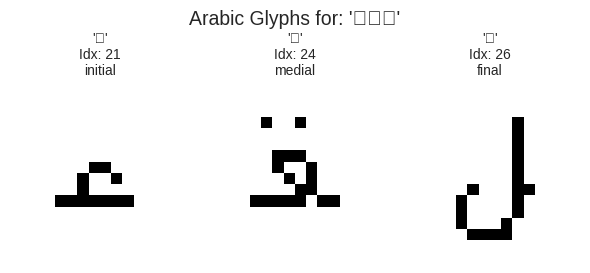


TESTING CONTENT PIPELINE WITH: 'أسد'
Input text: 'أسد' (length: 3)

1. Testing shape_arabic_text function:
✅ Shaping successful!
Indices: [1, 15, 11]
Forms: ['isolated', 'initial', 'final']
Length: 3

Character breakdown:
  'أ' -> Index: 1, Form: isolated
  'س' -> Index: 15, Form: initial
  'د' -> Index: 11, Form: final

2. Testing ContentData.get_content:
✅ Content tensor created!
Content tensor shape: torch.Size([1, 3, 16, 16])
Non-zero pixels: 730


/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1571 (\N{ARABIC LETTER ALEF WITH HAMZA ABOVE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1583 (\N{ARABIC LETTER DAL}) missing from current font.
  plt.tight_layout()
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1571 (\N{ARABIC LETTER ALEF WITH HAMZA ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1583 (\N{ARABIC LETTER DAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


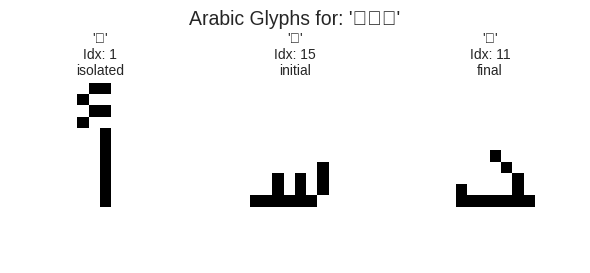


TESTING CONTENT PIPELINE WITH: 'منع'
Input text: 'منع' (length: 3)

1. Testing shape_arabic_text function:
✅ Shaping successful!
Indices: [27, 28, 21]
Forms: ['initial', 'medial', 'final']
Length: 3

Character breakdown:
  'م' -> Index: 27, Form: initial
  'ن' -> Index: 28, Form: medial
  'ع' -> Index: 21, Form: final

2. Testing ContentData.get_content:
✅ Content tensor created!
Content tensor shape: torch.Size([1, 3, 16, 16])
Non-zero pixels: 727


/tmp/ipykernel_4171154/1639085923.py:205: UserWarning: Glyph 1606 (\N{ARABIC LETTER NOON}) missing from current font.
  plt.tight_layout()


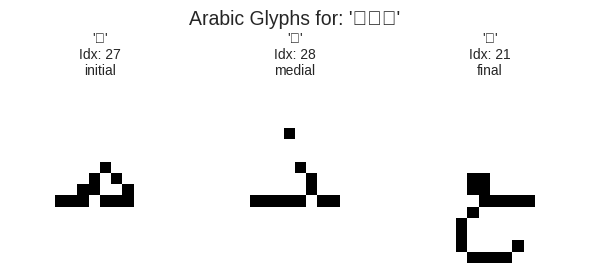


TESTING DATASET COLLATION WITH 3 SAMPLES

Sample 0: 'شأن' (len=3)

Sample 1: 'خبر' (len=3)

Sample 2: 'كتب' (len=3)

Collating batch...
[DEBUG COLLATE] Sample 0: Original content='شأن', len=3
[DEBUG COLLATE] Sample 0: contextual_glyphs shape=torch.Size([3, 16, 16]) base_indices=[16, 1, 28]
[DEBUG COLLATE] letters : ['ش', 'أ', 'ن']
[DEBUG COLLATE] forms   : ['initial', 'final', 'isolated']
[DEBUG COLLATE] codepoints: ['0xfeb7', '0xfe84', '0x646']


/home/rteam8/Downloads/data_loader/loader_ara.py:223: UserWarning: Glyph 1606 (\N{ARABIC LETTER NOON}) missing from current font.
  plt.tight_layout()
/home/rteam8/Downloads/data_loader/loader_ara.py:223: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/home/rteam8/Downloads/data_loader/loader_ara.py:223: UserWarning: Glyph 1571 (\N{ARABIC LETTER ALEF WITH HAMZA ABOVE}) missing from current font.
  plt.tight_layout()
/home/rteam8/Downloads/data_loader/loader_ara.py:223: UserWarning: Glyph 1588 (\N{ARABIC LETTER SHEEN}) missing from current font.
  plt.tight_layout()
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1588 (\N{ARABIC LETTER SHEEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


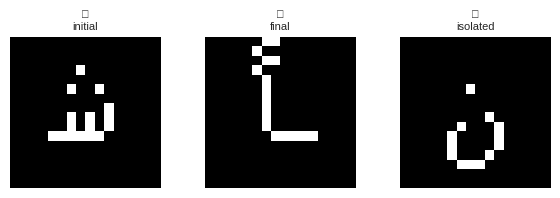

✅ Collation successful!

Collated batch analysis:
Content shape: torch.Size([3, 3, 16, 16])
Target shape: torch.Size([3, 3])
Target lengths: tensor([3, 3, 3], dtype=torch.int32)

First sample analysis:
Target indices: [16, 1, 28]
Target length: 3
Original text: 'شأن'

COMPARING OLD vs NEW MAPPING FOR: 'عقل'
OLD (Simple) Mapping:
  'ع' -> 21
  'ق' -> 24
  'ل' -> 26
Old indices: [21, 24, 26]
Max old index: 26

NEW (Contextual) Mapping:
  'ع' -> 21 (Form: initial)
  'ق' -> 24 (Form: medial)
  'ل' -> 26 (Form: final)
New indices: [21, 24, 26]
Max new index: 26

COMPARISON:
Old max index: 26 (simple alphabet position)
New max index: 26 (contextual Arabic glyph)
Difference: 0

COMPARING OLD vs NEW MAPPING FOR: 'مرحبا'
OLD (Simple) Mapping:
  'م' -> 27
  'ر' -> 13
  'ح' -> 9
  'ب' -> 5
  'ا' -> 4
Old indices: [27, 13, 9, 5, 4]
Max old index: 27

NEW (Contextual) Mapping:
  'م' -> 27 (Form: initial)
  'ر' -> 13 (Form: final)
  'ح' -> 9 (Form: initial)
  'ب' -> 5 (Form: medial)
  'ا' -> 4 (Form

In [8]:
#!/usr/bin/env python3

"""
Comprehensive test script to debug Arabic content pipeline and dataset collation
"""

import torch
import matplotlib.pyplot as plt
import numpy as np
from data_loader.loader_ara import IAMDataset, ContentData, shape_arabic_text
from parse_config import cfg, cfg_from_file, assert_and_infer_cfg

class ContentPipelineTester:
    def __init__(self):
        print("Initializing Content Pipeline Tester...")
        
        # Load config
        cfg_from_file('configs/IAM64_scratch.yml')
        assert_and_infer_cfg()
        
        # Create dataset and content data
        self.dataset = IAMDataset(
            cfg.DATA_LOADER.IAMGE_PATH, 
            cfg.DATA_LOADER.STYLE_PATH, 
            cfg.DATA_LOADER.LAPLACE_PATH, 
            cfg.TRAIN.TYPE
        )
        
        self.content_data = ContentData('unifont')
        print(f"✅ Initialized with {len(self.dataset)} samples")
        
    def test_letter2index_structure(self):
        """Test the letter2index structure"""
        print("\n" + "="*60)
        print("TESTING LETTER2INDEX STRUCTURE")
        print("="*60)
        
        # Check dataset letter2index
        print(f"Dataset letter2index type: {type(self.dataset.letter2index)}")
        print(f"Dataset letter2index keys (first 10): {list(self.dataset.letter2index.keys())[:10]}")
        
        # Check a few Arabic characters
        test_chars = ['ا', 'ب', 'ت', 'م', 'ر', 'ح', 'ل']
        for char in test_chars:
            if char in self.dataset.letter2index:
                mapping = self.dataset.letter2index[char]
                if isinstance(mapping, dict):
                    print(f"'{char}': Complex mapping with forms: {list(mapping.keys())}")
                    if 'isolated' in mapping:
                        print(f"  isolated base: {mapping['isolated']['base']}")
                else:
                    print(f"'{char}': Simple mapping -> {mapping}")
        
        # Check non-Arabic characters
        for char in ['0', '1', ' ']:
            if char in self.dataset.letter2index:
                print(f"'{char}': {self.dataset.letter2index[char]}")
    
    def test_content_pipeline(self, text="مرحبا"):
        """Test the complete content pipeline"""
        print("\n" + "="*60)
        print(f"TESTING CONTENT PIPELINE WITH: '{text}'")
        print("="*60)
        
        print(f"Input text: '{text}' (length: {len(text)})")
        
        # Test shape_arabic_text function
        print("\n1. Testing shape_arabic_text function:")
        try:
            indices, forms = shape_arabic_text(text, self.dataset.letter2index)
            print(f"✅ Shaping successful!")
            print(f"Indices: {indices}")
            print(f"Forms: {forms}")
            print(f"Length: {len(indices)}")
            
            # Character-by-character breakdown
            print("\nCharacter breakdown:")
            for i, char in enumerate(text):
                if i < len(indices):
                    print(f"  '{char}' -> Index: {indices[i]}, Form: {forms[i]}")
                    
        except Exception as e:
            print(f"❌ Shaping failed: {e}")
            import traceback
            traceback.print_exc()
            return None
        
        # Test ContentData.get_content
        print("\n2. Testing ContentData.get_content:")
        try:
            content_tensor = self.content_data.get_content(text)
            print(f"✅ Content tensor created!")
            print(f"Content tensor shape: {content_tensor.shape}")
            print(f"Non-zero pixels: {torch.count_nonzero(content_tensor)}")
            
        except Exception as e:
            print(f"❌ Content tensor creation failed: {e}")
            import traceback
            traceback.print_exc()
            return None
            
        # Visualize glyphs
        self.visualize_glyphs(text, content_tensor, indices, forms)
        
        return content_tensor, indices, forms
    
    def test_dataset_collation(self, num_samples=3):
        """Test dataset collation with debugging"""
        print("\n" + "="*60)
        print(f"TESTING DATASET COLLATION WITH {num_samples} SAMPLES")
        print("="*60)
        
        # Get sample items
        batch = []
        for i in range(min(num_samples, len(self.dataset))):
            item = self.dataset[i]
            print(f"\nSample {i}: '{item['content']}' (len={len(item['content'])})")
            batch.append(item)
        
        # Test collation
        try:
            print("\nCollating batch...")
            collated = self.dataset.collate_fn_(batch)
            print(f"✅ Collation successful!")
            
            # Analyze collated results
            print(f"\nCollated batch analysis:")
            print(f"Content shape: {collated['content'].shape}")
            print(f"Target shape: {collated['target'].shape}")
            print(f"Target lengths: {collated['target_lengths']}")
            
            # Check first sample in detail
            print(f"\nFirst sample analysis:")
            first_target_len = collated['target_lengths'][0].item()
            first_target = collated['target'][0, :first_target_len]
            print(f"Target indices: {first_target.tolist()}")
            print(f"Target length: {first_target_len}")
            print(f"Original text: '{batch[0]['content']}'")
            
            return collated
            
        except Exception as e:
            print(f"❌ Collation failed: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def compare_old_vs_new_mapping(self, text="مرحبا"):
        """Compare old simple mapping vs new contextual mapping"""
        print("\n" + "="*60)
        print(f"COMPARING OLD vs NEW MAPPING FOR: '{text}'")
        print("="*60)
        
        # Simulate old mapping (simple character-to-index)
        simple_letter2index = {label: n for n, label in enumerate(self.dataset.letters)}
        
        print("OLD (Simple) Mapping:")
        old_indices = []
        for i, char in enumerate(text):
            if char in simple_letter2index:
                idx = simple_letter2index[char]
                old_indices.append(idx)
                print(f"  '{char}' -> {idx}")
            else:
                print(f"  '{char}' -> NOT FOUND")
        
        print(f"Old indices: {old_indices}")
        print(f"Max old index: {max(old_indices) if old_indices else 0}")
        
        # New mapping (contextual)
        print("\nNEW (Contextual) Mapping:")
        try:
            new_indices, forms = shape_arabic_text(text, self.dataset.letter2index)
            for i, char in enumerate(text):
                if i < len(new_indices):
                    print(f"  '{char}' -> {new_indices[i]} (Form: {forms[i]})")
            
            print(f"New indices: {new_indices}")
            print(f"Max new index: {max(new_indices) if new_indices else 0}")
            
            # Compare
            print(f"\nCOMPARISON:")
            print(f"Old max index: {max(old_indices) if old_indices else 0} (simple alphabet position)")
            print(f"New max index: {max(new_indices) if new_indices else 0} (contextual Arabic glyph)")
            print(f"Difference: {max(new_indices) - max(old_indices) if old_indices and new_indices else 'N/A'}")
            
        except Exception as e:
            print(f"❌ New mapping failed: {e}")
    
    def visualize_glyphs(self, text, content_tensor, indices, forms):
        """Visualize the glyphs"""
        try:
            L = content_tensor.shape[1]
            fig, axes = plt.subplots(1, L, figsize=(L * 2, 3))
            
            if L == 1:
                axes = [axes]
            
            for i in range(L):
                axes[i].imshow(content_tensor[0, i].numpy(), cmap='gray')
                axes[i].set_title(f"'{text[i]}'\nIdx: {indices[i]}\n{forms[i]}", fontsize=10)
                axes[i].axis('off')
            
            plt.suptitle(f"Arabic Glyphs for: '{text}'", fontsize=14)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"❌ Visualization failed: {e}")

def main():
    """Main test function"""
    print("🚀 Starting Arabic Content Pipeline Debug Test")
    print("="*80)
    
    try:
        # Initialize tester
        tester = ContentPipelineTester()
        
        # Test 1: Check letter2index structure
        tester.test_letter2index_structure()
        
        # Test 2: Test content pipeline with different texts
        test_texts = ["مرحبا", "السلام", "عقل", "أسد", "منع"]
        
        for text in test_texts:
            result = tester.test_content_pipeline(text)
            if result is None:
                print(f"❌ Failed to process '{text}'")
                continue
                
        # Test 3: Test dataset cobllation
        tester.test_dataset_collation(3)
        
        # Test 4: Compare old vs new mapping
        for text in ["عقل", "مرحبا"]:
            tester.compare_old_vs_new_mapping(text)
        
        print("\n" + "="*80)
        print("🎉 All tests completed!")
        
    except Exception as e:
        print(f"💥 Test suite failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main() 

🚀 Starting Arabic Content Pipeline Debug Test
Initializing Content Pipeline Tester...
✅ Initialized with 42887 samples

TESTING LETTER2INDEX STRUCTURE
Dataset letter2index type: <class 'dict'>
Dataset letter2index keys (first 10): ['ء', 'أ', 'إ', 'آ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح']
'ا': Simple mapping -> 4
'ب': Simple mapping -> 5
'ت': Simple mapping -> 6
'م': Simple mapping -> 27
'ر': Simple mapping -> 13
'ح': Simple mapping -> 9
'ل': Simple mapping -> 26
'0': 46
'1': 47
' ': 87

TESTING INDEX MAPPING AND CONSISTENCY

1. BASIC INDEX INVESTIGATION:
----------------------------------------
Dataset letter2index reverse lookup:
  Index    0: ["'ء' (simple)"] | tensor_shape=torch.Size([16, 16]), non_zero=10
  Index    1: ["'أ' (simple)"] | tensor_shape=torch.Size([16, 16]), non_zero=13
  Index    2: ["'إ' (simple)"] | tensor_shape=torch.Size([16, 16]), non_zero=13
  Index    5: ["'ب' (simple)"] | tensor_shape=torch.Size([16, 16]), non_zero=10
  Index    6: ["'ت' (simple)"] | tensor_shape=to

/tmp/ipykernel_4171154/2809073866.py:362: UserWarning: Glyph 1569 (\N{ARABIC LETTER HAMZA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:362: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:362: UserWarning: Glyph 1571 (\N{ARABIC LETTER ALEF WITH HAMZA ABOVE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:362: UserWarning: Glyph 1573 (\N{ARABIC LETTER ALEF WITH HAMZA BELOW}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:362: UserWarning: Glyph 1635 (\N{ARABIC-INDIC DIGIT THREE}) missing from current font.
  plt.tight_layout()
/home/rteam8/anaconda3/envs/torch13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1573 (\N{ARABIC LETTER ALEF WITH HAMZA BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rteam8/anaconda3/envs/torch13/lib/p

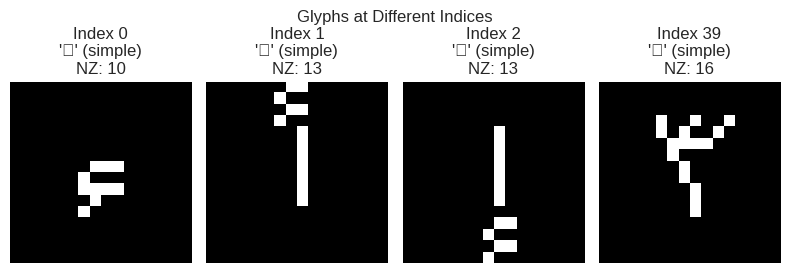


TESTING CONTENT PIPELINE WITH: 'مرحبا'
Input text: 'مرحبا' (length: 5)

1. Testing shape_arabic_text function:
✅ Shaping successful!
Indices: [27, 13, 9, 5, 4]
Forms: ['initial', 'final', 'initial', 'medial', 'final']
Length: 5

Character breakdown:
  'م' -> Index: 27, Form: initial
  'ر' -> Index: 13, Form: final
  'ح' -> Index: 9, Form: initial
  'ب' -> Index: 5, Form: medial
  'ا' -> Index: 4, Form: final

2. Testing ContentData.get_content:
✅ Content tensor created!
Content tensor shape: torch.Size([1, 5, 16, 16])
Non-zero pixels: 1223


/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1605 (\N{ARABIC LETTER MEEM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1585 (\N{ARABIC LETTER REH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1581 (\N{ARABIC LETTER HAH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1576 (\N{ARABIC LETTER BEH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1575 (\N{ARABIC LETTER ALEF}) missing from current font.
  plt.tight_layout()


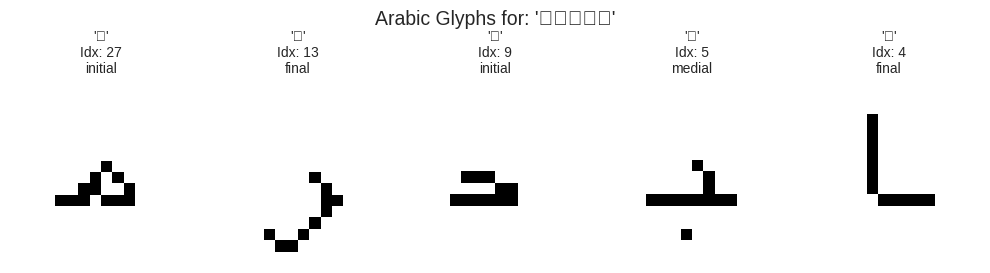


TESTING CONTENT PIPELINE WITH: 'عقل'
Input text: 'عقل' (length: 3)

1. Testing shape_arabic_text function:
✅ Shaping successful!
Indices: [21, 24, 26]
Forms: ['initial', 'medial', 'final']
Length: 3

Character breakdown:
  'ع' -> Index: 21, Form: initial
  'ق' -> Index: 24, Form: medial
  'ل' -> Index: 26, Form: final

2. Testing ContentData.get_content:
✅ Content tensor created!
Content tensor shape: torch.Size([1, 3, 16, 16])
Non-zero pixels: 719


/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1593 (\N{ARABIC LETTER AIN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1602 (\N{ARABIC LETTER QAF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4171154/2809073866.py:538: UserWarning: Glyph 1604 (\N{ARABIC LETTER LAM}) missing from current font.
  plt.tight_layout()


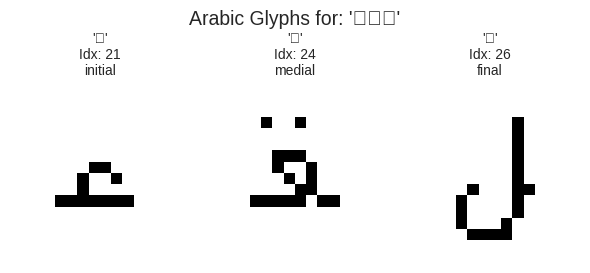


TESTING DATASET COLLATION WITH 2 SAMPLES

Sample 0: 'شأن' (len=3)

Sample 1: 'خبر' (len=3)

Collating batch...
[DEBUG COLLATE] Sample 0: Original content='شأن', len=3
[DEBUG COLLATE] Sample 0: contextual_glyphs shape=torch.Size([3, 16, 16]) base_indices=[16, 1, 28]
[DEBUG COLLATE] letters : ['ش', 'أ', 'ن']
[DEBUG COLLATE] forms   : ['initial', 'final', 'isolated']
[DEBUG COLLATE] codepoints: ['0xfeb7', '0xfe84', '0x646']


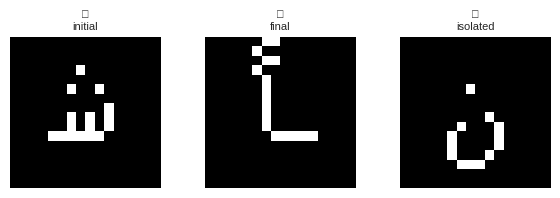

✅ Collation successful!

Collated batch analysis:
Content shape: torch.Size([2, 3, 16, 16])
Target shape: torch.Size([2, 3])
Target lengths: tensor([3, 3], dtype=torch.int32)

First sample analysis:
Target indices: [16, 1, 28]
Target length: 3
Original text: 'شأن'

COMPARING OLD vs NEW MAPPING FOR: 'عقل'
OLD (Simple) Mapping:
  'ع' -> 21
  'ق' -> 24
  'ل' -> 26
Old indices: [21, 24, 26]
Max old index: 26

NEW (Contextual) Mapping:
  'ع' -> 21 (Form: initial)
  'ق' -> 24 (Form: medial)
  'ل' -> 26 (Form: final)
New indices: [21, 24, 26]
Max new index: 26

COMPARISON:
Old max index: 26 (simple alphabet position)
New max index: 26 (contextual Arabic glyph)
Difference: 0

🎉 All tests completed!

You can also run specific functions:
  tester.index_to_char(index)  - Look up what character is at an index
  tester.char_to_all_indices(char)  - Get all indices for a character

SAMPLE USAGE DEMONSTRATION

Sample index_to_char calls:
  tester.index_to_char(0) = ["'ء' (simple)"]
  tester.index_to_c

In [9]:
#!/usr/bin/env python3

"""
Comprehensive test script to debug Arabic content pipeline and dataset collation
"""

import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle
from data_loader.loader_ara import IAMDataset, ContentData, shape_arabic_text
from parse_config import cfg, cfg_from_file, assert_and_infer_cfg

class ContentPipelineTester:
    def __init__(self):
        print("Initializing Content Pipeline Tester...")
        
        # Load config
        cfg_from_file('configs/IAM64_scratch.yml')
        assert_and_infer_cfg()
        
        # Create dataset and content data
        self.dataset = IAMDataset(
            cfg.DATA_LOADER.IAMGE_PATH, 
            cfg.DATA_LOADER.STYLE_PATH, 
            cfg.DATA_LOADER.LAPLACE_PATH, 
            cfg.TRAIN.TYPE
        )
        
        self.content_data = ContentData('unifont')
        print(f"✅ Initialized with {len(self.dataset)} samples")
        
        # Load the raw pickle data for comparison
        with open("data/unifont.pickle", "rb") as f:
            self.pickle_data = pickle.load(f)
    
    def test_index_mapping(self):
        """Test what's at specific indices and verify consistency"""
        print("\n" + "="*80)
        print("TESTING INDEX MAPPING AND CONSISTENCY")
        print("="*80)
        
        # 1. Check basic indices
        print("\n1. BASIC INDEX INVESTIGATION:")
        print("-" * 40)
        
        # Check what's at index 0, 1, 2, etc.
        test_indices = [0, 1, 2, 5, 6, 10, 27, 28, 29, 100, 200, 500, 800, 1000]
        
        print("Dataset letter2index reverse lookup:")
        dataset_idx_to_char = {}
        for char, mapping in self.dataset.letter2index.items():
            if isinstance(mapping, dict):
                # Complex mapping - check all forms
                for form, form_data in mapping.items():
                    if isinstance(form_data, dict) and 'base' in form_data:
                        idx = form_data['base']
                        if idx not in dataset_idx_to_char:
                            dataset_idx_to_char[idx] = []
                        dataset_idx_to_char[idx].append(f"'{char}' ({form})")
            else:
                # Simple mapping
                if mapping not in dataset_idx_to_char:
                    dataset_idx_to_char[mapping] = []
                dataset_idx_to_char[mapping].append(f"'{char}' (simple)")
        
        for idx in test_indices:
            if idx < len(self.dataset.con_symbols):
                tensor_info = f"tensor_shape={self.dataset.con_symbols[idx].shape}, non_zero={torch.count_nonzero(self.dataset.con_symbols[idx])}"
                char_info = dataset_idx_to_char.get(idx, ["UNMAPPED"])
                print(f"  Index {idx:4d}: {char_info} | {tensor_info}")
            else:
                print(f"  Index {idx:4d}: OUT OF RANGE (max={len(self.dataset.con_symbols)-1})")
        
        # 2. Check first and last valid indices
        print(f"\n2. RANGE INFORMATION:")
        print("-" * 40)
        print(f"Dataset con_symbols shape: {self.dataset.con_symbols.shape}")
        print(f"ContentData con_symbols shape: {self.content_data.con_symbols.shape}")
        print(f"Max index in dataset letter2index: {self.get_max_index(self.dataset.letter2index)}")
        print(f"Max index in contentdata letter2index: {self.get_max_index(self.content_data.letter2index)}")
        
        # 3. Check consistency between dataset and content_data
        print(f"\n3. CONSISTENCY CHECK:")
        print("-" * 40)
        
        # Test a few characters
        test_chars = ['ا', 'ب', 'م', 'ر', 'ل']
        for char in test_chars:
            print(f"\nTesting character '{char}':")
            
            # Dataset mapping
            if char in self.dataset.letter2index:
                dataset_mapping = self.dataset.letter2index[char]
                print(f"  Dataset: {dataset_mapping}")
            else:
                print(f"  Dataset: NOT FOUND")
                
            # ContentData mapping  
            if char in self.content_data.letter2index:
                content_mapping = self.content_data.letter2index[char]
                print(f"  ContentData: {content_mapping}")
            else:
                print(f"  ContentData: NOT FOUND")
                
            # Check if they match
            if char in self.dataset.letter2index and char in self.content_data.letter2index:
                if self.dataset.letter2index[char] == self.content_data.letter2index[char]:
                    print(f"  ✅ MATCH")
                else:
                    print(f"  ❌ MISMATCH")
        
        # 4. Check pickle data structure
        print(f"\n4. PICKLE DATA STRUCTURE:")
        print("-" * 40)

        if isinstance(self.pickle_data, dict):
            # Old extended layout  ➜ dict with ‘with_harakat’ etc.
            print(f"Top-level keys: {list(self.pickle_data.keys())}")
            if 'with_harakat' in self.pickle_data:
                harakat_data = self.pickle_data['with_harakat']
                print(f"with_harakat keys: {list(harakat_data.keys())}")
                glyph_entries = harakat_data.get('glyph_entries', [])
                print(f"Number of glyph entries: {len(glyph_entries)}")
                for i, entry in enumerate(glyph_entries[:5]):
                    print(f"  Entry {i}: idx={entry.get('idx')}  char={entry.get('char')}  form={entry.get('form')}")
        else:
            # Current simple layout  ➜ list of entry dicts
            print(f"Pickle is a list with {len(self.pickle_data)} glyph entries")
            print("First few entries:")
            for i, entry in enumerate(self.pickle_data[:5]):
                cp     = entry.get('idx')[0] if isinstance(entry.get('idx'), (list, tuple)) else entry.get('idx')
                char   = chr(cp)
                print(f"  Entry {i}: idx={cp} ('{char}')  shape={entry['mat'].shape}")                        
    
    def get_max_index(self, letter2index):
        """Get the maximum index from a letter2index mapping"""
        max_idx = 0
        for char, mapping in letter2index.items():
            if isinstance(mapping, dict):
                for form, form_data in mapping.items():
                    if isinstance(form_data, dict) and 'base' in form_data:
                        max_idx = max(max_idx, form_data['base'])
            else:
                max_idx = max(max_idx, mapping)
        return max_idx
    
    def index_to_char(self, index, use_dataset=True):
        """
        Given an index, return what character(s) it maps to
        
        Args:
            index: The index to look up
            use_dataset: If True, use dataset.letter2index, else use content_data.letter2index
            
        Returns:
            List of strings describing what maps to this index
        """
        letter2index = self.dataset.letter2index if use_dataset else self.content_data.letter2index
        
        results = []
        
        for char, mapping in letter2index.items():
            if isinstance(mapping, dict):
                # Complex mapping - check all forms
                for form, form_data in mapping.items():
                    if isinstance(form_data, dict) and 'base' in form_data:
                        if form_data['base'] == index:
                            results.append(f"'{char}' ({form})")
            else:
                # Simple mapping
                if mapping == index:
                    results.append(f"'{char}' (simple)")
        
        return results if results else ["UNMAPPED"]
    
    def test_index_lookup(self, indices_to_test=None):
        """
        Test the index-to-character lookup function
        """
        if indices_to_test is None:
            indices_to_test = [0, 1, 2, 5, 6, 10, 27, 28, 29, 39, 167, 199, 423, 871, 1000, 1200]
        
        print("\n" + "="*80)
        print("TESTING INDEX-TO-CHARACTER LOOKUP")
        print("="*80)
        
        print("\nDataset Index Lookup:")
        print("-" * 30)
        for idx in indices_to_test:
            chars = self.index_to_char(idx, use_dataset=True)
            if idx < len(self.dataset.con_symbols):
                non_zero = torch.count_nonzero(self.dataset.con_symbols[idx])
                print(f"Index {idx:4d}: {chars} | Non-zero pixels: {non_zero}")
            else:
                print(f"Index {idx:4d}: {chars} | OUT OF RANGE")
        
        print("\nContentData Index Lookup:")
        print("-" * 30)
        for idx in indices_to_test:
            chars = self.index_to_char(idx, use_dataset=False)
            if idx < len(self.content_data.con_symbols):
                non_zero = torch.count_nonzero(self.content_data.con_symbols[idx])
                print(f"Index {idx:4d}: {chars} | Non-zero pixels: {non_zero}")
            else:
                print(f"Index {idx:4d}: {chars} | OUT OF RANGE")
    
    def char_to_all_indices(self, char, use_dataset=True):
        """
        Given a character, return all indices it maps to (all forms)
        
        Args:
            char: The character to look up
            use_dataset: If True, use dataset.letter2index, else use content_data.letter2index
            
        Returns:
            Dictionary with form -> index mapping
        """
        letter2index = self.dataset.letter2index if use_dataset else self.content_data.letter2index
        
        if char not in letter2index:
            return {}
        
        mapping = letter2index[char]
        
        if isinstance(mapping, dict):
            # Complex mapping - return all forms
            result = {}
            for form, form_data in mapping.items():
                if isinstance(form_data, dict) and 'base' in form_data:
                    result[form] = form_data['base']
            return result
        else:
            # Simple mapping
            return {'simple': mapping}
    
    def test_character_to_indices(self, chars_to_test=None):
        """
        Test character-to-indices lookup
        """
        if chars_to_test is None:
            chars_to_test = ['ا', 'ب', 'م', 'ر', 'ل', 'ع', 'ق', '0', '1', ' ']
        
        print("\n" + "="*80)
        print("TESTING CHARACTER-TO-INDICES LOOKUP")
        print("="*80)
        
        for char in chars_to_test:
            print(f"\nCharacter '{char}':")
            
            # Dataset lookup
            dataset_indices = self.char_to_all_indices(char, use_dataset=True)
            content_indices = self.char_to_all_indices(char, use_dataset=False)
            
            print(f"  Dataset indices: {dataset_indices}")
            print(f"  ContentData indices: {content_indices}")
            
            # Check if they match
            if dataset_indices == content_indices:
                print(f"  ✅ MATCH")
            else:
                print(f"  ❌ MISMATCH")
                
            # Show which indices have actual glyphs
            all_indices = set()
            all_indices.update(dataset_indices.values())
            all_indices.update(content_indices.values())
            
            for idx in sorted(all_indices):
                if idx < len(self.dataset.con_symbols):
                    nz = torch.count_nonzero(self.dataset.con_symbols[idx])
                    print(f"    Index {idx}: {nz} non-zero pixels")
    
    def test_shape_function_indices(self):
        """Test what indices the shape function actually produces"""
        print("\n" + "="*80)
        print("TESTING SHAPE FUNCTION INDEX PRODUCTION")
        print("="*80)
        
        test_texts = ["ا", "ب", "مرحبا", "السلام"]
        
        for text in test_texts:
            print(f"\nTesting text: '{text}'")
            print("-" * 30)
            
            try:
                # Test with dataset letter2index
                indices, forms = shape_arabic_text(text, self.dataset.letter2index)
                print(f"Dataset indices: {indices}")
                print(f"Forms: {forms}")
                
                # Test with content_data letter2index
                content_indices, content_forms = shape_arabic_text(text, self.content_data.letter2index)
                print(f"ContentData indices: {content_indices}")
                print(f"ContentData forms: {content_forms}")
                
                # Check if they match
                if indices == content_indices:
                    print("✅ Dataset and ContentData produce SAME indices")
                else:
                    print("❌ Dataset and ContentData produce DIFFERENT indices")
                    
                # Verify indices are valid for tensor access
                max_dataset_idx = max(indices) if indices else 0
                max_content_idx = max(content_indices) if content_indices else 0
                
                print(f"Max dataset index: {max_dataset_idx} (tensor size: {len(self.dataset.con_symbols)})")
                print(f"Max content index: {max_content_idx} (tensor size: {len(self.content_data.con_symbols)})")
                
                if max_dataset_idx < len(self.dataset.con_symbols):
                    print("✅ Dataset indices are VALID")
                else:
                    print("❌ Dataset indices are OUT OF RANGE")
                    
                if max_content_idx < len(self.content_data.con_symbols):
                    print("✅ ContentData indices are VALID")
                else:
                    print("❌ ContentData indices are OUT OF RANGE")
                    
            except Exception as e:
                print(f"❌ Error testing '{text}': {e}")
    
    def visualize_index_glyphs(self, indices_to_show=[0, 1, 2, 5, 39, 167, 199, 423, 871]):
        """Visualize what glyphs look like at specific indices"""
        print(f"\n" + "="*80)
        print("VISUALIZING GLYPHS AT SPECIFIC INDICES")
        print("="*80)
        
        valid_indices = [idx for idx in indices_to_show if idx < len(self.dataset.con_symbols)]
        
        if not valid_indices:
            print("No valid indices to visualize")
            return
            
        fig, axes = plt.subplots(1, len(valid_indices), figsize=(len(valid_indices) * 2, 3))
        
        if len(valid_indices) == 1:
            axes = [axes]
        
        for i, idx in enumerate(valid_indices):
            glyph = self.dataset.con_symbols[idx]
            axes[i].imshow(glyph.numpy(), cmap='gray')
            
            # Find what character this index represents
            char_info = "Unknown"
            for char, mapping in self.dataset.letter2index.items():
                if isinstance(mapping, dict):
                    for form, form_data in mapping.items():
                        if isinstance(form_data, dict) and 'base' in form_data:
                            if form_data['base'] == idx:
                                char_info = f"'{char}' ({form})"
                                break
                else:
                    if mapping == idx:
                        char_info = f"'{char}' (simple)"
                        break
            
            axes[i].set_title(f"Index {idx}\n{char_info}\nNZ: {torch.count_nonzero(glyph)}")
            axes[i].axis('off')
        
        plt.suptitle("Glyphs at Different Indices")
        plt.tight_layout()
        plt.show()

    def test_letter2index_structure(self):
        """Test the letter2index structure"""
        print("\n" + "="*60)
        print("TESTING LETTER2INDEX STRUCTURE")
        print("="*60)
        
        # Check dataset letter2index
        print(f"Dataset letter2index type: {type(self.dataset.letter2index)}")
        print(f"Dataset letter2index keys (first 10): {list(self.dataset.letter2index.keys())[:10]}")
        
        # Check a few Arabic characters
        test_chars = ['ا', 'ب', 'ت', 'م', 'ر', 'ح', 'ل']
        for char in test_chars:
            if char in self.dataset.letter2index:
                mapping = self.dataset.letter2index[char]
                if isinstance(mapping, dict):
                    print(f"'{char}': Complex mapping with forms: {list(mapping.keys())}")
                    if 'isolated' in mapping:
                        print(f"  isolated base: {mapping['isolated']['base']}")
                else:
                    print(f"'{char}': Simple mapping -> {mapping}")
        
        # Check non-Arabic characters
        for char in ['0', '1', ' ']:
            if char in self.dataset.letter2index:
                print(f"'{char}': {self.dataset.letter2index[char]}")
    
    def test_content_pipeline(self, text="مرحبا"):
        """Test the complete content pipeline"""
        print("\n" + "="*60)
        print(f"TESTING CONTENT PIPELINE WITH: '{text}'")
        print("="*60)
        
        print(f"Input text: '{text}' (length: {len(text)})")
        
        # Test shape_arabic_text function
        print("\n1. Testing shape_arabic_text function:")
        try:
            indices, forms = shape_arabic_text(text, self.dataset.letter2index)
            print(f"✅ Shaping successful!")
            print(f"Indices: {indices}")
            print(f"Forms: {forms}")
            print(f"Length: {len(indices)}")
            
            # Character-by-character breakdown
            print("\nCharacter breakdown:")
            for i, char in enumerate(text):
                if i < len(indices):
                    print(f"  '{char}' -> Index: {indices[i]}, Form: {forms[i]}")
                    
        except Exception as e:
            print(f"❌ Shaping failed: {e}")
            import traceback
            traceback.print_exc()
            return None
        
        # Test ContentData.get_content
        print("\n2. Testing ContentData.get_content:")
        try:
            content_tensor = self.content_data.get_content(text)
            print(f"✅ Content tensor created!")
            print(f"Content tensor shape: {content_tensor.shape}")
            print(f"Non-zero pixels: {torch.count_nonzero(content_tensor)}")
            
        except Exception as e:
            print(f"❌ Content tensor creation failed: {e}")
            import traceback
            traceback.print_exc()
            return None
            
        # Visualize glyphs
        self.visualize_glyphs(text, content_tensor, indices, forms)
        
        return content_tensor, indices, forms
    
    def test_dataset_collation(self, num_samples=3):
        """Test dataset collation with debugging"""
        print("\n" + "="*60)
        print(f"TESTING DATASET COLLATION WITH {num_samples} SAMPLES")
        print("="*60)
        
        # Get sample items
        batch = []
        for i in range(min(num_samples, len(self.dataset))):
            item = self.dataset[i]
            print(f"\nSample {i}: '{item['content']}' (len={len(item['content'])})")
            batch.append(item)
        
        # Test collation
        try:
            print("\nCollating batch...")
            collated = self.dataset.collate_fn_(batch)
            print(f"✅ Collation successful!")
            
            # Analyze collated results
            print(f"\nCollated batch analysis:")
            print(f"Content shape: {collated['content'].shape}")
            print(f"Target shape: {collated['target'].shape}")
            print(f"Target lengths: {collated['target_lengths']}")
            
            # Check first sample in detail
            print(f"\nFirst sample analysis:")
            first_target_len = collated['target_lengths'][0].item()
            first_target = collated['target'][0, :first_target_len]
            print(f"Target indices: {first_target.tolist()}")
            print(f"Target length: {first_target_len}")
            print(f"Original text: '{batch[0]['content']}'")
            
            return collated
            
        except Exception as e:
            print(f"❌ Collation failed: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def compare_old_vs_new_mapping(self, text="مرحبا"):
        """Compare old simple mapping vs new contextual mapping"""
        print("\n" + "="*60)
        print(f"COMPARING OLD vs NEW MAPPING FOR: '{text}'")
        print("="*60)
        
        # Simulate old mapping (simple character-to-index)
        simple_letter2index = {label: n for n, label in enumerate(self.dataset.letters)}
        
        print("OLD (Simple) Mapping:")
        old_indices = []
        for i, char in enumerate(text):
            if char in simple_letter2index:
                idx = simple_letter2index[char]
                old_indices.append(idx)
                print(f"  '{char}' -> {idx}")
            else:
                print(f"  '{char}' -> NOT FOUND")
        
        print(f"Old indices: {old_indices}")
        print(f"Max old index: {max(old_indices) if old_indices else 0}")
        
        # New mapping (contextual)
        print("\nNEW (Contextual) Mapping:")
        try:
            new_indices, forms = shape_arabic_text(text, self.dataset.letter2index)
            for i, char in enumerate(text):
                if i < len(new_indices):
                    print(f"  '{char}' -> {new_indices[i]} (Form: {forms[i]})")
            
            print(f"New indices: {new_indices}")
            print(f"Max new index: {max(new_indices) if new_indices else 0}")
            
            # Compare
            print(f"\nCOMPARISON:")
            print(f"Old max index: {max(old_indices) if old_indices else 0} (simple alphabet position)")
            print(f"New max index: {max(new_indices) if new_indices else 0} (contextual Arabic glyph)")
            print(f"Difference: {max(new_indices) - max(old_indices) if old_indices and new_indices else 'N/A'}")
            
        except Exception as e:
            print(f"❌ New mapping failed: {e}")
    
    def visualize_glyphs(self, text, content_tensor, indices, forms):
        """Visualize the glyphs"""
        try:
            L = content_tensor.shape[1]
            fig, axes = plt.subplots(1, L, figsize=(L * 2, 3))
            
            if L == 1:
                axes = [axes]
            
            for i in range(L):
                axes[i].imshow(content_tensor[0, i].numpy(), cmap='gray')
                axes[i].set_title(f"'{text[i]}'\nIdx: {indices[i]}\n{forms[i]}", fontsize=10)
                axes[i].axis('off')
            
            plt.suptitle(f"Arabic Glyphs for: '{text}'", fontsize=14)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"❌ Visualization failed: {e}")

def main():
    """Main test function"""
    print("🚀 Starting Arabic Content Pipeline Debug Test")
    print("="*80)
    
    try:
        # Initialize tester
        tester = ContentPipelineTester()
        
        # Test 1: Check letter2index structure
        tester.test_letter2index_structure()
        
        # Test 2: Deep index mapping investigation
        tester.test_index_mapping()
        
        # Test 3: Test index-to-character lookup
        tester.test_index_lookup()
        
        # Test 4: Test character-to-indices lookup
        tester.test_character_to_indices()
        
        # Test 5: Test shape function indices
        tester.test_shape_function_indices()
        
        # Test 6: Visualize some key indices
        tester.visualize_index_glyphs([0, 1, 2, 39, 167, 199, 423, 871])
        
        # Test 7: Test content pipeline with different texts
        test_texts = ["مرحبا", "عقل"]
        
        for text in test_texts:
            result = tester.test_content_pipeline(text)
            if result is None:
                print(f"❌ Failed to process '{text}'")
                continue
                
        # Test 8: Test dataset collation
        tester.test_dataset_collation(2)
        
        # Test 9: Compare old vs new mapping
        tester.compare_old_vs_new_mapping("عقل")
        
        print("\n" + "="*80)
        print("🎉 All tests completed!")
        print("\nYou can also run specific functions:")
        print("  tester.index_to_char(index)  - Look up what character is at an index")
        print("  tester.char_to_all_indices(char)  - Get all indices for a character")
        
        # Sample usage demonstration
        print("\n" + "="*80)
        print("SAMPLE USAGE DEMONSTRATION")
        print("="*80)
        
        # Sample calls to index_to_char
        sample_indices = [0, 1, 2, 39, 167, 871]
        print("\nSample index_to_char calls:")
        for idx in sample_indices:
            result = tester.index_to_char(idx)
            print(f"  tester.index_to_char({idx}) = {result}")
        
        # Sample calls to char_to_all_indices
        sample_chars = ['ا', 'ب', 'م']
        print("\nSample char_to_all_indices calls:")
        for char in sample_chars:
            result = tester.char_to_all_indices(char)
            print(f"  tester.char_to_all_indices('{char}') = {result}")
        
    except Exception as e:
        print(f"💥 Test suite failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main() 

## The current (old/ not updated) loader -- look at indicies 

## 3. Style Pipeline Testing

Now let's examine how style references are processed.

In [10]:
import torch.nn.functional as F

## Simple Version

Dataset split   : train
Sample index    : 3083
Writer ID       : alexuw-646
Image filename  : 646-14.jpg
Label (content) : فصل

Tensor shapes
  img     : (3, 64, 128)
  style   : (2, 64, 192)
  laplace : (2, 64, 192)


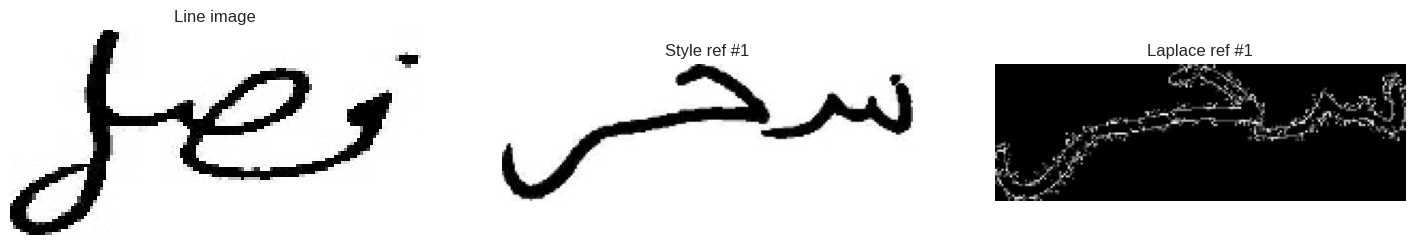

In [11]:
import os, numpy as np, torch, matplotlib.pyplot as plt
from data_loader.loader_ara import IAMDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_IAM_dataset(split="train", idx=None):
    """
    Visual / shape check for a single IAMDataset sample.

    Parameters
    ----------
    split : {"train", "val", "test"}
    idx   : int or None
        • None  -> choose a random index
        • int   -> use that specific sample
    """
    ds = IAMDataset(
        image_path   = cfg.DATA_LOADER.IAMGE_PATH,   # path that contains /train /val /test
        style_path   = cfg.DATA_LOADER.STYLE_PATH,
        laplace_path = cfg.DATA_LOADER.LAPLACE_PATH,
        type         = split                       # same arg name as in English repo
    )

    if idx is None:
        idx = np.random.randint(len(ds))

    sample = ds[idx]   # dict with keys: img, content, style, laplace, …

    img      = sample["img"]      # [3, H, W], torch.float32
    style    = sample["style"]    # [2, 64, W]
    laplace  = sample["laplace"]  # [2, 64, W]
    label    = sample["content"]  # string
    writer   = sample["wid"]
    img_name = sample["image_name"]

    # ── move tensors to CPU numpy for plotting ────────────────────────────
    img_np     = (img * 0.5 + 0.5).cpu().numpy().transpose(1, 2, 0)  # de-normalise
    style_np   = style[0].cpu().numpy()     # first reference
    laplace_np = laplace[0].cpu().numpy()   # first reference

    # ── show ──────────────────────────────────────────────────────────────
    print(f"Dataset split   : {split}")
    print(f"Sample index    : {idx}")
    print(f"Writer ID       : {writer}")
    print(f"Image filename  : {img_name}")
    print(f"Label (content) : {label}")
    print("\nTensor shapes")
    print(f"  img     : {tuple(img.shape)}")
    print(f"  style   : {tuple(style.shape)}")
    print(f"  laplace : {tuple(laplace.shape)}")

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 5))
    ax0.imshow(img_np);       ax0.set_title("Line image");   ax0.axis("off")
    ax1.imshow(style_np,   cmap="gray"); ax1.set_title("Style ref #1");   ax1.axis("off")
    ax2.imshow(laplace_np, cmap="gray"); ax2.set_title("Laplace ref #1"); ax2.axis("off")
    plt.show()

    # return the sample in case the caller wants to inspect it
    return sample


# quick demo
_ = test_IAM_dataset(split="train")

img – “line image” is the The full RGB scan of the handwriting line that matches the transcription. AND Used only during TRAINING as the reconstruction target.

style / laplace – writer reference --> Fed to the style encoder so the model knows “how this writer draws strokes”.


content – transcription string --> Converted to 16 × 16 Unifont glyphs inside the loader (get_content) to provide the “what to write” signal.

Testing style pipeline with writer ID: 114-10.jpg


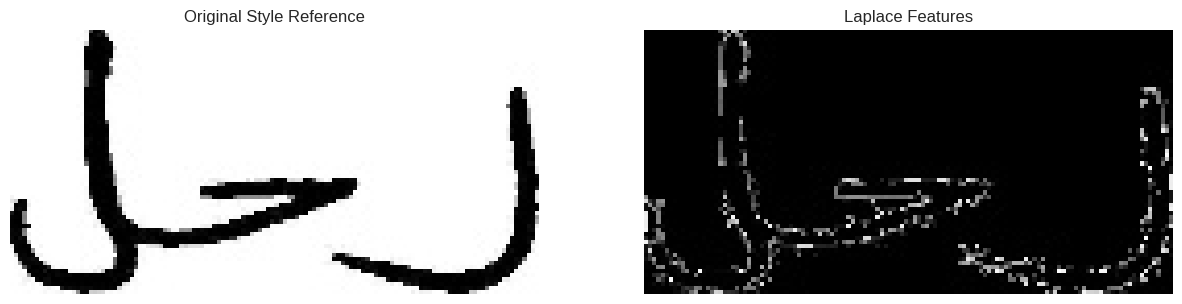


Style tensor shape: torch.Size([1, 64, 128])
Laplace tensor shape: torch.Size([1, 64, 128])
Value ranges: [0.000, 1.000]


In [12]:
def test_style_pipeline(writer_id=None, random=True):
    # Initialize dataset
    style_dataset = Random_StyleIAMDataset(
        style_path=os.path.join(cfg.DATA_LOADER.STYLE_PATH, 'train'),
        laplace_path=os.path.join(cfg.DATA_LOADER.LAPLACE_PATH, 'train'),
        ref_num=1
    )
    
    # Choose writer ID
    if writer_id is None:
        if random:
            writer_id = np.random.choice(style_dataset.author_id)
        else:
            writer_id = style_dataset.author_id[0]
    elif writer_id not in style_dataset.author_id:
        raise ValueError(f"Writer ID {writer_id} not found in dataset")
    
    print(f"Testing style pipeline with writer ID: {writer_id}")
    
    # Load style and laplace images
    style_img, laplace_img = style_dataset.get_style_ref(writer_id)
    
    # Display images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.imshow(style_img, cmap='gray')
    ax1.set_title("Original Style Reference")
    ax1.axis('off')
    
    ax2.imshow(laplace_img, cmap='gray')
    ax2.set_title("Laplace Features")
    ax2.axis('off')
    plt.show()
    
    # Convert to tensors
    style_tensor = torch.from_numpy(style_img).unsqueeze(0).to(device)
    laplace_tensor = torch.from_numpy(laplace_img).unsqueeze(0).to(device)
    
    print(f"\nStyle tensor shape: {style_tensor.shape}")
    print(f"Laplace tensor shape: {laplace_tensor.shape}")
    print(f"Value ranges: [{style_tensor.min():.3f}, {style_tensor.max():.3f}]")
    
    return style_tensor, laplace_tensor

# Test style pipeline
style_tensor, laplace_tensor = test_style_pipeline()

## 4. Fusion Mechanism Testing

Let's examine how style and content information are fused.

In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import os

In [9]:
# ───────────────────────────────────────────────────────────────
# 1.  Initialise full model wrapper (unet + content_data inside)
# ───────────────────────────────────────────────────────────────
model = OneDMTester(
    checkpoint_path = "../Downloads/Saved/IAM64_finetune/Arabic_NEW_1000-20250715_022358/model/3999-ckpt.pt",
    device          = device
)

get_content = model.content_data.get_content   # shortcut
mix_net     = model.unet.mix_net               # fusion module

# load YAML config (needed for STYLE/LAPLACE root paths)
cfg_from_file('configs/IAM64_scratch.yml')
assert_and_infer_cfg()


Loaded checkpoint from ../Downloads/Saved/IAM64_finetune/Arabic_NEW_1000-20250715_022358/model/3999-ckpt.pt



Tensor information:
Content tensor : (1, 5, 16, 16)  torch.float32
Style tensor   : (1, 1, 64, 128)   torch.float32
Laplace tensor : (1, 1, 64, 128) torch.float32

Testing fusion for writer 577-23.jpg

Model weight dtype: torch.float32
Input dtypes      : torch.float32 torch.float32 torch.float32
Content: torch.float32
Style: torch.float32
Laplace: torch.float32

Fused features shape: torch.Size([1, 5, 512])
Style features shape: torch.Size([32, 1, 512])


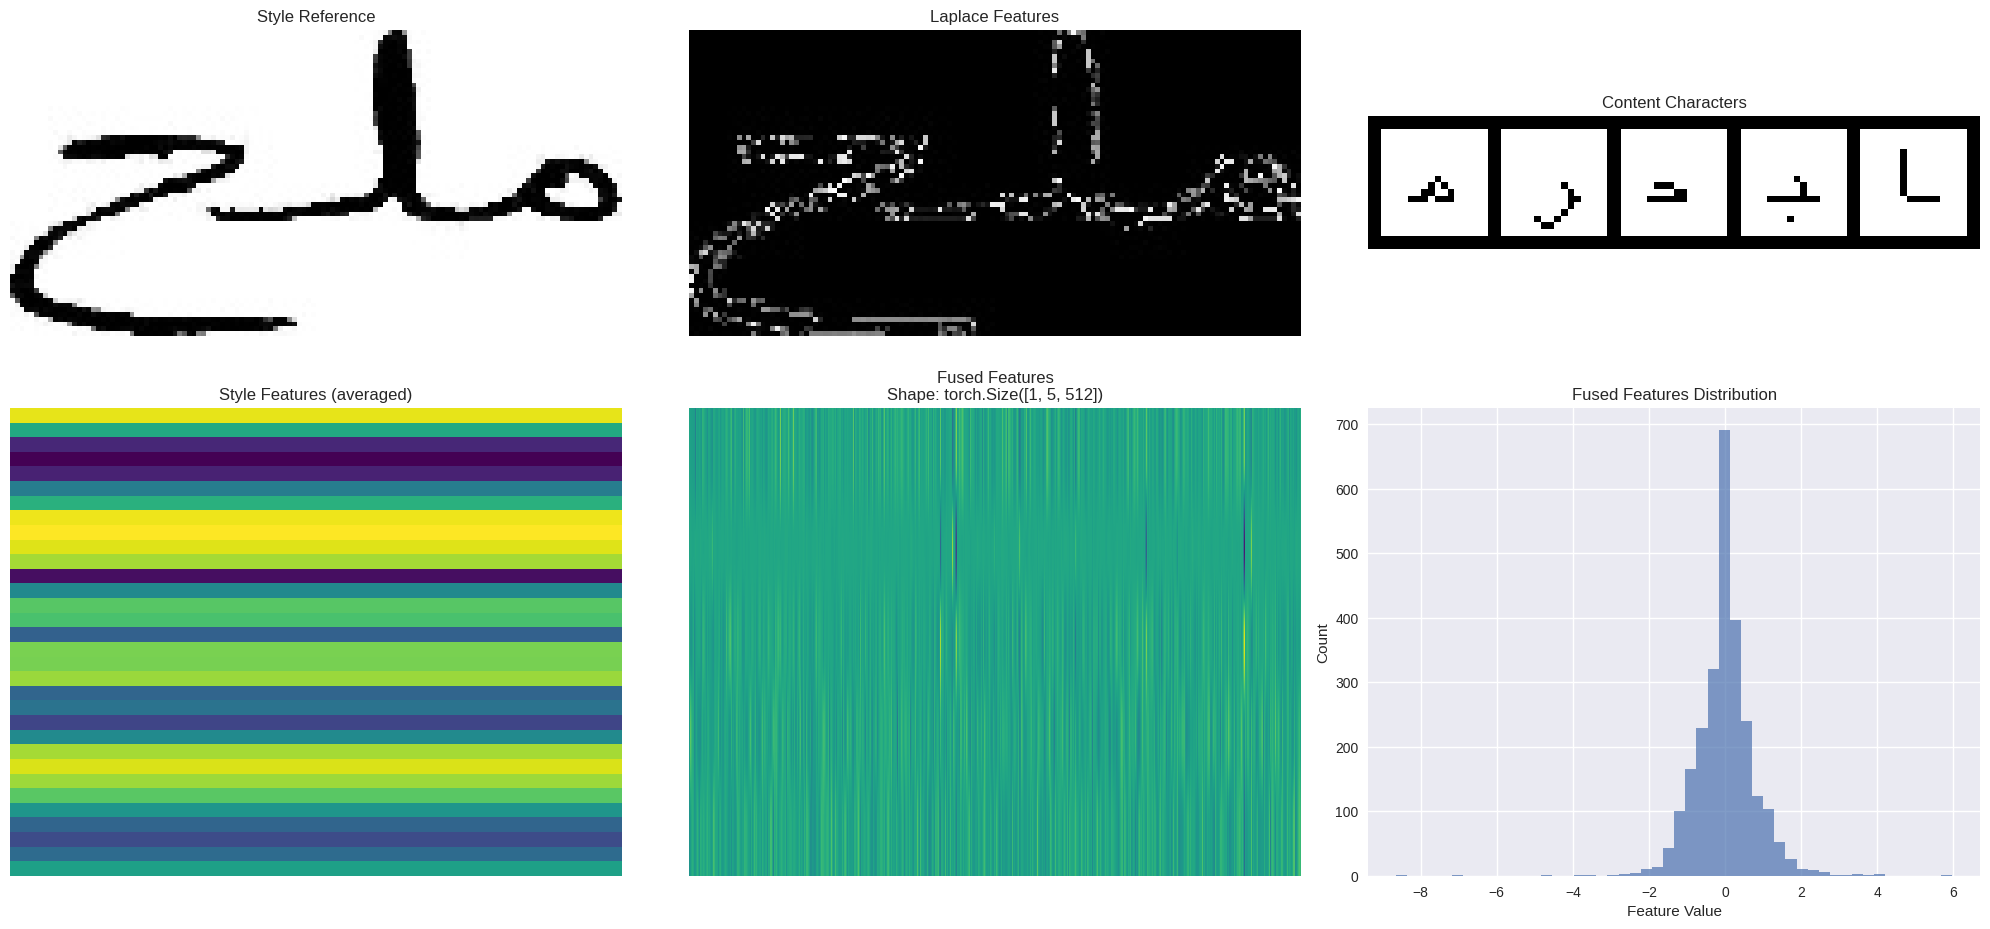


Feature Statistics:
Fused Features - Mean: -0.001, Std: 0.783
Style Features - Mean: -0.001, Std: 1.069


In [15]:
import os, random, numpy as np, torch, matplotlib.pyplot as plt
from torchvision.utils import make_grid
from parse_config import cfg, cfg_from_file, assert_and_infer_cfg

from data_loader.loader_ara import Random_StyleIAMDataset          # style helper
# from your_module_path import OneDMTester                               # full wrapper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




# ------------------------------------------------------------
def prepare_tensors_for_fusion(text="hello", writer_id=None):
    """Prepare tensors with contextual glyphs + style/laplace for fusion."""
    # 1. CONTENT  (use ContentData that lives inside the wrapper)
    content_tensor = tester.get_content(text)         # [1,L,16,16]

    # 2. STYLE / LAPLACE  (one random reference)
#     style_dataset = Random_StyleIAMDataset(
#         style_path   = cfg.DATA_LOADER.STYLE_PATH,                 # root, no “train/”
#         laplace_path = cfg.DATA_LOADER.LAPLACE_PATH,
#         ref_num      = 1
#     )
    
    style_dataset = Random_StyleIAMDataset(
    style_path   = os.path.join(cfg.DATA_LOADER.STYLE_PATH,   'train'),
    laplace_path = os.path.join(cfg.DATA_LOADER.LAPLACE_PATH, 'train'),
    ref_num      = 1
)
    writer_id = writer_id or np.random.choice(style_dataset.author_id)
    style_img, laplace_img = style_dataset.get_style_ref(writer_id)

    # 3. Convert to tensors, add batch+channel dims
    style_tensor   = torch.from_numpy(style_img   ).float().unsqueeze(0).unsqueeze(0).to(device)
    laplace_tensor = torch.from_numpy(laplace_img ).float().unsqueeze(0).unsqueeze(0).to(device)
    content_tensor = content_tensor.float().to(device)
    
    # Debug
    print("\nTensor information:")
    print(f"Content tensor : {tuple(content_tensor.shape)}  {content_tensor.dtype}")
    print(f"Style tensor   : {tuple(style_tensor.shape)}   {style_tensor.dtype}")
    print(f"Laplace tensor : {tuple(laplace_tensor.shape)} {laplace_tensor.dtype}")

    return content_tensor, style_tensor, laplace_tensor, writer_id

def test_fusion_mechanism(content_tensor, style_tensor, laplace_tensor):
    """Run UNet.mix_net.generate and visualise the result."""
#     mix_net = tester.unet.mix_net 
    mix_net     = model.unet.mix_net      # ← now finds the module

    print("\nModel weight dtype:", next(mix_net.parameters()).dtype)
    print("Input dtypes      :", content_tensor.dtype, style_tensor.dtype, laplace_tensor.dtype)
    
    print(f"Content: {content_tensor.dtype}")
    print(f"Style: {style_tensor.dtype}")
    print(f"Laplace: {laplace_tensor.dtype}")
    
    # Generate fused features
    with torch.no_grad():
        try:
            fused_features = mix_net.generate(
                style_tensor,
                laplace_tensor,
                content_tensor
            )
            print(f"\nFused features shape: {fused_features.shape}")
            
            # Get style features
            style_features = mix_net.get_low_style_feature(style_tensor)
            
            
            
            print(f"Style features shape: {style_features.shape}")
            
            # Create visualization figure
            fig = plt.figure(figsize=(20, 10))
            
            # 1. Input Visualization
            plt.subplot(2, 3, 1)
            plt.imshow(style_tensor[0, 0].cpu().numpy(), cmap='gray')
            plt.title("Style Reference")
            plt.axis('off')
            
            plt.subplot(2, 3, 2)
            plt.imshow(laplace_tensor[0, 0].cpu().numpy(), cmap='gray')
            plt.title("Laplace Features")
            plt.axis('off')
            
            # Visualize content tensor (all characters)
            plt.subplot(2, 3, 3)
            content_vis = make_grid(
                content_tensor[0].unsqueeze(1),
                nrow=content_tensor.shape[1],
                padding=2,
                normalize=True
            )
            plt.imshow(content_vis.cpu().permute(1, 2, 0).numpy(), cmap='gray')
            plt.title("Content Characters")
            plt.axis('off')
            
            # 2. Feature Visualization
            plt.subplot(2, 3, 4)
            # Visualize style features (mean across feature dimension)
            style_feat_vis = style_features.mean(dim=-1).cpu().numpy()
            plt.imshow(style_feat_vis, cmap='viridis', aspect='auto')
            plt.title("Style Features (averaged)")
            plt.axis('off')
            
            plt.subplot(2, 3, 5)
            # Visualize fused features for each character
            fused_feat_vis = fused_features[0].cpu().numpy()
            plt.imshow(fused_feat_vis, cmap='viridis', aspect='auto')
            plt.title(f"Fused Features\nShape: {fused_features.shape}")
            plt.axis('off')
            
            # 3. Feature Statistics
            plt.subplot(2, 3, 6)
            plt.hist(fused_features.cpu().numpy().flatten(), bins=50, alpha=0.7)
            plt.title("Fused Features Distribution")
            plt.xlabel("Feature Value")
            plt.ylabel("Count")
            
            plt.tight_layout()
            plt.show()
            
            # Print feature statistics
            print("\nFeature Statistics:")
            print(f"Fused Features - Mean: {fused_features.mean():.3f}, Std: {fused_features.std():.3f}")
            print(f"Style Features - Mean: {style_features.mean():.3f}, Std: {style_features.std():.3f}")
            
            return fused_features
            
        except Exception as e:
            print("\nError during fusion:")
            print(e)
            print("\nExpected tensor shapes:")
            print("style_tensor: [batch_size, 1, height, width]")
            print("laplace_tensor: [batch_size, 1, height, width]")
            print("content_tensor: [batch_size, num_chars, 16, 16]")
            return None

if __name__ == "__main__":
    # Test fusion mechanism with sample text
    content_tensor, style_tensor, laplace_tensor, writer_id = prepare_tensors_for_fusion("مرحبا")
    print(f"\nTesting fusion for writer {writer_id}")
    fused_features = test_fusion_mechanism(content_tensor, style_tensor, laplace_tensor)

Writer id = 140-27.jpg


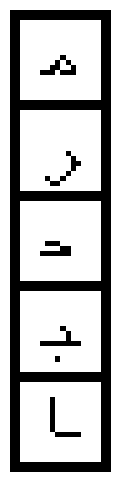

Word       : مرحبا
Codepoints : U+0645  U+0631  U+062D  U+0628  U+0627
Content encoder output shape: torch.Size([5, 1, 512])
Fused feature tensor : torch.Size([1, 5, 512])


In [16]:
"""
Sequence-sanity test for One-DM
• verifies that character order is preserved L→R (English) or logical order (Arabic)
• runs a full forward pass through Mix_TR without size-mismatch errors
"""

import os, numpy as np, torch, matplotlib.pyplot as plt
from einops import rearrange
from torchvision.utils import make_grid

from parse_config import cfg                      # gives cfg.MODEL.EMB_DIM = 512
from data_loader.loader_ara import ContentData, Random_StyleIAMDataset
from models.fusion import Mix_TR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────────────
# 1. prepare content / style / laplace tensors
# ──────────────────────────────────────────────────────────────────────
def prepare_tensors(word="hello", writer_id=None):
    cd   = ContentData()
    cont = cd.get_content(word)                                   # [1, L, 16, 16]

    ds = Random_StyleIAMDataset(
        style_path   = os.path.join(cfg.DATA_LOADER.STYLE_PATH,   "train"),
        laplace_path = os.path.join(cfg.DATA_LOADER.LAPLACE_PATH, "train"),
        ref_num      = 1
    )
    writer_id = writer_id or np.random.choice(ds.author_id)
    s_img, l_img = ds.get_style_ref(writer_id)                    # (64, W)

    style_t   = torch.from_numpy(s_img).unsqueeze(0).unsqueeze(0)  # [1,1,64,W]
    lap_t     = torch.from_numpy(l_img).unsqueeze(0).unsqueeze(0)

    return (cont.float().to(device),
            style_t.float().to(device),
            lap_t.float().to(device),
            writer_id)


# ──────────────────────────────────────────────────────────────────────
# 2. visualise glyph sequence
# ──────────────────────────────────────────────────────────────────────
def show_glyph_sequence(content_t, word):
    """
    Shows glyphs vertically and prints their Unicode code-points
    in the order seen by the model.
    """
    L = content_t.shape[1]

    grid = make_grid(
        content_t[0].unsqueeze(1),   # glyph images
        nrow=1, padding=2, normalize=True
    )

    plt.figure(figsize=(2, L * 1.2))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

    # --- print logical order -------------------------------------------------
    cps = [f"U+{ord(c):04X}" for c in word]
    print("Word       :", word)
    print("Codepoints :", "  ".join(cps))


# ──────────────────────────────────────────────────────────────────────
# 3. pass only the glyphs through the content encoder
# ──────────────────────────────────────────────────────────────────────
def inspect_content_encoder(content_t):
    mix_net = Mix_TR(d_model=cfg.MODEL.EMB_DIM).to(device).eval()   # 512-channel
    with torch.no_grad():
        glyphs = rearrange(content_t, 'n t h w -> (n t) 1 h w')
        feat   = mix_net.content_encoder(glyphs).squeeze(-1).squeeze(-1)
        feat   = rearrange(feat, '(n t) c -> t n c', n=1)           # [L,1,512]
    print(f"Content encoder output shape: {feat.shape}")
    return feat


# ──────────────────────────────────────────────────────────────────────
# 4. full fusion forward-pass
# ──────────────────────────────────────────────────────────────────────
def quick_fusion_test(word="hello"):
    cont, sty, lap, wid = prepare_tensors(word)
    print("Writer id =", wid)

    show_glyph_sequence(cont, word)
    inspect_content_encoder(cont)

    mix_net = Mix_TR(d_model=cfg.MODEL.EMB_DIM).to(device).eval()
    with torch.no_grad():
        fused = mix_net.generate(sty, lap, cont)
    print("Fused feature tensor :", fused.shape)   # [1, L, 512]


# ──────────────────────────────────────────────────────────────────────
# run demo
# ──────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    quick_fusion_test("مرحبا")      # or quick_fusion_test("hello")

The tensor order produced by ContentData.get_content() is the logical order of the characters, i.e.
• position 0 ⇢ first Unicode code-point in the input string
• position L-1 ⇢ last Unicode code-point
That is exactly what the transformer expects, even for Arabic.
The Arabic handwriting line itself will later be rendered RTL by the diffusion / decoder network; there is no reversal step in between.
What confuses the eye is just the Matplotlib preview: a make_grid call always lays images left → right, so an Arabic word looks “backwards” in the figure even though the tensor is correct.

In [17]:
import torch
import torch.nn as nn

class FusionDebugger(nn.Module):
    def __init__(self):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=8,
            batch_first=True
        )
        
    def forward(self, fused_features, style_features):
        # Ensure inputs are float32
        fused_features = fused_features.float()
        style_features = style_features.float()
        
        # Print shapes before attention
        print(f"Fused features shape before attention: {fused_features.shape}")
        print(f"Style features shape before attention: {style_features.shape}")
        
        # Get attention output and weights
        attn_output, attn_weights = self.multihead_attn(
            query=fused_features,
            key=style_features,
            value=style_features,
            need_weights=True  # Important: Set this to True to get attention weights
        )
        
        print(f"Attention weights shape: {attn_weights.shape}")
        print(f"Attention output shape: {attn_output.shape}")
        
        return attn_output, attn_weights

def test_fusion():
    # Create sample inputs
    batch_size = 1
    num_chars = 5
    style_tokens = 64
    feature_dim = 512
    
    fused_features = torch.randn(batch_size, num_chars, feature_dim)
    style_features = torch.randn(style_tokens, batch_size, feature_dim)
    
    # Move style_features to match expected shape [batch, seq_len, feature_dim]
    style_features = style_features.transpose(0, 1)
    
    # Create and run debugger
    debugger = FusionDebugger()
    output, weights = debugger(fused_features, style_features)
    
    # Print statistics
    print("\nFeature Statistics:")
    print(f"Fused Features - Mean: {fused_features.mean():.3f}, Std: {fused_features.std():.3f}")
    print(f"Style Features - Mean: {style_features.mean():.3f}, Std: {style_features.std():.3f}")
    print(f"Output Features - Mean: {output.mean():.3f}, Std: {output.std():.3f}")
    print(f"Attention Weights - Mean: {weights.mean():.3f}, Std: {weights.std():.3f}")

if __name__ == "__main__":
    test_fusion() 

Fused features shape before attention: torch.Size([1, 5, 512])
Style features shape before attention: torch.Size([1, 64, 512])
Attention weights shape: torch.Size([1, 5, 64])
Attention output shape: torch.Size([1, 5, 512])

Feature Statistics:
Fused Features - Mean: 0.007, Std: 0.976
Style Features - Mean: -0.001, Std: 0.997
Output Features - Mean: 0.007, Std: 0.059
Attention Weights - Mean: 0.016, Std: 0.003


## 5. Diffusion Process Testing

Let's examine the diffusion process step by step.

Testing diffusion process...


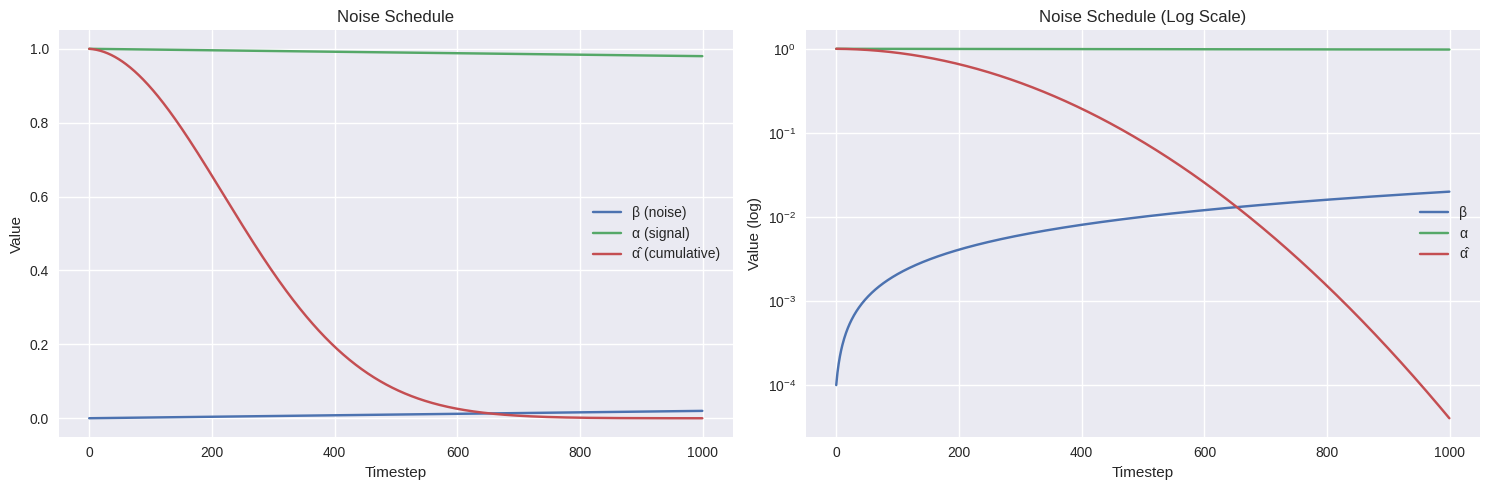


Initial noise shape: torch.Size([1, 4, 8, 20])


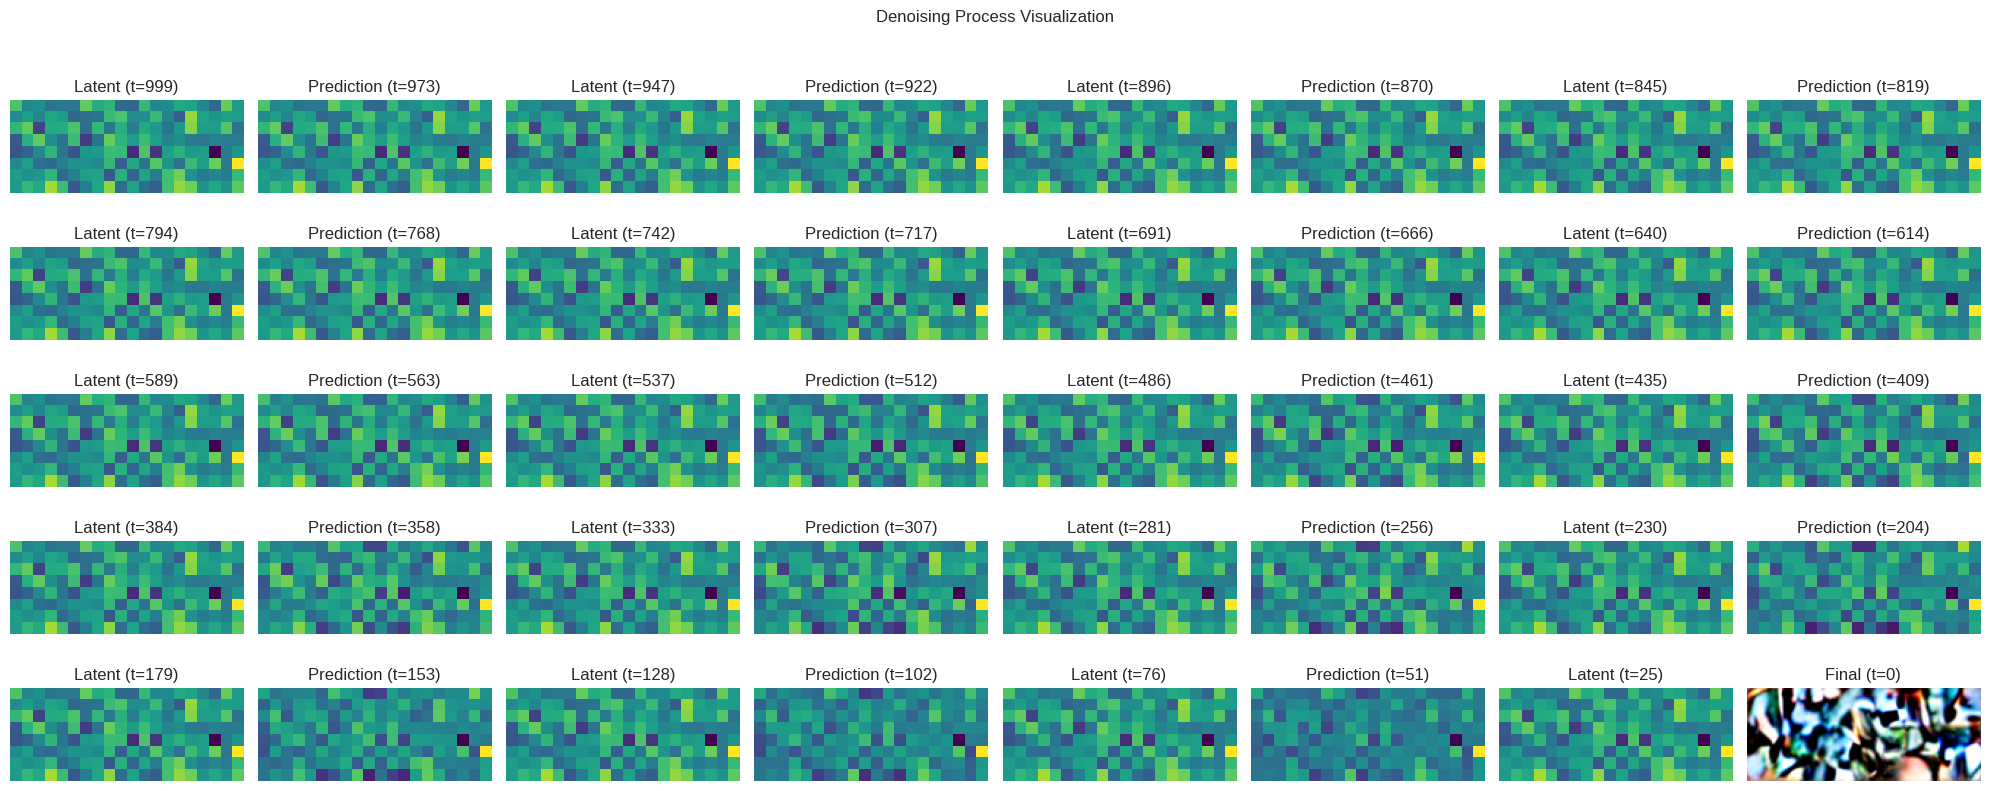

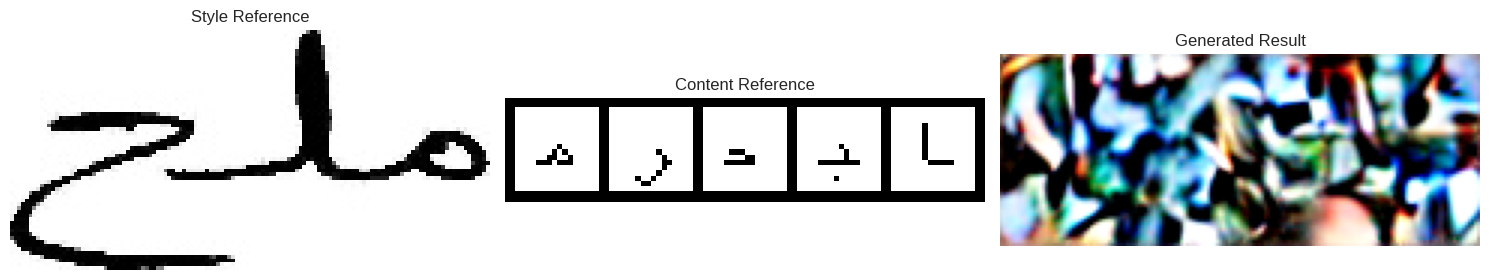


Statistics at key timesteps:

Timestep 999:
  Prediction - Mean: -0.040, Std: 0.998
  Latent    - Mean: -0.035, Std: 0.995

Timestep 486:
  Prediction - Mean: -0.075, Std: 1.024
  Latent    - Mean: -0.035, Std: 0.995

Timestep 0:
  Prediction - Mean: -0.061, Std: 1.314
  Latent    - Mean: -0.035, Std: 0.995


In [18]:
def test_diffusion_process(content_tensor, style_tensor, laplace_tensor, num_steps=40):
    """Test the diffusion process with detailed visualizations"""
    print("Testing diffusion process...")
    
    # 1. Examine and visualize noise schedule
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(model.diffusion.beta.cpu().numpy(), label='β (noise)')
    plt.plot(model.diffusion.alpha.cpu().numpy(), label='α (signal)')
    plt.plot(model.diffusion.alpha_hat.cpu().numpy(), label='α̂ (cumulative)')
    plt.title("Noise Schedule")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    
    # Show noise schedule in log scale
    plt.subplot(1,2,2)
    plt.semilogy(model.diffusion.beta.cpu().numpy(), label='β')
    plt.semilogy(model.diffusion.alpha.cpu().numpy(), label='α')
    plt.semilogy(model.diffusion.alpha_hat.cpu().numpy(), label='α̂')
    plt.title("Noise Schedule (Log Scale)")
    plt.xlabel("Timestep")
    plt.ylabel("Value (log)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. Generate and visualize initial noise
    x = torch.randn(
        (1, 4, style_tensor.shape[2]//8, content_tensor.shape[1]*4),
        device=device
    )
    print(f"\nInitial noise shape: {x.shape}")
    
    # 3. Show denoising progression with more detail
    timesteps = np.linspace(
        model.diffusion.noise_steps-1,
        0,
        num_steps
    ).astype(int)
    
    plt.figure(figsize=(20,8))
    for i, t in enumerate(timesteps):
        plt.subplot(5,num_steps//5,i+1)  # 5 rows instead of 4
        
        with torch.no_grad():
            time = torch.tensor([t], device=device)
            predicted = model.unet(
                x,
                time,
                style_tensor,
                laplace_tensor,
                content_tensor
            )
            
            # Visualize different stages
            if i == len(timesteps)-1:  # Final step
                latents = 1 / 0.18215 * x
                image = model.vae.decode(latents).sample
                image = (image / 2 + 0.5).clamp(0, 1)
                plt.imshow(image[0].permute(1,2,0).cpu().numpy())
                plt.title(f"Final (t={t})")
            else:
                # Show both noise prediction and current state
                if i % 2 == 0:
                    plt.imshow(x[0,0].cpu().numpy(), cmap='viridis')
                    plt.title(f"Latent (t={t})")
                else:
                    plt.imshow(predicted[0,0].cpu().numpy(), cmap='viridis')
                    plt.title(f"Prediction (t={t})")
                
                # Add timestep percentage
                percent = ((model.diffusion.noise_steps - t) / model.diffusion.noise_steps) * 100
                plt.xlabel(f"{percent:.1f}% complete")
        
        plt.axis('off')
    
    plt.suptitle("Denoising Process Visualization", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 4. Show final result with style reference
    plt.figure(figsize=(15,5))
    
    # Style reference
    plt.subplot(1,3,1)
    plt.imshow(style_tensor[0,0].cpu().numpy(), cmap='gray')
    plt.title("Style Reference")
    plt.axis('off')
    
    # Content reference
    plt.subplot(1,3,2)
    content_grid = torchvision.utils.make_grid(
        content_tensor[0].unsqueeze(1),
        nrow=content_tensor.shape[1],
        padding=2,
        normalize=True
    )
    plt.imshow(content_grid.cpu().permute(1,2,0).numpy(), cmap='gray')
    plt.title("Content Reference")
    plt.axis('off')
    
    # Final generated image
    plt.subplot(1,3,3)
    latents = 1 / 0.18215 * x
    image = model.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    plt.imshow(image[0].permute(1,2,0).cpu().numpy())
    plt.title("Generated Result")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics at key timesteps
    print("\nStatistics at key timesteps:")
    key_steps = [timesteps[0], timesteps[len(timesteps)//2], timesteps[-1]]
    for t in key_steps:
        with torch.no_grad():
            time = torch.tensor([t], device=device)
            predicted = model.unet(x, time, style_tensor, laplace_tensor, content_tensor)
            print(f"\nTimestep {t}:")
            print(f"  Prediction - Mean: {predicted.mean():.3f}, Std: {predicted.std():.3f}")
            print(f"  Latent    - Mean: {x.mean():.3f}, Std: {x.std():.3f}")

# Test diffusion process
test_diffusion_process(content_tensor, style_tensor, laplace_tensor)

## 6. End-to-End Generation Testing

Finally, let's test the complete generation pipeline.

Testing complete pipeline...
Generating 'آيات' in different styles...

Tensor shapes:
Style tensor: torch.Size([1, 1, 64, 320])
Laplace tensor: torch.Size([1, 1, 64, 320])
Content tensor: torch.Size([1, 4, 16, 16])



sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 34.63it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 35.05it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 34.56it/s]
                                                                                                 /tmp/ipykernel_869193/2581818645.py:83: UserWarning: Glyph 1570 (\N{ARABIC LETTER ALEF WITH MADDA ABOVE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_869193/2581818645.py:83: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipykernel_869193/2581818645.py:83: UserWarning: Glyph 1610 (\N{ARABIC LETTER YEH}) missing from current font.
  plt.tight_la

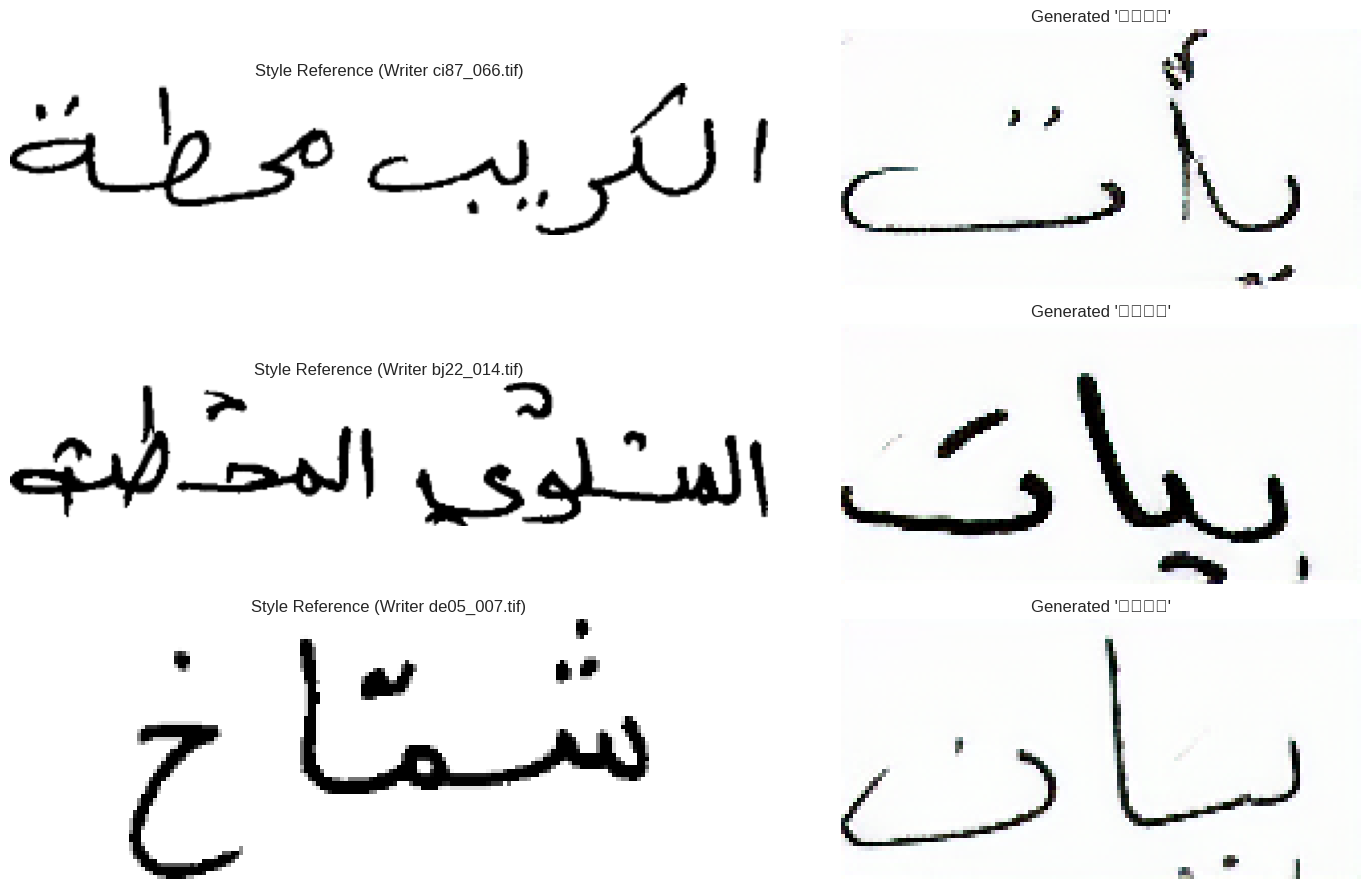

Generating 'مرخا' in different styles...

Tensor shapes:
Style tensor: torch.Size([1, 1, 64, 384])
Laplace tensor: torch.Size([1, 1, 64, 384])
Content tensor: torch.Size([1, 4, 16, 16])



sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 35.75it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 35.22it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 35.67it/s]
                                                                                                 /tmp/ipykernel_869193/2581818645.py:83: UserWarning: Glyph 1605 (\N{ARABIC LETTER MEEM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_869193/2581818645.py:83: UserWarning: Glyph 1585 (\N{ARABIC LETTER REH}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_869193/2581818645.py:83: UserWarning: Glyph 1582 (\N{ARABIC LETTER KHAH}) missing from current font.
  plt.tight_layout()


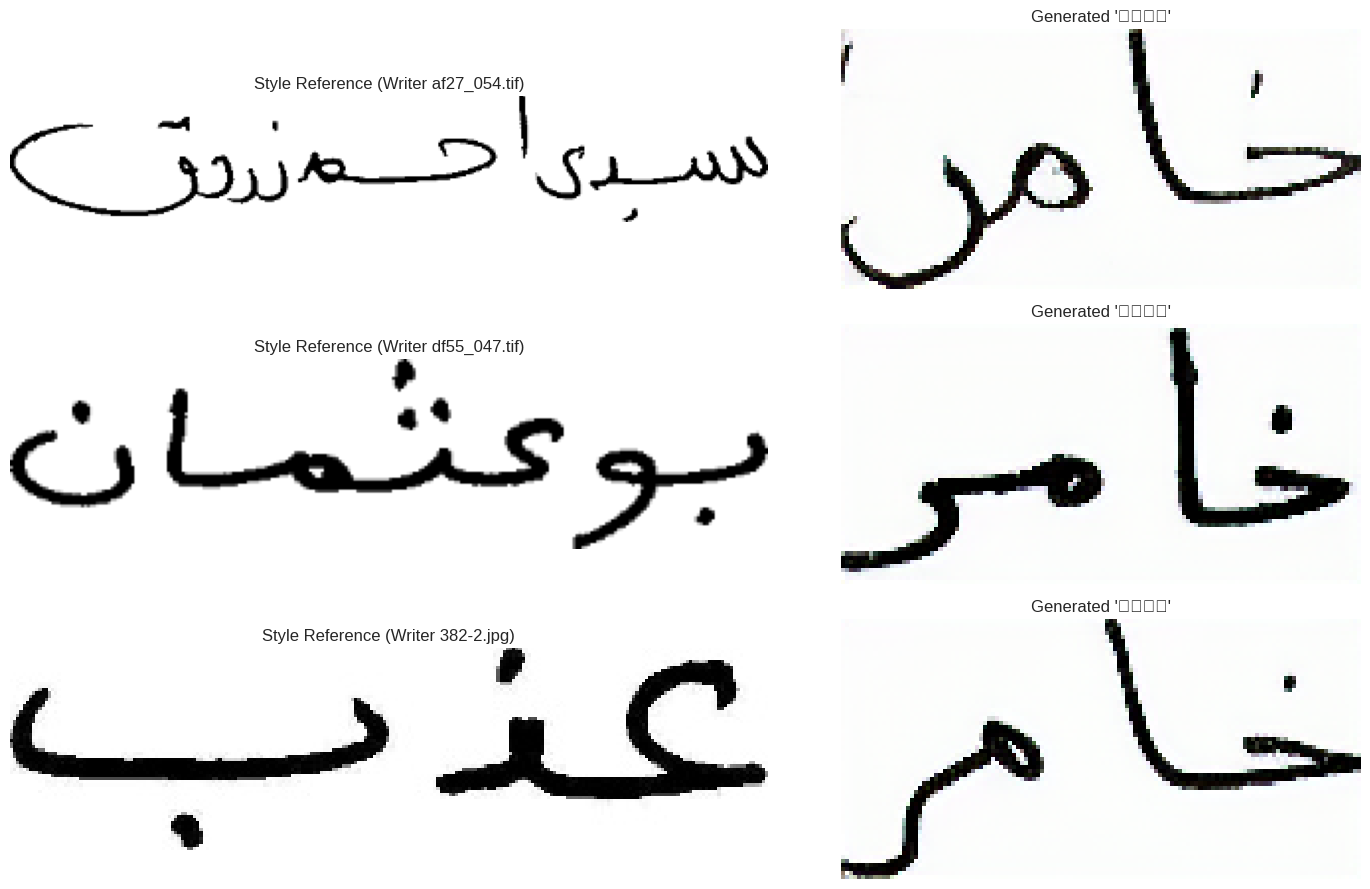

In [68]:
import os, numpy as np, torch, matplotlib.pyplot as plt
from einops import rearrange
from torchvision.utils import make_grid

from parse_config import cfg                      # gives cfg.MODEL.EMB_DIM = 512
from data_loader.loader_ara import ContentData, Random_StyleIAMDataset
from models.fusion import Mix_TR



def test_complete_pipeline(text, writer_id=None, num_samples=3):
    print(f"Generating '{text}' in different styles...")
    
    # 1. Prepare content
    content_tensor = model.content_data.get_content(text)
    
    # 2. Get style references
    style_dataset = Random_StyleIAMDataset(
        style_path=os.path.join(cfg.DATA_LOADER.STYLE_PATH, 'train'),
        laplace_path=os.path.join(cfg.DATA_LOADER.LAPLACE_PATH, 'train'),
        ref_num=1
    )
    
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        # Get random writer if not specified
        current_writer = writer_id or np.random.choice(style_dataset.author_id)
        
        # Get style reference
        style_img, laplace_img = style_dataset.get_style_ref(current_writer)
        
        # Fix tensor dimensions - add channel dimension
        style_tensor = torch.from_numpy(style_img).float().unsqueeze(0).unsqueeze(0).to(device)
        laplace_tensor = torch.from_numpy(laplace_img).float().unsqueeze(0).unsqueeze(0).to(device)
        content_tensor = content_tensor.float().to(device)
        
        # Print shapes for debugging
        if i == 0:
            print("\nTensor shapes:")
            print(f"Style tensor: {style_tensor.shape}")
            print(f"Laplace tensor: {laplace_tensor.shape}")
            print(f"Content tensor: {content_tensor.shape}")
        
        # Generate initial noise
        x = torch.randn(
            (1, 4, style_tensor.shape[2]//8, content_tensor.shape[1]*4),
            device=device
        )
        
        try:
            with torch.no_grad():
                generated = model.diffusion.ddim_sample(
                    model.unet,
                    model.vae,
                    1,
                    x,
                    style_tensor,
                    laplace_tensor,
                    content_tensor
                )
            
            # Plot results
            plt.subplot(num_samples, 2, 2*i+1)
            plt.imshow(style_img, cmap='gray')
            plt.title(f"Style Reference (Writer {current_writer})")
            plt.axis('off')
            
            plt.subplot(num_samples, 2, 2*i+2)
            plt.imshow(generated[0].permute(1,2,0).cpu().numpy())
            plt.title(f"Generated '{text}'")
            plt.axis('off')
            
        except Exception as e:
            print(f"\nError in sample {i}:")
            print(e)
            print("\nCurrent tensor shapes:")
            print(f"x: {x.shape}")
            print(f"style_tensor: {style_tensor.shape}")
            print(f"laplace_tensor: {laplace_tensor.shape}")
            print(f"content_tensor: {content_tensor.shape}")
            continue
    
    plt.tight_layout()
    plt.show()

# Test complete pipeline
print("Testing complete pipeline...")
test_complete_pipeline("آيات", num_samples=3)
test_complete_pipeline("مرخا", num_samples=3)

Generating 'الشارقة' in different styles...

Tensor shapes:
Style tensor: torch.Size([1, 1, 64, 128])
Laplace tensor: torch.Size([1, 1, 64, 128])
Content tensor: torch.Size([1, 7, 16, 16])



sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 34.91it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 33.85it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 34.18it/s]
                                                                                                 /tmp/ipykernel_869193/1916405238.py:99: UserWarning: Glyph 1575 (\N{ARABIC LETTER ALEF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_869193/1916405238.py:99: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/tmp/ipykernel_869193/1916405238.py:99: UserWarning: Glyph 1604 (\N{ARABIC LETTER LAM}) missing from current font.
  plt.tight_layout()
/tmp/ipyke

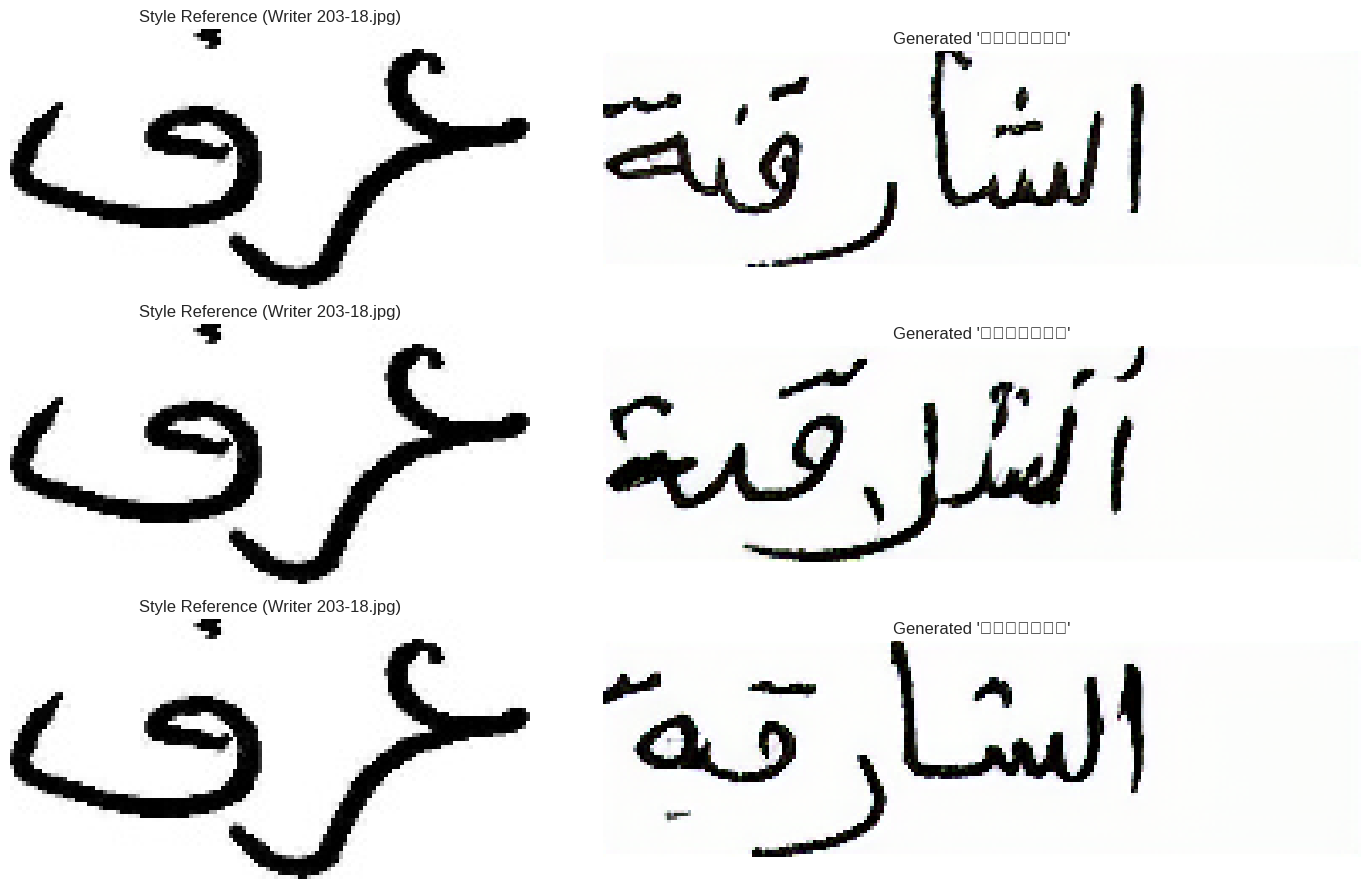

Generating 'أستاذ' in different styles...

Tensor shapes:
Style tensor: torch.Size([1, 1, 64, 128])
Laplace tensor: torch.Size([1, 1, 64, 128])
Content tensor: torch.Size([1, 5, 16, 16])



sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 36.55it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 35.90it/s]
                                                                                                 
sampling:  96%|████████████████████████████████████████████████  | 48/50 [00:01<00:00, 35.90it/s]
                                                                                                 /tmp/ipykernel_869193/1916405238.py:99: UserWarning: Glyph 1571 (\N{ARABIC LETTER ALEF WITH HAMZA ABOVE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_869193/1916405238.py:99: UserWarning: Glyph 1587 (\N{ARABIC LETTER SEEN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_869193/1916405238.py:99: UserWarning: Glyph 1578 (\N{ARABIC LETTER TEH}) missing from current font.
  plt.

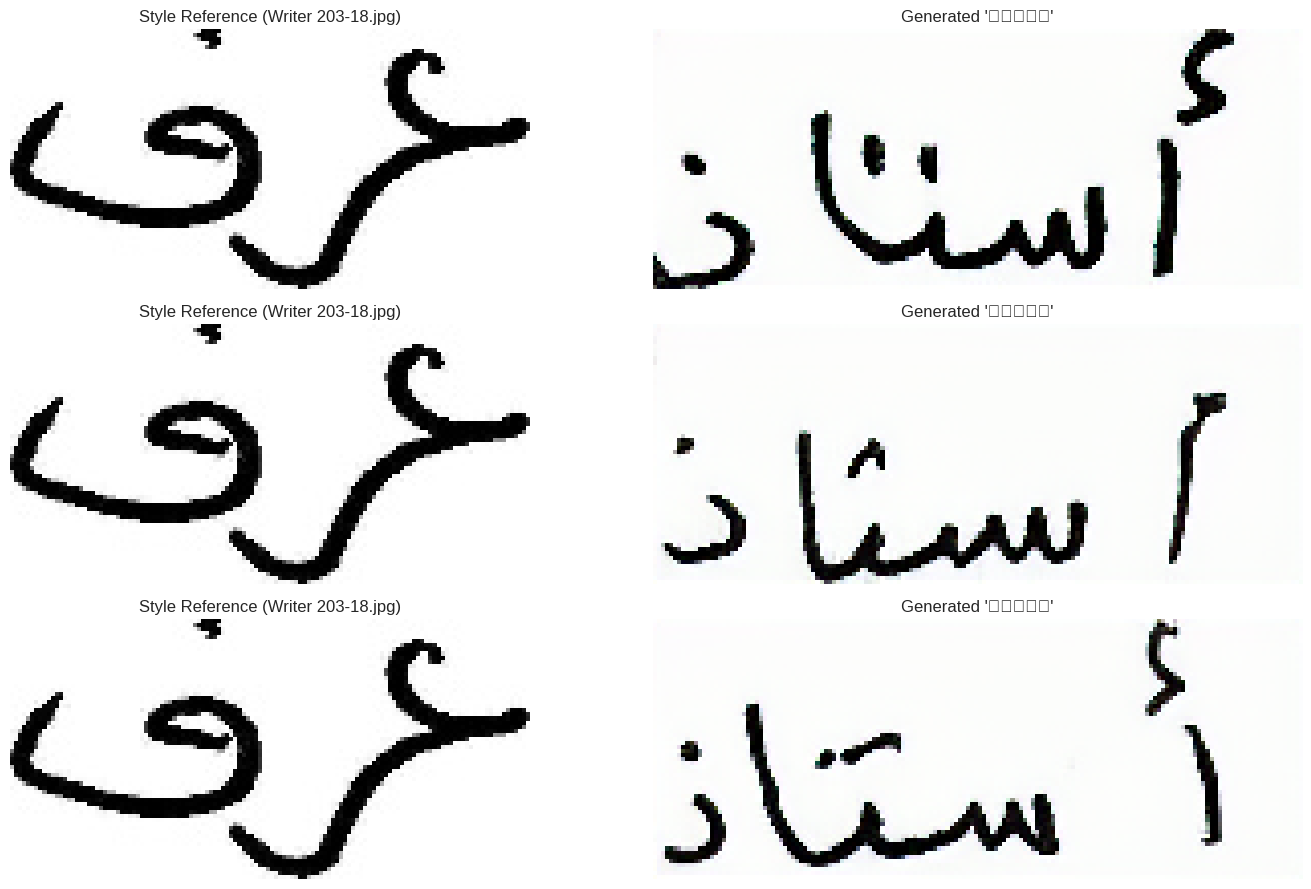

In [69]:
import os, numpy as np, torch, matplotlib.pyplot as plt
from einops import rearrange
from torchvision.utils import make_grid

from parse_config import cfg                      # gives cfg.MODEL.EMB_DIM = 512
from data_loader.loader_ara import ContentData, Random_StyleIAMDataset
from models.fusion import Mix_TR

def test_complete_pipeline(text, writer_id=None, num_samples=3):
    print(f"Generating '{text}' in different styles...")

    # 1. Prepare content
    content_tensor = model.content_data.get_content(text)

    # 2. Get style references
    style_dataset = Random_StyleIAMDataset(
        style_path=os.path.join(cfg.DATA_LOADER.STYLE_PATH, 'test'),
        laplace_path=os.path.join(cfg.DATA_LOADER.LAPLACE_PATH, 'test'),
        ref_num=1
    )

    # Print available writer IDs (filenames)
#     print("Available writer IDs (filenames):", style_dataset.author_id)

    # If no writer_id is provided, use the first available writer for consistency
    if writer_id is None:
        writer_id = style_dataset.author_id[0]  # Use the first available filename

    # If writer_id is an integer, convert to string and check if it matches a filename
    if isinstance(writer_id, int):
        # Try to match by index in the list
        if 0 <= writer_id < len(style_dataset.author_id):
            writer_id = style_dataset.author_id[writer_id]
        else:
            raise ValueError(f"Integer writer_id {writer_id} is out of range for available style references.")

    # If writer_id is not in the available list, raise an error
    if writer_id not in style_dataset.author_id:
        raise ValueError(f"writer_id '{writer_id}' is not a valid style reference. Choose from: {style_dataset.author_id}")

    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        current_writer = writer_id  # Use the valid filename

        # Get style reference
        style_img, laplace_img = style_dataset.get_style_ref(current_writer)

        # Fix tensor dimensions - add channel dimension
        style_tensor = torch.from_numpy(style_img).float().unsqueeze(0).unsqueeze(0).to(device)
        laplace_tensor = torch.from_numpy(laplace_img).float().unsqueeze(0).unsqueeze(0).to(device)
        content_tensor = content_tensor.float().to(device)

        # Print shapes for debugging
        if i == 0:
            print("\nTensor shapes:")
            print(f"Style tensor: {style_tensor.shape}")
            print(f"Laplace tensor: {laplace_tensor.shape}")
            print(f"Content tensor: {content_tensor.shape}")

        # Generate initial noise
        x = torch.randn(
            (1, 4, style_tensor.shape[2]//8, content_tensor.shape[1]*4),
            device=device
        )

        try:
            with torch.no_grad():
                generated = model.diffusion.ddim_sample(
                    model.unet,
                    model.vae,
                    1,
                    x,
                    style_tensor,
                    laplace_tensor,
                    content_tensor
                )

            # Plot results
            plt.subplot(num_samples, 2, 2*i+1)
            plt.imshow(style_img, cmap='gray')
            plt.title(f"Style Reference (Writer {current_writer})")
            plt.axis('off')

            plt.subplot(num_samples, 2, 2*i+2)
            plt.imshow(generated[0].permute(1,2,0).cpu().numpy())
            plt.title(f"Generated '{text}'")
            plt.axis('off')

        except Exception as e:
            print(f"\nError in sample {i}:")
            print(e)
            print("\nCurrent tensor shapes:")
            print(f"x: {x.shape}")
            print(f"style_tensor: {style_tensor.shape}")
            print(f"laplace_tensor: {laplace_tensor.shape}")
            print(f"content_tensor: {content_tensor.shape}")
            continue

    plt.tight_layout()
    plt.show()

# Example usage:
# To use the first available style reference:
# test_complete_pipeline("مرحى", num_samples=3)
# To use a specific style reference (filename), e.g. "00001.png":
# test_complete_pipeline("مرحى", writer_id="00001.png", num_samples=3)
# To use by index in the list (e.g. 0 for the first, 1 for the second):
# test_complete_pipeline("عمران", writer_id=666, num_samples=5)
test_complete_pipeline("الشارقة", writer_id=665, num_samples=3)
test_complete_pipeline("أستاذ", writer_id=665, num_samples=3)

Testing grid annotations functionality...
Testing grid annotations with texts: ['سلام', 'مرحبا', 'شكرا']
Found 50 actual writer IDs: ['alexuw-691', 'alexuw-718', 'alexuw-295', 'alexuw-862', 'alexuw-293', 'ifnenit-di27', 'alexuw-366', 'alexuw-800', 'ifnenit-ai62', 'alexuw-266']...

Testing grid for text: 'سلام'
Generated batch shape: torch.Size([4, 3, 64, 256])
Writer IDs: ['alexuw-816', 'ahawp-33', 'alexuw-886', 'ifnenit-de96']
Grid dimensions: 1 rows x 4 cols
Single image size: 256 x 64
Added annotation 'alexuw-816' at position (0, 0) for image 0
Added annotation 'ahawp-33' at position (258, 0) for image 1
Added annotation 'alexuw-886' at position (516, 0) for image 2
Added annotation 'ifnenit-de96' at position (774, 0) for image 3


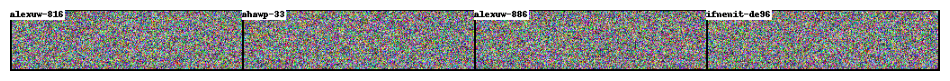


Testing grid for text: 'مرحبا'
Generated batch shape: torch.Size([4, 3, 64, 256])
Writer IDs: ['alexuw-293', 'alexuw-502', 'alexuw-886', 'alexuw-101']
Grid dimensions: 1 rows x 4 cols
Single image size: 256 x 64
Added annotation 'alexuw-293' at position (0, 0) for image 0
Added annotation 'alexuw-502' at position (258, 0) for image 1
Added annotation 'alexuw-886' at position (516, 0) for image 2
Added annotation 'alexuw-101' at position (774, 0) for image 3


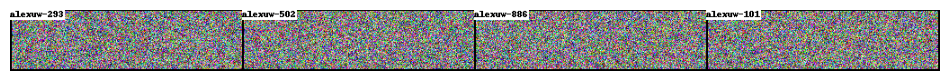


Testing grid for text: 'شكرا'
Generated batch shape: torch.Size([4, 3, 64, 256])
Writer IDs: ['alexuw-601', 'alexuw-27', 'alexuw-502', 'alexuw-295']
Grid dimensions: 1 rows x 4 cols
Single image size: 256 x 64
Added annotation 'alexuw-601' at position (0, 0) for image 0
Added annotation 'alexuw-27' at position (258, 0) for image 1
Added annotation 'alexuw-502' at position (516, 0) for image 2
Added annotation 'alexuw-295' at position (774, 0) for image 3


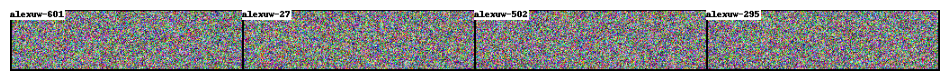


Testing different batch sizes...

Testing batch size: 1
Grid dimensions: 1 rows x 1 cols
Single image size: 256 x 64
Added annotation 'ifnenit-di27' at position (0, 0) for image 0


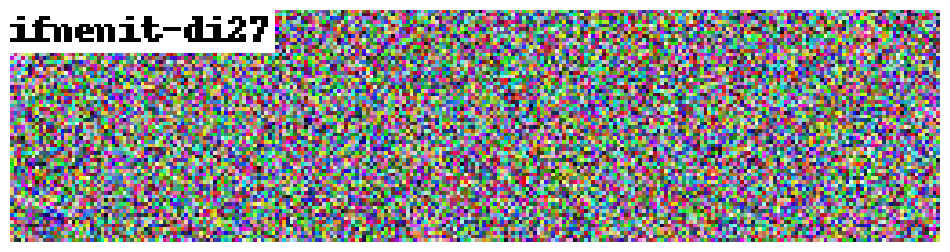


Testing batch size: 2
Grid dimensions: 1 rows x 2 cols
Single image size: 256 x 64
Added annotation 'alexuw-266' at position (0, 0) for image 0
Added annotation 'ifnenit-ai62' at position (258, 0) for image 1


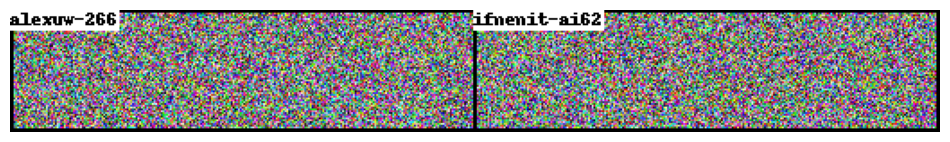


Testing batch size: 4
Grid dimensions: 1 rows x 4 cols
Single image size: 256 x 64
Added annotation 'alexuw-158' at position (0, 0) for image 0
Added annotation 'ahawp-33' at position (258, 0) for image 1
Added annotation 'alexuw-107' at position (516, 0) for image 2
Added annotation 'alexuw-849' at position (774, 0) for image 3


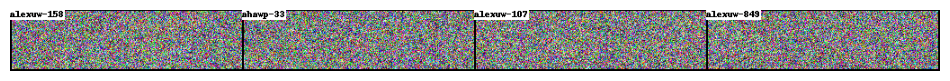


Testing batch size: 6
Grid dimensions: 1 rows x 6 cols
Single image size: 256 x 64
Added annotation 'alexuw-627' at position (0, 0) for image 0
Added annotation 'ifnenit-de96' at position (258, 0) for image 1
Added annotation 'alexuw-27' at position (516, 0) for image 2
Added annotation 'ifnenit-af35' at position (774, 0) for image 3
Added annotation 'ifnenit-df61' at position (1032, 0) for image 4
Added annotation 'ahawp-12' at position (1290, 0) for image 5


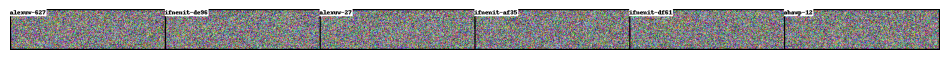


Testing batch size: 8
Grid dimensions: 1 rows x 8 cols
Single image size: 256 x 64
Added annotation 'alexuw-134' at position (0, 0) for image 0
Added annotation 'alexuw-101' at position (258, 0) for image 1
Added annotation 'alexuw-295' at position (516, 0) for image 2
Added annotation 'ifnenit-de96' at position (774, 0) for image 3
Added annotation 'ifnenit-am00' at position (1032, 0) for image 4
Added annotation 'ifnenit-cf54' at position (1290, 0) for image 5
Added annotation 'ahawp-22' at position (1548, 0) for image 6
Added annotation 'ifnenit-bf50' at position (1806, 0) for image 7


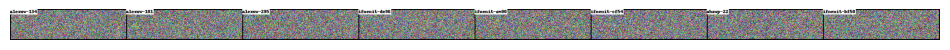


Testing batch size: 10
Grid dimensions: 2 rows x 8 cols
Single image size: 256 x 64
Added annotation 'ifnenit-aq34' at position (0, 0) for image 0
Added annotation 'ahawp-12' at position (258, 0) for image 1
Added annotation 'alexuw-27' at position (516, 0) for image 2
Added annotation 'alexuw-816' at position (774, 0) for image 3
Added annotation 'alexuw-841' at position (1032, 0) for image 4
Added annotation 'ifnenit-bf26' at position (1290, 0) for image 5
Added annotation 'alexuw-266' at position (1548, 0) for image 6
Added annotation 'ifnenit-bf26' at position (1806, 0) for image 7
Added annotation 'ifnenit-am17' at position (0, 66) for image 8
Added annotation 'alexuw-533' at position (258, 66) for image 9


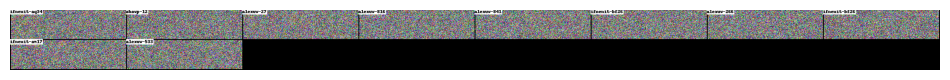


Grid annotation testing completed!
Check the generated PNG files to verify the annotations are working correctly.


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw, ImageFont
import torchvision
from parse_config import cfg
from data_loader.loader_ara import ContentData, Random_StyleIAMDataset

def get_actual_writer_ids(data_file_path, max_writers=20):
    """
    Get actual writer IDs from the training data text file
    """
    writer_ids = set()
    try:
        with open(data_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) < 2:
                    continue
                first_field = parts[0]
                writer_id = first_field.split(',')[0]
                writer_ids.add(writer_id)
                if len(writer_ids) >= max_writers:
                    break
    except FileNotFoundError:
        print(f"Warning: Could not find data file {data_file_path}")
        # Fallback to some common writer IDs
        writer_ids = {"000", "001", "002", "003", "004", "005"}
    
    return list(writer_ids)

def test_grid_annotations(texts, num_samples=4):
    """
    Test the grid annotation functionality similar to trainer._save_images
    """
    print(f"Testing grid annotations with texts: {texts}")
    
    # Initialize content data loader
    content_data = ContentData()
    
    # Get actual writer IDs from training data
    train_data_path = os.path.join('data', 'train.txt')
    actual_writer_ids = get_actual_writer_ids(train_data_path, max_writers=50)
    print(f"Found {len(actual_writer_ids)} actual writer IDs: {actual_writer_ids[:10]}...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for text in texts:
        print(f"\nTesting grid for text: '{text}'")
        
        # Create dummy generated images (simulating model output)
        dummy_images = []
        writer_ids = []
        
        for i in range(num_samples):
            # Get random actual writer ID
            writer_id = np.random.choice(actual_writer_ids)
            writer_ids.append(writer_id)
            
            # Create a dummy image (64x256 to simulate handwriting)
            # In real scenario, this would be the model's generated output
            dummy_img = torch.randn(3, 64, 256)  # RGB image
            dummy_images.append(dummy_img)
        
        # Stack images into batch
        images_batch = torch.stack(dummy_images)
        
        print(f"Generated batch shape: {images_batch.shape}")
        print(f"Writer IDs: {writer_ids}")
        
        # Test the _save_images functionality
        plot_images_with_annotations(images_batch, writer_ids)

def plot_images_with_annotations(images, writer_ids=None):
    """
    Plot the images with annotations without saving
    """
    # Create grid of images
    grid = torchvision.utils.make_grid(images)
    im = torchvision.transforms.ToPILImage()(grid)
    
    # If we have writer IDs, add them as text
    if writer_ids is not None:
        draw = ImageDraw.Draw(im)
        font = ImageFont.load_default()  # Use default font for simplicity
        
        # Calculate grid dimensions
        n_cols = min(8, images.shape[0])  # Default nrow in make_grid is 8
        n_rows = (images.shape[0] + n_cols - 1) // n_cols
        single_img_w = images.shape[3]
        single_img_h = images.shape[2]
        
        print(f"Grid dimensions: {n_rows} rows x {n_cols} cols")
        print(f"Single image size: {single_img_w} x {single_img_h}")
        
        # Add text for each image
        for idx, wid in enumerate(writer_ids):
            if idx >= images.shape[0]:  # Safety check
                break
                
            row = idx // n_cols
            col = idx % n_cols
            x = col * (single_img_w + 2)  # +2 for padding in make_grid
            y = row * (single_img_h + 2)
            
            # Draw white background for better visibility
            text = str(wid)
            bbox = draw.textbbox((x, y), text, font=font)
            draw.rectangle(bbox, fill='white')
            # Draw text
            draw.text((x, y), text, fill='black', font=font)
            
            print(f"Added annotation '{text}' at position ({x}, {y}) for image {idx}")
    
    # Display the result
    plt.figure(figsize=(12, 8))
    plt.imshow(im)
    plt.axis('off')
    plt.show()

def test_different_batch_sizes():
    """
    Test grid annotations with different batch sizes
    """
    print("\n" + "="*50)
    print("Testing different batch sizes...")
    
    # Get actual writer IDs from training data
    train_data_path = os.path.join('data', 'train.txt')
    actual_writer_ids = get_actual_writer_ids(train_data_path, max_writers=50)
    
    batch_sizes = [1, 2, 4, 6, 8, 10]
    
    for batch_size in batch_sizes:
        print(f"\nTesting batch size: {batch_size}")
        
        # Create dummy images and writer IDs
        dummy_images = [torch.randn(3, 64, 256) for _ in range(batch_size)]
        writer_ids = [np.random.choice(actual_writer_ids) for _ in range(batch_size)]
        
        images_batch = torch.stack(dummy_images)
        
        plot_images_with_annotations(images_batch, writer_ids)

if __name__ == "__main__":
    # Test with Arabic texts
    arabic_texts = ["سلام", "مرحبا", "شكرا"]
    
    print("Testing grid annotations functionality...")
    test_grid_annotations(arabic_texts, num_samples=4)
    
    # Test different batch sizes
    test_different_batch_sizes()
    
    print("\n" + "="*50)
    print("Grid annotation testing completed!")
    print("Check the generated PNG files to verify the annotations are working correctly.") 

## TESTS

In [21]:
# test_line_loader.py  ────────────────────────────────────────────────
import os, torch
from parse_config import cfg
from data_loader.loader_ara import IAMDataset

ds = IAMDataset(cfg.DATA_LOADER.IAMGE_PATH,
                cfg.DATA_LOADER.STYLE_PATH,
                cfg.DATA_LOADER.LAPLACE_PATH,
                "train")
img = ds[0]["img"]                           # [3,H,W]
print("Line image:", img.shape, img.min(), img.max())    # expect (3,≥64,≥128)

Line image: torch.Size([3, 64, 176]) tensor(-1.) tensor(1.)


In [22]:
# test_style_loader.py  ───────────────────────────────────────────────
import os, torch, numpy as np
from parse_config import cfg
from data_loader.loader_ara import Random_StyleIAMDataset

ds = Random_StyleIAMDataset(style_path   = os.path.join(cfg.DATA_LOADER.STYLE_PATH,"train"),
                            laplace_path = os.path.join(cfg.DATA_LOADER.LAPLACE_PATH,"train"),
                            ref_num=1)
style, laplace = ds.get_style_ref(ds.author_id[0])
print("Style :", style.shape, style.min(), style.max())      # (64,W)
print("Laplace:", laplace.shape, laplace.min(), laplace.max())

Style : (64, 128) 0.0 1.0
Laplace: (64, 128) 0.0 1.0


In [23]:
# test_glyph_loader.py  ───────────────────────────────────────────────
from data_loader.loader_ara import ContentData
cd = ContentData()
txt = "مرحبا"
glyphs = cd.get_content(txt)        # [1,L,16,16]
print("Glyph tensor :", glyphs.shape)

Glyph tensor : torch.Size([1, 5, 16, 16])


In [24]:
# test_content_encoder.py  ────────────────────────────────────────────
import torch
from models.fusion import Mix_TR
from parse_config import cfg
from data_loader.loader_ara import ContentData
cd = ContentData(); word="test"
g = cd.get_content(word)
net = Mix_TR(d_model=cfg.MODEL.EMB_DIM).eval()
with torch.no_grad():
    out = net.content_encoder(g.view(-1,1,16,16)).view(len(word),-1)
print(out.shape)      # (L,512)

torch.Size([4, 512])


In [25]:
# test_style_encoder.py  ──────────────────────────────────────────────
import torch, os
from models.fusion import Mix_TR
from parse_config import cfg
from data_loader.loader_ara import Random_StyleIAMDataset
ds = Random_StyleIAMDataset(os.path.join(cfg.DATA_LOADER.STYLE_PATH,"train"),
                            os.path.join(cfg.DATA_LOADER.LAPLACE_PATH,"train"),1)
s,l = ds.get_style_ref(ds.author_id[0])
s = torch.from_numpy(s).unsqueeze(0).unsqueeze(0)
l = torch.from_numpy(l).unsqueeze(0).unsqueeze(0)
net = Mix_TR(d_model=cfg.MODEL.EMB_DIM).eval()
low = net.get_low_style_feature(s)
high= net.get_high_style_feature(l)
print("Low freq :", low.shape)   # (16,1,256)
print("High freq:", high.shape)

Low freq : torch.Size([32, 1, 512])
High freq: torch.Size([32, 1, 512])


In [26]:
# test_mix_tr.py  ─────────────────────────────────────────────────────
from parse_config import cfg
from models.fusion import Mix_TR
from data_loader.loader_ara import ContentData, Random_StyleIAMDataset
import os, torch, numpy as np
net = Mix_TR(d_model=cfg.MODEL.EMB_DIM).eval()
cd = ContentData(); word="hello"
content = cd.get_content(word)
ds = Random_StyleIAMDataset(os.path.join(cfg.DATA_LOADER.STYLE_PATH,"train"),
                            os.path.join(cfg.DATA_LOADER.LAPLACE_PATH,"train"),1)
s,l = ds.get_style_ref(ds.author_id[0])
s = torch.from_numpy(s).unsqueeze(0).unsqueeze(0)
l = torch.from_numpy(l).unsqueeze(0).unsqueeze(0)
fused = net.generate(s,l,content)
print("Fused :", fused.shape)   # (1,L,512)

Fused : torch.Size([1, 5, 512])


In [27]:
# import cv2, os, sys, shutil
# from pathlib import Path
# from multiprocessing.pool import ThreadPool

# # 👇 Change this to your desired paths (strings or Path objects)
# SRC_ROOTS  = ["data/combined_dataset", "data/combined_dataset_laplace"]
# DST_SUFFIX = "_64"
# TARGET_H   = 64
# MIN_W      = 128
# MAX_W      = 416
# N_THREADS  = 8



# def resize_keep_h(img):
#     h, w = img.shape[:2]
#     new_w = int(round(w * TARGET_H / h))
#     new_w = max(MIN_W, min(MAX_W, new_w))
#     return cv2.resize(img, (new_w, TARGET_H), cv2.INTER_AREA)

# def process_one(arg):
#     src_path, dst_path = arg
#     img = cv2.imread(str(src_path), cv2.IMREAD_UNCHANGED)
#     if img is None:
#         print("⚠️  could not read", src_path)
#         return
#     img = resize_keep_h(img)
#     cv2.imwrite(str(dst_path), img)

# def collect_jobs(root_src):
#     root_dst = Path(root_src + DST_SUFFIX)
#     jobs = []
#     for split in ("train", "val", "test"):
#         for file in (Path(root_src) / split).rglob("*.*"):
#             rel = file.relative_to(root_src)
#             dst_file = root_dst / rel
#             dst_file.parent.mkdir(parents=True, exist_ok=True)
#             jobs.append((file, dst_file))
#     return jobs

# def run_resizing_pipeline(src_roots):
#     all_jobs = []
#     for src in src_roots:
#         if not Path(src).exists():
#             print(f"❌ Directory '{src}' not found – abort.")
#             return
#         all_jobs += collect_jobs(src)

#     print(f"🖼️  {len(all_jobs)} images to process …")
#     with ThreadPool(N_THREADS) as pool:
#         for _ in pool.imap_unordered(process_one, all_jobs):
#             pass
#     print("✅  Done – resized images saved alongside original folders.")
    


# # Specify your dataset paths
# SRC_ROOTS = ["data/combined_dataset", "data/combined_dataset_laplace"]

# # Run the resizing pipeline
# run_resizing_pipeline(SRC_ROOTS)

Testing dataset loading...
Creating dataset...
Dataset created successfully with 42887 samples
Testing single item access...
Item keys: dict_keys(['img', 'content', 'style', 'laplace', 'wid', 'transcr', 'image_name'])
Image shape: torch.Size([3, 64, 176])
Content: شأن
Writer ID: alexuw-691
Transcription: شأن
Testing batch collation...
[DEBUG COLLATE] Sample 0: Original content='شأن', len=3
[DEBUG COLLATE] Sample 0: contextual_glyphs shape=torch.Size([3, 16, 16]) base_indices=[16, 1, 28]
[DEBUG COLLATE] letters : ['ش', 'أ', 'ن']
[DEBUG COLLATE] forms   : ['initial', 'final', 'isolated']
[DEBUG COLLATE] codepoints: ['0xfeb7', '0xfe84', '0x646']


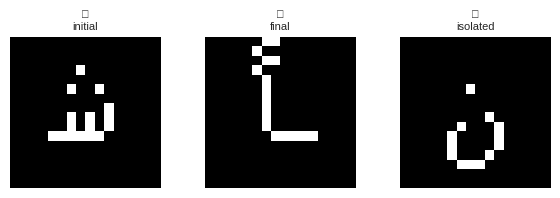

Collated batch keys: dict_keys(['img', 'style', 'content', 'wid', 'wid_str', 'laplace', 'target', 'target_lengths', 'image_name', 'transcr'])
Batch image shape: torch.Size([4, 3, 64, 208])
Batch writer IDs: tensor([729, 729, 729, 729])
Batch writer ID strings: ['alexuw-691', 'alexuw-691', 'alexuw-691', 'alexuw-691']
✅ Dataset loading test passed!


In [28]:
#!/usr/bin/env python3

"""
Simple test script to verify dataset loading works correctly
"""

import torch
from data_loader.loader_ara import IAMDataset
from parse_config import cfg, cfg_from_file, assert_and_infer_cfg

def test_dataset_loading():
    print("Testing dataset loading...")
    
    # Load config
    cfg_from_file('configs/IAM64_scratch.yml')
    assert_and_infer_cfg()
    
    try:
        # Create dataset
        print("Creating dataset...")
        dataset = IAMDataset(
            cfg.DATA_LOADER.IAMGE_PATH, 
            cfg.DATA_LOADER.STYLE_PATH, 
            cfg.DATA_LOADER.LAPLACE_PATH, 
            cfg.TRAIN.TYPE
        )
        print(f"Dataset created successfully with {len(dataset)} samples")
        
        # Test single item
        print("Testing single item access...")
        item = dataset[0]
        print(f"Item keys: {item.keys()}")
        print(f"Image shape: {item['img'].shape}")
        print(f"Content: {item['content']}")
        print(f"Writer ID: {item['wid']}")
        print(f"Transcription: {item['transcr']}")
        
        # Test batch collation
        print("Testing batch collation...")
        batch = [dataset[i] for i in range(min(4, len(dataset)))]
        collated = dataset.collate_fn_(batch)
        print(f"Collated batch keys: {collated.keys()}")
        print(f"Batch image shape: {collated['img'].shape}")
        print(f"Batch writer IDs: {collated['wid']}")
        if 'wid_str' in collated:
            print(f"Batch writer ID strings: {collated['wid_str']}")
        
        print("✅ Dataset loading test passed!")
        return True
        
    except Exception as e:
        print(f"❌ Dataset loading test failed: {e}")
        import traceback
        traceback.print_exc()
        return False

if __name__ == "__main__":
    test_dataset_loading() 

Starting comprehensive style pipeline tests...


=== Testing Raw Image Sizes ===
Checking images in: ./data/combined_dataset
Checking styles in: ./data/combined_dataset/train

Raw main image sizes:

Raw style image sizes:
  267-9.jpg: (64, 128, 3)
  b_O10_004.bmp: (64, 128, 3)
  user028_ghaleez_020.png: (64, 128, 3)
  763-24.jpg: (64, 224, 3)
  user025_mustadhafeen_028.png: (64, 176, 3)
=== Testing Style Pipeline ===
Available writer IDs: 49412
First 10 writer IDs: ['267-9.jpg', 'b_O10_004.bmp', 'user028_ghaleez_020.png', '763-24.jpg', 'user025_mustadhafeen_028.png', 'ce24_026.tif', '697-18.jpg', '172-28.jpg', 'user017_qashtah_030.png', 'di84_030.tif']

Testing style pipeline with writer ID: 514-2.jpg
Style image shape: (64, 208)
Laplace image shape: (64, 208)
Style value range: [0.000, 1.000]
Laplace value range: [0.000, 1.000]


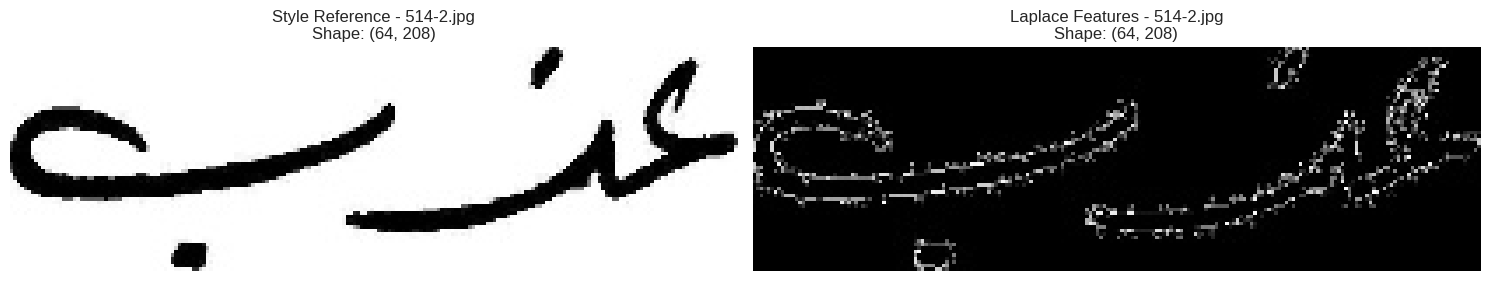


Tensor conversion:
Style tensor shape: torch.Size([1, 64, 208])
Laplace tensor shape: torch.Size([1, 64, 208])
Device: cuda

=== Testing Main Dataset 64x64 Resizing ===
Dataset size: 42887

Sample 0:
  Main image shape: torch.Size([3, 64, 176])
  Style shape: torch.Size([2, 64, 176])
  Laplace shape: torch.Size([2, 64, 176])
  Writer ID: alexuw-691
  Content: شأن
  Image name: 691-1.jpg
  ✅ Width is multiple of 16 (176)

Sample 1:
  Main image shape: torch.Size([3, 64, 144])
  Style shape: torch.Size([2, 64, 320])
  Laplace shape: torch.Size([2, 64, 320])
  Writer ID: alexuw-691
  Content: خبر
  Image name: 691-2.jpg
  ✅ Width is multiple of 16 (144)

Sample 2:
  Main image shape: torch.Size([3, 64, 208])
  Style shape: torch.Size([2, 64, 160])
  Laplace shape: torch.Size([2, 64, 160])
  Writer ID: alexuw-691
  Content: كتب
  Image name: 691-3.jpg
  ✅ Width is multiple of 16 (208)


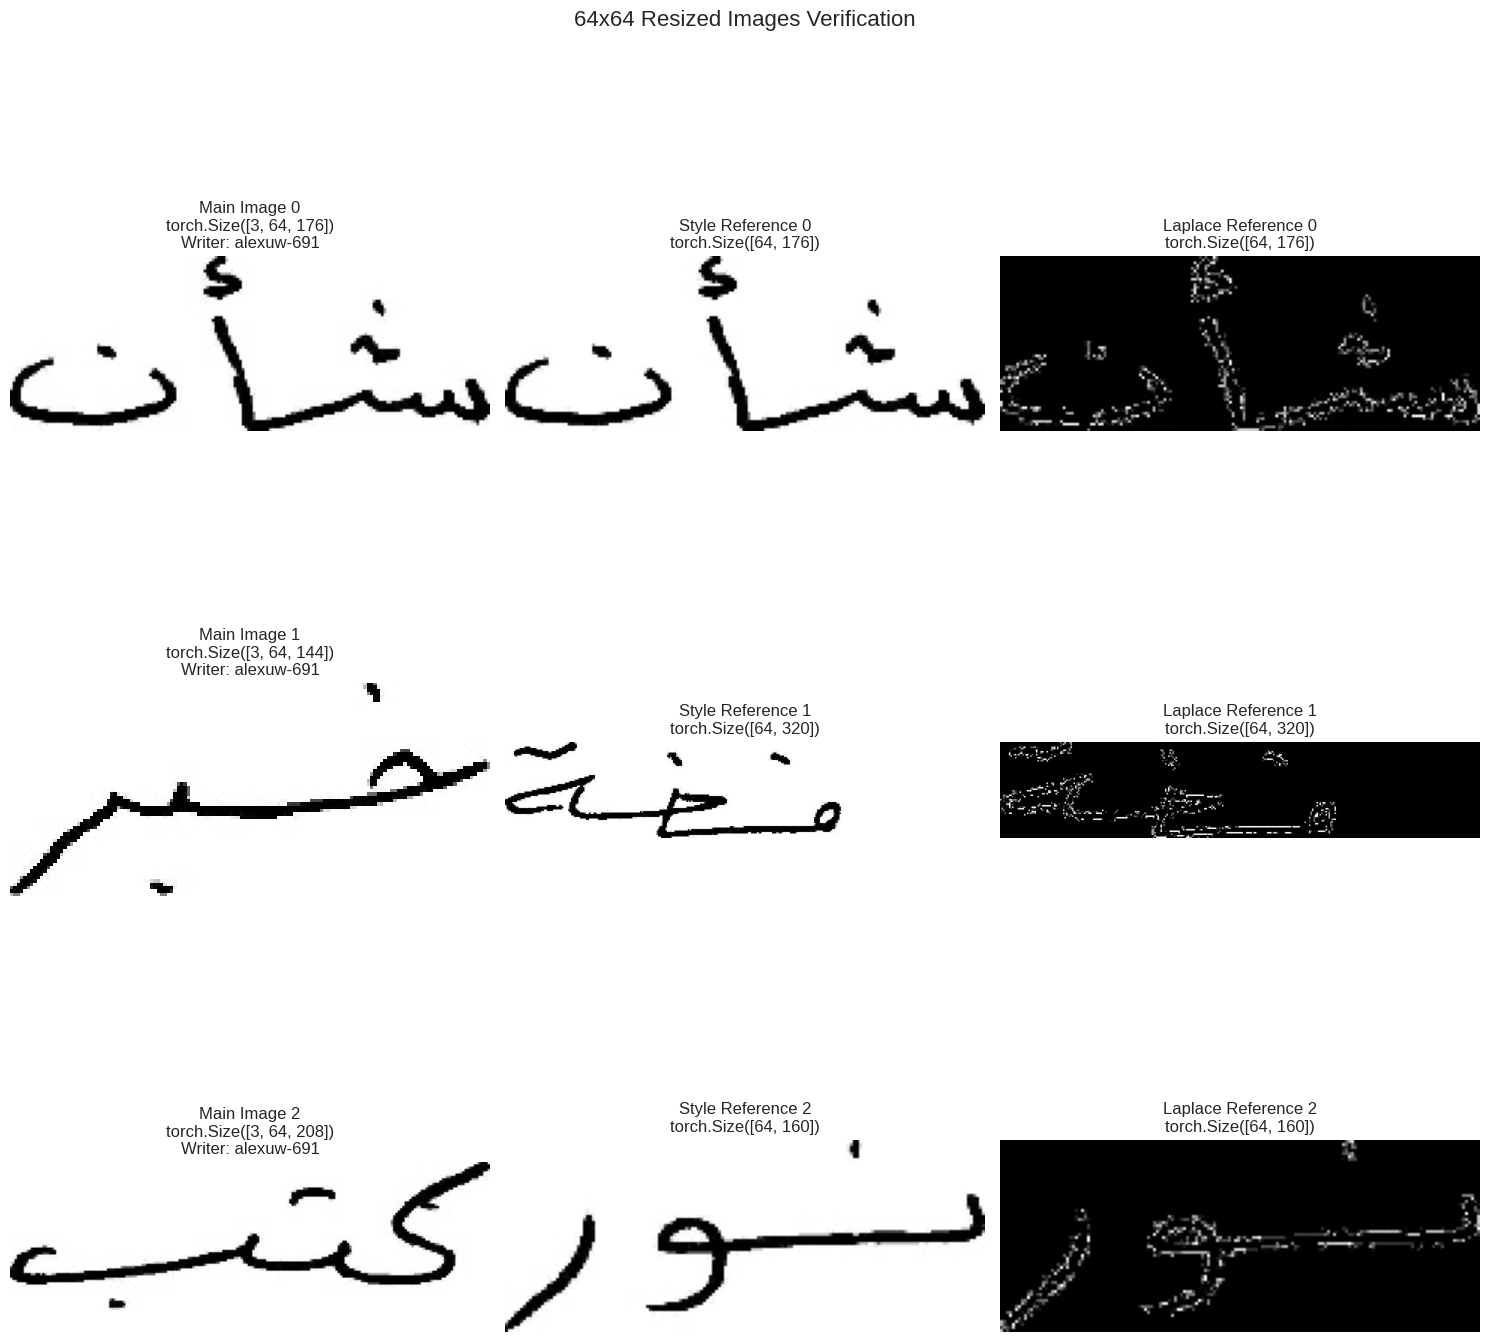


=== Testing Batch Collation ===
Individual sample shapes:
  Sample 0: img=torch.Size([3, 64, 176]), style=torch.Size([2, 64, 160])
  Sample 1: img=torch.Size([3, 64, 144]), style=torch.Size([2, 64, 176])
  Sample 2: img=torch.Size([3, 64, 208]), style=torch.Size([2, 64, 208])
  Sample 3: img=torch.Size([3, 64, 128]), style=torch.Size([2, 64, 320])
[DEBUG COLLATE] Sample 0: Original content='شأن', len=3
[DEBUG COLLATE] Sample 0: contextual_glyphs shape=torch.Size([3, 16, 16]) base_indices=[16, 1, 28]
[DEBUG COLLATE] letters : ['ش', 'أ', 'ن']
[DEBUG COLLATE] forms   : ['initial', 'final', 'isolated']
[DEBUG COLLATE] codepoints: ['0xfeb7', '0xfe84', '0x646']


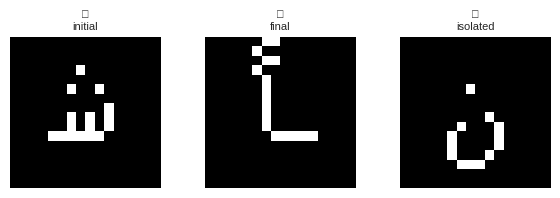


Collated batch shapes:
  Images: torch.Size([4, 3, 64, 208])
  Style: torch.Size([4, 2, 64, 320])
  Laplace: torch.Size([4, 2, 64, 320])
  Content: torch.Size([4, 3, 16, 16])
  Writer IDs (tensor): torch.Size([4])
  Writer IDs (strings): ['alexuw-691', 'alexuw-691', 'alexuw-691', 'alexuw-691']


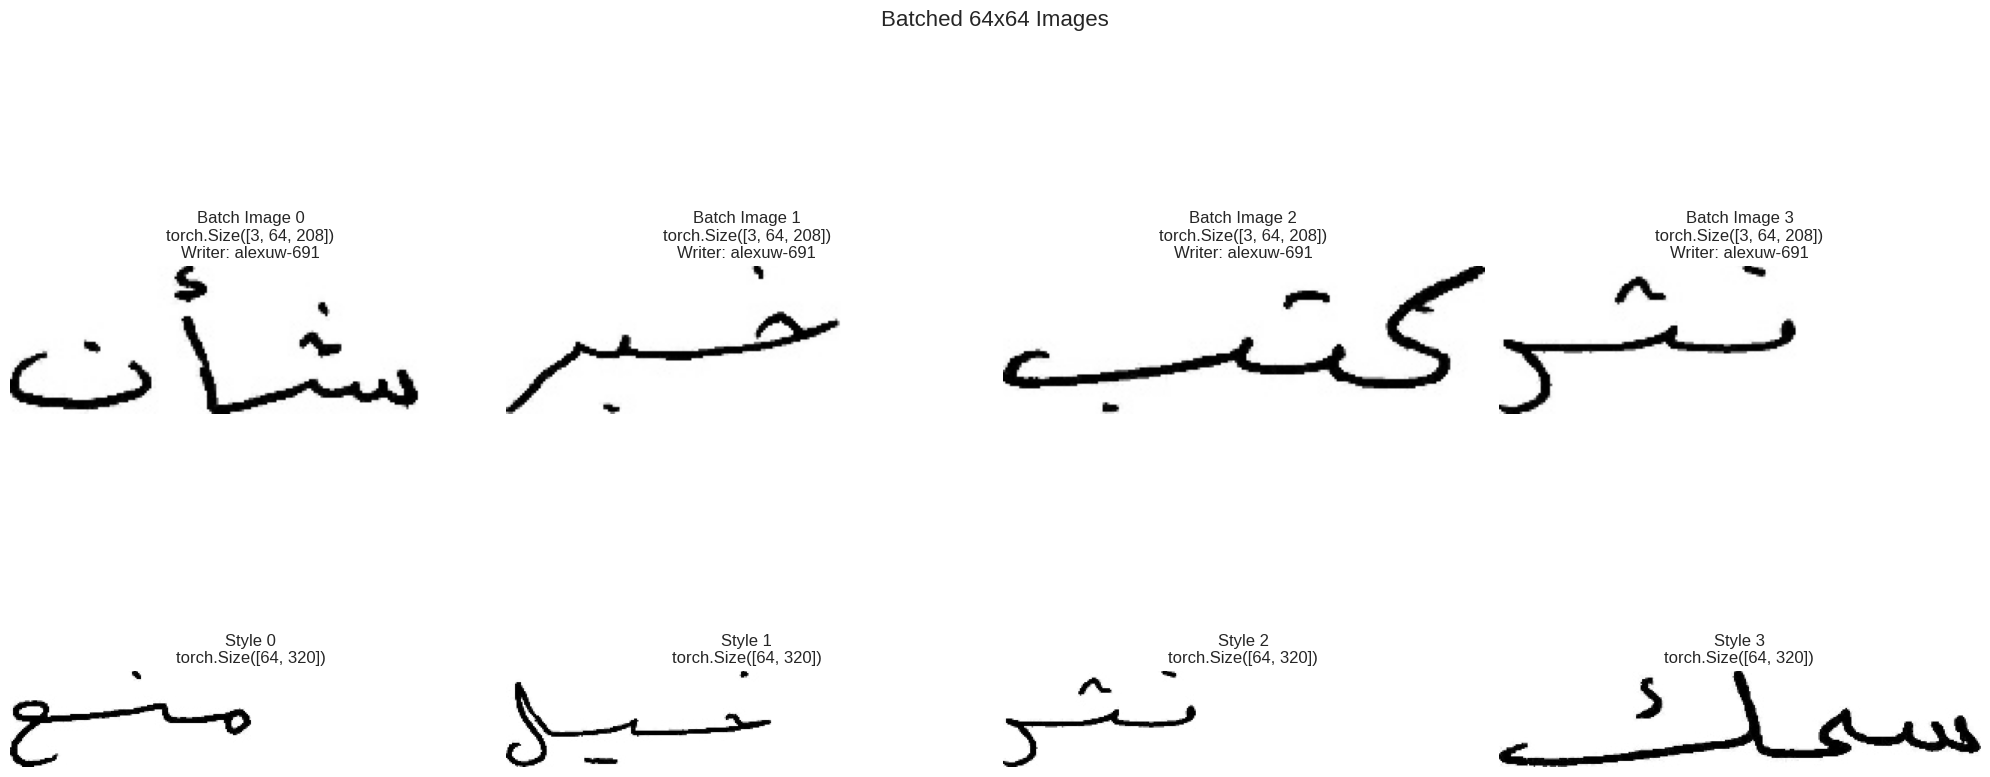


=== Summary ===
✅ All tests completed successfully!
✅ Style images loaded correctly
✅ Main images resized to 64x64: torch.Size([4, 3, 64, 208])
✅ Batch collation working properly
✅ Content generation working


In [29]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from parse_config import cfg, cfg_from_file, assert_and_infer_cfg
from data_loader.loader_ara import Random_StyleIAMDataset, IAMDataset, ContentData

def test_style_pipeline(writer_id=None, random=True):
    """
    Test the style pipeline to verify 64x64 resizing and image processing
    """
    print("=== Testing Style Pipeline ===")
    
    # Load config
    cfg_from_file('configs/IAM64_scratch.yml')
    assert_and_infer_cfg()
    
    # Initialize dataset
    style_dataset = Random_StyleIAMDataset(
        style_path=os.path.join(cfg.DATA_LOADER.STYLE_PATH, 'train'),
        laplace_path=os.path.join(cfg.DATA_LOADER.LAPLACE_PATH, 'train'),
        ref_num=1
    )
    
    print(f"Available writer IDs: {len(style_dataset.author_id)}")
    print(f"First 10 writer IDs: {style_dataset.author_id[:10]}")
    
    # Choose writer ID
    if writer_id is None:
        if random:
            writer_id = np.random.choice(style_dataset.author_id)
        else:
            writer_id = style_dataset.author_id[0]
    elif writer_id not in style_dataset.author_id:
        raise ValueError(f"Writer ID {writer_id} not found in dataset")
    
    print(f"\nTesting style pipeline with writer ID: {writer_id}")
    
    # Load style and laplace images
    style_img, laplace_img = style_dataset.get_style_ref(writer_id)
    
    print(f"Style image shape: {style_img.shape}")
    print(f"Laplace image shape: {laplace_img.shape}")
    print(f"Style value range: [{style_img.min():.3f}, {style_img.max():.3f}]")
    print(f"Laplace value range: [{laplace_img.min():.3f}, {laplace_img.max():.3f}]")
    
    # Display images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.imshow(style_img, cmap='gray')
    ax1.set_title(f"Style Reference - {writer_id}\nShape: {style_img.shape}")
    ax1.axis('off')
    
    ax2.imshow(laplace_img, cmap='gray')
    ax2.set_title(f"Laplace Features - {writer_id}\nShape: {laplace_img.shape}")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Convert to tensors
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    style_tensor = torch.from_numpy(style_img).unsqueeze(0).to(device)
    laplace_tensor = torch.from_numpy(laplace_img).unsqueeze(0).to(device)
    
    print(f"\nTensor conversion:")
    print(f"Style tensor shape: {style_tensor.shape}")
    print(f"Laplace tensor shape: {laplace_tensor.shape}")
    print(f"Device: {device}")
    
    return style_tensor, laplace_tensor, writer_id

def test_main_dataset_resizing():
    """
    Test the main IAMDataset to verify 64x64 resizing is applied
    """
    print("\n=== Testing Main Dataset 64x64 Resizing ===")
    
    # Load config
    cfg_from_file('configs/IAM64_scratch.yml')
    assert_and_infer_cfg()
    
    # Initialize main dataset
    dataset = IAMDataset(
        cfg.DATA_LOADER.IAMGE_PATH, 
        cfg.DATA_LOADER.STYLE_PATH, 
        cfg.DATA_LOADER.LAPLACE_PATH, 
        'train'
    )
    
    print(f"Dataset size: {len(dataset)}")
    
    # Test a few samples and plot them
    num_samples = min(3, len(dataset))
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        sample = dataset[i]
        img = sample['img']
        style = sample['style']
        laplace = sample['laplace']
        
        print(f"\nSample {i}:")
        print(f"  Main image shape: {img.shape}")
        print(f"  Style shape: {style.shape}")
        print(f"  Laplace shape: {laplace.shape}")
        print(f"  Writer ID: {sample['wid']}")
        print(f"  Content: {sample['content']}")
        print(f"  Image name: {sample['image_name']}")
        
        # --- OLD (remove this) -----------------------------------------------
        # # Verify main image is 64x64
        # if img.shape[1] == 64 and img.shape[2] == 64:
        #     print(f"  ✅ Main image correctly resized to 64x64")
        # else:
        #     print(f"  ❌ Main image NOT 64x64: {img.shape}")

        # --- NEW (add this) ---------------------------------------------------
        # Verify width is a multiple of 16
        if img.shape[2] % 16 == 0:
            print(f"  ✅ Width is multiple of 16 ({img.shape[2]})")
        else:
            print(f"  ❌ Width NOT multiple of 16 ({img.shape[2]})")
        
        # Convert tensor to numpy for plotting (C,H,W -> H,W,C)
        img_np = img.permute(1, 2, 0).numpy()
        # Denormalize from [-1,1] to [0,1] for display
        img_np = (img_np + 1.0) / 2.0
        img_np = np.clip(img_np, 0, 1)
        
        # Plot main image (64x64)
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"Main Image {i}\n{img.shape}\nWriter: {sample['wid']}")
        axes[i, 0].axis('off')
        
        # Plot style reference (first style image)
        style_np = style[0].numpy()  # Take first style image from pair
        axes[i, 1].imshow(style_np, cmap='gray')
        axes[i, 1].set_title(f"Style Reference {i}\n{style[0].shape}")
        axes[i, 1].axis('off')
        
        # Plot laplace reference (first laplace image)
        laplace_np = laplace[0].numpy()  # Take first laplace image from pair
        axes[i, 2].imshow(laplace_np, cmap='gray')
        axes[i, 2].set_title(f"Laplace Reference {i}\n{laplace[0].shape}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle("64x64 Resized Images Verification", fontsize=16, y=1.02)
    plt.show()
    
    return dataset

def test_batch_collation():
    """
    Test batch collation to see how images are handled in batches
    """
    print("\n=== Testing Batch Collation ===")
    
    # Load config
    cfg_from_file('configs/IAM64_scratch.yml')
    assert_and_infer_cfg()
    
    # Initialize dataset
    dataset = IAMDataset(
        cfg.DATA_LOADER.IAMGE_PATH, 
        cfg.DATA_LOADER.STYLE_PATH, 
        cfg.DATA_LOADER.LAPLACE_PATH, 
        'train'
    )
    
    # Create a small batch
    batch_size = 4
    batch = [dataset[i] for i in range(batch_size)]
    
    print(f"Individual sample shapes:")
    for i, sample in enumerate(batch):
        print(f"  Sample {i}: img={sample['img'].shape}, style={sample['style'].shape}")
    
    # Test collation
    collated = dataset.collate_fn_(batch)
    
    print(f"\nCollated batch shapes:")
    print(f"  Images: {collated['img'].shape}")
    print(f"  Style: {collated['style'].shape}")
    print(f"  Laplace: {collated['laplace'].shape}")
    print(f"  Content: {collated['content'].shape}")
    print(f"  Writer IDs (tensor): {collated['wid'].shape}")
    print(f"  Writer IDs (strings): {collated['wid_str']}")
    
    # Visualize the batched images
    fig, axes = plt.subplots(2, batch_size, figsize=(20, 10))
    
    for i in range(batch_size):
        # Plot main images (64x64)
        img_tensor = collated['img'][i]  # Shape: [3, 64, 64]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        # Denormalize from [-1,1] to [0,1] for display
        img_np = (img_np + 1.0) / 2.0
        img_np = np.clip(img_np, 0, 1)
        
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f"Batch Image {i}\n{img_tensor.shape}\nWriter: {collated['wid_str'][i]}")
        axes[0, i].axis('off')
        
        # Plot style references (first style from pair)
        style_tensor = collated['style'][i, 0]  # Shape: [H, W] - first style from pair
        axes[1, i].imshow(style_tensor.numpy(), cmap='gray')
        axes[1, i].set_title(f"Style {i}\n{style_tensor.shape}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Batched 64x64 Images", fontsize=16, y=1.02)
    plt.show()
    
    return collated

def test_content_pipeline():
    """
    Test content generation pipeline
    """
    print("\n=== Testing Content Pipeline ===")
    
    # Initialize content loader
    content_loader = ContentData()
    
    # Test Arabic texts
    test_texts = ["مرحبا", "شكرا", "أستاذ", "سلام", "وداعا"]
    
    for text in test_texts:
        content_glyphs = content_loader.get_content(text)
        print(f"Text: '{text}' -> Glyphs shape: {content_glyphs.shape}")
        
        # Visualize first few glyphs
        if len(text) > 0:
            fig, axes = plt.subplots(1, min(len(text), 5), figsize=(15, 3))
            if len(text) == 1:
                axes = [axes]
            
            for i in range(min(len(text), 5)):
                glyph = content_glyphs[0, i].numpy()
                axes[i].imshow(glyph, cmap='gray')
                axes[i].set_title(f"'{text[i]}'")
                axes[i].axis('off')
            
            plt.suptitle(f"Glyphs for: {text}")
            plt.tight_layout()
            plt.show()

def test_raw_image_sizes():
    """
    Test raw image sizes before any processing to understand the resize necessity
    """
    print("\n=== Testing Raw Image Sizes ===")
    
    # Load config
    cfg_from_file('configs/IAM64_scratch.yml')
    assert_and_infer_cfg()
    
    # Check a few raw images
    image_dir = cfg.DATA_LOADER.IAMGE_PATH
    style_dir = os.path.join(cfg.DATA_LOADER.STYLE_PATH, 'train')
    
    print(f"Checking images in: {image_dir}")
    print(f"Checking styles in: {style_dir}")
    
    # Sample a few image files
    if os.path.exists(image_dir):
        image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:5]
        print(f"\nRaw main image sizes:")
        for img_file in image_files:
            img_path = os.path.join(image_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                print(f"  {img_file}: {img.shape}")
    
    # Sample a few style files
    if os.path.exists(style_dir):
        style_files = [f for f in os.listdir(style_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:5]
        print(f"\nRaw style image sizes:")
        for style_file in style_files:
            style_path = os.path.join(style_dir, style_file)
            img = cv2.imread(style_path)
            if img is not None:
                print(f"  {style_file}: {img.shape}")

def simple_test_style_pipeline(writer_id=None, random=True):
    """
    Simple test function similar to user's original request
    """
    print("=== Simple Style Pipeline Test ===")
    
    # Load config
    cfg_from_file('configs/IAM64_scratch.yml')
    assert_and_infer_cfg()
    
    # Initialize dataset
    style_dataset = Random_StyleIAMDataset(
        style_path=os.path.join(cfg.DATA_LOADER.STYLE_PATH, 'train'),
        laplace_path=os.path.join(cfg.DATA_LOADER.LAPLACE_PATH, 'train'),
        ref_num=1
    )
    
    # Choose writer ID
    if writer_id is None:
        if random:
            writer_id = np.random.choice(style_dataset.author_id)
        else:
            writer_id = style_dataset.author_id[0]
    elif writer_id not in style_dataset.author_id:
        raise ValueError(f"Writer ID {writer_id} not found in dataset")
    
    print(f"Testing style pipeline with writer ID: {writer_id}")
    
    # Load style and laplace images
    style_img, laplace_img = style_dataset.get_style_ref(writer_id)
    
    # Display images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.imshow(style_img, cmap='gray')
    ax1.set_title("Original Style Reference")
    ax1.axis('off')
    
    ax2.imshow(laplace_img, cmap='gray')
    ax2.set_title("Laplace Features")
    ax2.axis('off')
    plt.show()
    
    # Convert to tensors
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    style_tensor = torch.from_numpy(style_img).unsqueeze(0).to(device)
    laplace_tensor = torch.from_numpy(laplace_img).unsqueeze(0).to(device)
    
    print(f"\nStyle tensor shape: {style_tensor.shape}")
    print(f"Laplace tensor shape: {laplace_tensor.shape}")
    print(f"Value ranges: [{style_tensor.min():.3f}, {style_tensor.max():.3f}]")
    
    return style_tensor, laplace_tensor

# Test style pipeline (simple version like user requested)
def run_simple_test():
    """Run the simple test similar to user's original request"""
    print("Running simple style pipeline test...\n")
    style_tensor, laplace_tensor = simple_test_style_pipeline()
    print("Simple test completed!")
    return style_tensor, laplace_tensor

def main():
    """
    Run all tests
    """
    print("Starting comprehensive style pipeline tests...\n")
    
    try:
        # Test 1: Raw image sizes
        test_raw_image_sizes()
        
        # Test 2: Style pipeline
        style_tensor, laplace_tensor, writer_id = test_style_pipeline()
        
        # Test 3: Main dataset resizing
        dataset = test_main_dataset_resizing()
        
        # Test 4: Batch collation
        collated_batch = test_batch_collation()
        
        # Test 5: Content pipeline
#         test_content_pipeline()
        
        print("\n=== Summary ===")
        print("✅ All tests completed successfully!")
        print(f"✅ Style images loaded correctly")
        print(f"✅ Main images resized to 64x64: {collated_batch['img'].shape}")
        print(f"✅ Batch collation working properly")
        print(f"✅ Content generation working")
        
    except Exception as e:
        print(f"\n❌ Test failed with error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main() 

In [30]:
!python -c "from data_loader.loader_ara import letters; print(f'Length of letters: {len(letters)}'); print(f'First 10 chars: {letters[:10]}'); print(f'Last 10 chars: {letters[-10:]}'); print(f'Total characters: {len(letters)}')"

Length of letters: 88
First 10 chars: ءأإآابتثجح
Last 10 chars: _`{|}~،؛؟ 
Total characters: 88
